<h1>Experiment 1</h1>
<h3>Test the number of layers acquired to output promising NODDI measure for three networks</h3>

In [1]:
import nibabel as nib
import numpy as np

from FormatData import generate_data, parser as data_parser
from Training import train_network
from utils.model import parser as model_parser
from Testing import test_model
from utils.nii_utils import mask_nii_data

2022-04-09 13:37:20.125136: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
train_subject = 's02_still'
test_subjects = ['s01_still']

In [3]:
class Namespace:
    """
    a class generate parser for cmd line args
    """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [4]:
"""
packages that handle graphs
"""
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from skimage.metrics import structural_similarity as compare_ssim
from utils import calc_ssim
%matplotlib inline
def plot_loss(cmd):
    """
    A function that used to plot the loss curve for the trained network.
    Args:
        cmd: String, the command line in the terminal
    """
    args = model_parser().parse_args(cmd.split())
    history = train_network(args)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def show_slices(slices, grayscale=True):
    """
    Function to display the slices

    Args:
        slices (list): a list of 2d ndarray that contains the data to be displayed
        grayscale (bool, optional): True, if diplay grayscale img. Defaults to True.
    """    
    fig, axes = plt.subplots(1, len(slices), figsize=(10,10))
    cax = fig.add_axes([0, 0, .3, .3])
    for i, slice in enumerate(slices):
        # use grayscale for displaying ref and pred imgs:
        if grayscale:
            cmap = plt.get_cmap('gray')
            cmaplist = [cmap(i) for i in range(cmap.N)]
            cmap = LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
            bounds = np.arange(0, 1.01, .01)
            idx = np.searchsorted(bounds, 0)
            bounds = np.insert(bounds, idx, 0)
            norm = BoundaryNorm(bounds, cmap.N)
            im = axes[i].imshow(slice.T, cmap=cmap, origin="lower", interpolation='none', norm=norm)
        else:
            # define the colormap
            cmap = plt.get_cmap('bwr')
            # extract all colors from the .jet map
            cmaplist = [cmap(i) for i in range(cmap.N)]
            # create the new map
            cmap = LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
            # define the bins and normalize and forcing 0 to be part of the colorbar
            # define the min and max to be -1 and +1 respectively
            bounds = np.arange(-0.11, 0.11, .01)
            idx = np.searchsorted(bounds, 0)
            bounds = np.insert(bounds, idx, 0)
            norm = BoundaryNorm(bounds, cmap.N)
            im = axes[i].imshow(slice.T, cmap=cmap, origin="lower", interpolation='none', norm=norm)
        fig.colorbar(im, cax=cax, orientation='vertical')

def scale(img):
    # for i in range(img.shape[0]):
    #     for j in range(img.shape[1]):
    #         img[i][j] = ((img[i][j]+1)/2)*255
    return img

def compare_simi(pred, ref):
    return calc_ssim(pred, ref)

In [5]:
def visualise0(ref):
    """
    Function to visualise the ref imgs

    Args:
        ref (ndarray): the reference data
    """
    # visualise the ref imgs
    ref0 = ref[26, :, :]
    ref1 = ref[:, 30, :]
    ref2 = ref[:, :, 16]
    show_slices([ref0, ref1, ref2])
    plt.suptitle("Center slices for reference image")


def visualise1(ref_ndi, retained_vol, subject, model, layer, affine):
    """
    Function to visualise the NDI imgs and store the difference map

    Args:
        ref_ndi (ndarray): the reference NDI data
        subject (string): the subject that is examined
        model (string): the model used
        layer (int): the number of layers for the network
        retained_vol (int): the number of volumes used
    """
    patch = 3
    if model == 'fc1d':
        patch = 1

    print(patch)
    print(model)
    # visualise the ref imgs
    refNDI0 = ref_ndi[26, :, :]
    refNDI1 = ref_ndi[:, 30, :]
    refNDI2 = ref_ndi[:, :, 16]

    # visualise the pred imgs produced at varied input size
    ndi_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_NDIsynthetic.nii'
    ndi_img = nib.load(ndi_path)
    ndi_data = ndi_img.get_fdata()

    ndi0 = ndi_data[26, :, :]
    ndi1 = ndi_data[:, 30, :]
    ndi2 = ndi_data[:, :, 16]
    show_slices([ndi0, ndi1, ndi2])
    plt.suptitle('Center slices for NDI predicted image by '+model+', input size='+str(retained_vol))
    (score, ndidiff) = compare_ssim(ndi_data, ref_ndi, full=True)
    print(str(retained_vol)+'input size the ssim score for ndi is: ' + str(score))

    # plot the difference map between the imgs by the lib
    ndidiff0 = scale(refNDI0 - ndi0)
    ndidiff1 = scale(refNDI1 - ndi1)
    ndidiff2 = scale(refNDI2 - ndi2)
    show_slices([ndidiff0, ndidiff1, ndidiff2], grayscale=False)
    plt.suptitle("Difference map NDI")

    diff_img_np = ref_ndi - ndi_data
    diff_img = nib.Nifti1Image(diff_img_np, affine)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_NDI_difference_synthetic.nii')

def visualise2(ref_odi, retained_vol, subject, model, layer, affine):
    """
    Function to visualise the ODI imgs and difference maps

    Args:
        ref_odi (ndarray): the reference ODI data
        retained_vol (int): the number of volumes retained after rejection
        subject (string): the subject that is examined
        model (string): the model used
        layer (int): the number of layers for the network
    """
    patch = 3
    if model == 'fc1d':
        patch = 1

    print(patch)
    print(model)
    # visualise the ref imgs
    refODI0 = ref_odi[26, :, :]
    refODI1 = ref_odi[:, 30, :]
    refODI2 = ref_odi[:, :, 16]

    # visualise the pred imgs produced at varied input size
    odi_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_ODIsynthetic.nii'
    odi_img = nib.load(odi_path)
    odi_data = odi_img.get_fdata()

    odi0 = odi_data[26, :, :]
    odi1 = odi_data[:, 30, :]
    odi2 = odi_data[:, :, 16]
    show_slices([odi0, odi1, odi2])
    plt.suptitle('Center slices for ODI predicted image by '+model+', input size='+str(retained_vol))
    (score, odidiff) = compare_ssim(odi_data, ref_odi, full=True)
    print(str(retained_vol)+'input size the ssim score for odi is: ' + str(score))

    odidiff0 = scale(refODI0 - odi0)
    odidiff1 = scale(refODI1 - odi1)
    odidiff2 = scale(refODI2 - odi2)
    show_slices([odidiff0, odidiff1, odidiff2], grayscale=False)
    plt.suptitle("Difference map ODI")

    diff_img_np = ref_odi - odi_data
    diff_img = nib.Nifti1Image(diff_img_np, affine)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_ODI_difference_synthetic.nii')

def visualise3(ref_fwf, retained_vol, subject, model, layer, affine):
    """
    Function to visualise the fwf imgs and difference maps

    Args:
        ref_fwf (ndarray): the reference FWF data
        retained_vol (int): the number of volumes retained after rejection
        subject (string): the subject that is examined
        model (string): the model used
        layer (int): the number of layers for the network
    """
    patch = 3
    if model == 'fc1d':
        patch = 1

    print(patch)
    print(model)
    # visualise the ref imgs
    refFWF0 = ref_fwf[26, :, :]
    refFWF1 = ref_fwf[:, 30, :]
    refFWF2 = ref_fwf[:, :, 16]

    # visualise the pred imgs produced at varied input size
    fwf_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_FWFsynthetic.nii'
    fwf_img = nib.load(fwf_path)
    fwf_data = fwf_img.get_fdata()

    fwf0 = fwf_data[26, :, :]
    fwf1 = fwf_data[:, 30, :]
    fwf2 = fwf_data[:, :, 16]
    show_slices([fwf0, fwf1, fwf2])
    plt.suptitle('Center slices for FWF predicted image by '+model+', input size='+str(retained_vol))
    (score, fwfdiff) = compare_ssim(fwf_data, ref_fwf, full=True)
    print(str(retained_vol)+'input size the ssim score for fwf is: ' + str(score))

    # plot the difference map between the imgs by the lib
    fwfdiff0 = scale(refFWF0 - fwf0)
    fwfdiff1 = scale(refFWF1 - fwf1)
    fwfdiff2 = scale(refFWF2 - fwf2)
    show_slices([fwfdiff0, fwfdiff1, fwfdiff2], grayscale=False)
    plt.suptitle("Difference map FWF")

    diff_img_np = ref_fwf - fwf_data
    diff_img = nib.Nifti1Image(diff_img_np, affine)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_FWF_difference_synthetic.nii')

def visualise4(ref_ndi, ref_odi, ref_fwf, retained_vol, subject, model, layer, affine1, affine2, affine3):
    """
    Function to visualise the imgs and difference maps

    Args:
        ref_ndi (ndarray): the reference NDI data
        ref_odi (ndarray): the reference ODI data
        ref_fwf (ndarray): the reference FWF data
        retained_vol (int): the number of volumes retained after rejection
        subject (string): the subject that is examined
        model (string): the model used
        layer (int): the number of layers for the network
    """
    patch = 3
    if model == 'fc1d':
        patch = 1

    print(patch)
    print(model)
    # visualise the ref imgs
    refNDI0 = ref_ndi[26, :, :]
    refNDI1 = ref_ndi[:, 30, :]
    refNDI2 = ref_ndi[:, :, 16]

    refODI0 = ref_odi[26, :, :]
    refODI1 = ref_odi[:, 30, :]
    refODI2 = ref_odi[:, :, 16]

    refFWF0 = ref_fwf[26, :, :]
    refFWF1 = ref_fwf[:, 30, :]
    refFWF2 = ref_fwf[:, :, 16]

    # visualise the pred imgs produced at varied input size
    ndi_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_NDIsynthetic.nii'
    odi_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_ODIsynthetic.nii'
    fwf_path = '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_FWFsynthetic.nii'
    ndi_img = nib.load(ndi_path)
    ndi_data = ndi_img.get_fdata()
    odi_img = nib.load(odi_path)
    odi_data = odi_img.get_fdata()
    fwf_img = nib.load(fwf_path)
    fwf_data = fwf_img.get_fdata()

    ndi0 = ndi_data[26, :, :]
    ndi1 = ndi_data[:, 30, :]
    ndi2 = ndi_data[:, :, 16]
    show_slices([ndi0, ndi1, ndi2])
    plt.suptitle('Center slices for NDI predicted image by '+model+', input size='+str(retained_vol))
    (score, ndidiff) = compare_ssim(ndi_data, ref_ndi, full=True)
    print(str(retained_vol)+'input size the ssim score for ndi is: ' + str(score))

    odi0 = odi_data[26, :, :]
    odi1 = odi_data[:, 30, :]
    odi2 = odi_data[:, :, 16]
    show_slices([odi0, odi1, odi2])
    plt.suptitle('Center slices for ODI predicted image by '+model+', input size='+str(retained_vol))
    (score, odidiff) = compare_ssim(odi_data, ref_odi, full=True)
    print(str(retained_vol)+'input size the ssim score for odi is: ' + str(score))

    fwf0 = fwf_data[26, :, :]
    fwf1 = fwf_data[:, 30, :]
    fwf2 = fwf_data[:, :, 16]
    show_slices([fwf0, fwf1, fwf2])
    plt.suptitle('Center slices for FWF predicted image by '+model+', input size='+str(retained_vol))
    (score, fwfdiff) = compare_ssim(fwf_data, ref_fwf, full=True)
    print(str(retained_vol)+'input size the ssim score for fwf is: ' + str(score))

    # plot the difference map between the imgs by the lib
    ndidiff0 = scale(refNDI0 - ndi0)
    ndidiff1 = scale(refNDI1 - ndi1)
    ndidiff2 = scale(refNDI2 - ndi2)
    show_slices([ndidiff0, ndidiff1, ndidiff2], grayscale=False)
    plt.suptitle("Difference map NDI")

    diff_img_np = ref_ndi - ndi_data
    diff_img = nib.Nifti1Image(diff_img_np, affine1)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_NDI_difference_synthetic.nii')

    odidiff0 = scale(refODI0 - odi0)
    odidiff1 = scale(refODI1 - odi1)
    odidiff2 = scale(refODI2 - odi2)
    show_slices([odidiff0, odidiff1, odidiff2], grayscale=False)
    plt.suptitle("Difference map ODI")

    diff_img_np = ref_odi - odi_data
    diff_img = nib.Nifti1Image(diff_img_np, affine2)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_ODI_difference_synthetic.nii')

    fwfdiff0 = scale(refFWF0 - fwf0)
    fwfdiff1 = scale(refFWF1 - fwf1)
    fwfdiff2 = scale(refFWF2 - fwf2)
    show_slices([fwfdiff0, fwfdiff1, fwfdiff2], grayscale=False)
    plt.suptitle("Difference map FWF")

    diff_img_np = ref_fwf - fwf_data
    diff_img = nib.Nifti1Image(diff_img_np, affine3)
    nib.save(diff_img, '../Net/nii/'+subject+'-'+str(retained_vol)+'-'+model+'-patch_'+str(patch)+'-base_1-layer_'+str(layer)+'-label_FWF_difference_synthetic.nii')

___
<h3>Data Preprocessing</h3>

In [6]:
# motion-free subject path
s01_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/'
s02_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/'
s03_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/'
s04_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/'
# motion-free target labels
s01_NDI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/s01_still_NDI.nii'
s02_NDI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/s02_still_NDI.nii'
s03_NDI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/s03_still_reg_NDI.nii'
s04_NDI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/s04_still_reg_NDI.nii'

s01_ODI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/s01_still_ODI.nii'
s02_ODI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/s02_still_ODI.nii'
s03_ODI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/s03_still_reg_ODI.nii'
s04_ODI_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/s04_still_reg_ODI.nii'

s01_FWF_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/s01_still_FWF.nii'
s02_FWF_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/s02_still_FWF.nii'
s03_FWF_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/s03_still_reg_FWF.nii'
s04_FWF_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/s04_still_reg_FWF.nii'

In [7]:
def filter_mask(subpath, fwfpath, threshold=0.99):
    """
    By looking at the imgs generated, we have found out there are some regions that should not be included. Since they have values higher than 1.0
    And we have found out voxels have NDI and ODI values, while that voxel has GROUND TRUTH FWF 1.0
    This should indicate that that voxel should not even be included in the training
    Therefore we want to filter the each subject's mask first, by using their corresponding GROUND TRUTH FWF

    Args:
        subpath (string): the path of the subject folder
        fwfpath (string): the path of the corresponding fwf file
        threshold (float): the thresholds to be used to filter of the mask,
                           a stringnent threshold would be 0.9, the least stringnent threshold is 1.0
                           by default, it is set to 0.99
    """
    # fetch the mask data
    img_mask = nib.load(subpath+'mask-e.nii')
    original_mask = img_mask.get_fdata()
    original_affine = img_mask.affine
    shape = original_mask.shape # retain the shape of the mask
    origin_nonzeros = np.count_nonzero(original_mask)
    print('original mask has: ' + str(origin_nonzeros) + ' of nonzero voxels')
    # fetch the FWF data
    fwf = nib.load(fwfpath).get_fdata()
    # filter
    mask = original_mask.flatten() # this makes a copy of the orginal mask
    fwf = fwf.reshape(mask.shape[0]) # reshape fwf to the corresponding shape
    for i in range(len(mask)):
        # if fwf has high value, means there is no tissue
        # therefore, the voxel should be excluded
        if fwf[i] >= threshold:
            mask[i] = 0.0
    # reshape mask back
    mask = mask.reshape(shape)
    filter_nonzeros = np.count_nonzero(mask)
    print('filtered mask has: ' +str(filter_nonzeros) + ' of nonzero voxels')
    # save the mask
    filter_img = nib.Nifti1Image(mask, original_affine)
    nib.save(filter_img, subpath+'filtered_mask.nii')

In [8]:
# Use the above code to filter each subject's mask. Store as filtered_mask.nii in each subject folder
filter_mask(s01_path, s01_FWF_path)
filter_mask(s02_path, s02_FWF_path)
filter_mask(s03_path, s04_FWF_path)
filter_mask(s04_path, s03_FWF_path)

original mask has: 82889 of nonzero voxels
filtered mask has: 81882 of nonzero voxels
original mask has: 94198 of nonzero voxels
filtered mask has: 91401 of nonzero voxels
original mask has: 91131 of nonzero voxels
filtered mask has: 89491 of nonzero voxels
original mask has: 88241 of nonzero voxels
filtered mask has: 87347 of nonzero voxels


In [9]:
# filtered mask path for each subject
s01_mask_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s01_still/filtered_mask.nii'
s02_mask_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s02_still/filtered_mask.nii'
s03_mask_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s03_still_reg/filtered_mask.nii'
s04_mask_path = '/home/vw/Desktop/IndividualProject/MedICSS2021_/Data-NODDI/s04_still_reg/filtered_mask.nii'

In [10]:
# A simple test to verify the algorithm mask_nii_data from utils.nii_utils correctly generates the 1x1 patch from (a) given volume(s) DWI
s02_mask_data = nib.load(s02_mask_path).get_fdata()
print(s02_mask_data.shape)
# generate a random mask
random_mask = np.zeros((s02_mask_data.shape[0],s02_mask_data.shape[1], s02_mask_data.shape[2]))
print(random_mask.shape)
# select some pixels' values in the random_mask turn into 1
# randomly select 4 paris of x, y value
for i in range(4):
    rand_x = np.random.randint(low=0, high=s02_mask_data.shape[0])
    rand_y = np.random.randint(low=0, high=s02_mask_data.shape[1])
    rand_z = np.random.randint(low=0, high=s02_mask_data.shape[2])
    # set the corresponding pixel to have value 1
    random_mask[rand_x][rand_y][rand_z] = 1
# by this, we know the ground truth for this test. The number of 1s in the mask = the number of 1x1 pacth generated from the algorithm
# we apply the random mask onto the s02_mask
data = mask_nii_data(data=s02_mask_data, mask=random_mask)

(84, 84, 50)
(84, 84, 50)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (4, 1) the ratio of masked voxel is: 1.1337868480725624e-05


<strong>Interpret the result from the algorithm test.</strong>
The s02_mask has only one volume of shape (84,84,50). The random mask has a shape (84,84,50).</br>
We randomly turned 4 pixels in the random mask to 1. Then apply the random mask to the s02_mask.</br>
<strong>What we expect to see, there should be 4 patches generated for each volume of s02_mask.</strong></br>
Results show that the data afer masking (by the random mask) has a shape (4,1). Where 4 represents the number of 1x1 patches and 1 represent the volume of s02_mask.</br>
Therefore, it suggests the algorithm works fine.

In [11]:
"""
Generate base datasets for each subject
"""
ltype = ['N','O','F','A']
for l in ltype:
    print('Generating basedataset for label: ' + l)
    cmd = '--base --label_type ' + l + ' --subjects s01_still s02_still'
    args = data_parser().parse_args(cmd.split())
    generate_data(args)

Generating basedataset for label: N
Generating for s01_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)
Generating for s02_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)
Generating basedataset for label: O
Generating for s01_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)
Generating for s02_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)
Generating basedataset for label: F
Generating for s01_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)
Generating for s02_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 1)
Generating basedataset for label: A
Generating for s01_still ...
base data dataset has shape: (84, 84, 50, 96)
base label dataset has shape: (84, 84, 50, 3)
Generatin

In [11]:
"""
Using nib to fetch the ground truth img
"""
#load the truth data for subject 1
s01_NDI_img = nib.load(s01_NDI_path)
s01_ODI_img = nib.load(s01_ODI_path)
s01_FWF_img = nib.load(s01_FWF_path)
s01_NDI_affine = s01_NDI_img.affine
s01_ODI_affine = s01_ODI_img.affine
s01_FWF_affine = s01_FWF_img.affine
s01_NDI_img_data = s01_NDI_img.get_fdata()
s01_ODI_img_data = s01_ODI_img.get_fdata()
s01_FWF_img_data = s01_FWF_img.get_fdata()
#load the truth data for subject 2
s02_NDI_img = nib.load(s02_NDI_path)
s02_ODI_img = nib.load(s02_ODI_path)
s02_FWF_img = nib.load(s02_FWF_path)
s02_NDI_affine = s02_NDI_img.affine
s02_ODI_affine = s02_ODI_img.affine
s02_FWF_affine = s02_FWF_img.affine
s02_NDI_img_data = s02_NDI_img.get_fdata()
s02_ODI_img_data = s02_ODI_img.get_fdata()
s02_FWF_img_data = s02_FWF_img.get_fdata()
# load the truth data for subject 3
s03_NDI_img = nib.load(s03_NDI_path)
s03_ODI_img = nib.load(s03_ODI_path)
s03_FWF_img = nib.load(s03_FWF_path)
s03_NDI_affine = s03_NDI_img.affine
s03_ODI_affine = s03_ODI_img.affine
s03_FWF_affine = s03_FWF_img.affine
s03_NDI_img_data = s03_NDI_img.get_fdata()
s03_ODI_img_data = s03_ODI_img.get_fdata()
s03_FWF_img_data = s03_FWF_img.get_fdata()
# load the truth data for subject 4
s04_NDI_img = nib.load(s04_NDI_path)
s04_ODI_img = nib.load(s04_ODI_path)
s04_FWF_img = nib.load(s04_FWF_path)
s04_NDI_affine = s04_NDI_img.affine
s04_ODI_affine = s04_ODI_img.affine
s04_FWF_affine = s04_FWF_img.affine
s04_NDI_img_data = s04_NDI_img.get_fdata()
s04_ODI_img_data = s04_ODI_img.get_fdata()
s04_FWF_img_data = s04_FWF_img.get_fdata()

___

<strong>NDI</strong>

In [13]:
"""
Generate training dataset NDI for ANN.
"""
cmd = "--subjects s01_still s02_still --fc1d --label_type N"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (352800,)
data befor masking has shape: (352800, 96)
data after masking has shape: (81882, 96) the ratio of masked voxel is: 0.23209183673469388
training dataset has shape:(81882, 96)
(84, 84, 50, 1)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (81882, 1) the ratio of masked voxel is: 0.23209183673469388
training label has shape:(81882, 1)
Generating for s02_still ...
mask has shape: (352800,)
data befor masking has shape: (352800, 96)
data after masking has shape: (91401, 96) the ratio of masked voxel is: 0.2590731292517007
training dataset has shape:(91401, 96)
(84, 84, 50, 1)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (91401, 1) the ratio of masked voxel is: 0.2590731292517007
training label has shape:(91401, 1)


<strong>
Interpret this result.
</strong> 
After the mask is applied to 96 volumes of DWI imgs, for each volume of img, there are 81882 1x1 patches (i.e. voxels) generated. Therefore, in total there are 81882x96=7860672 values as training dataset. <br/>
For each masked voxel, there is a corresponding NDI value. Therefore, the number of NDI values is the same as the number of masked voxels (82889). Becasue we are examine NDI only, hence only one value associated with each masked voxel.

In [14]:
# Generate the dataset for 2D CNN
cmd = "--subjects s01_still s02_still --conv2d --label_type N"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 48, 96)
label has shape: (82, 82, 48, 1)
(81634, 3, 3, 96)
saved patches has shape: (81634, 3, 3, 96)
(81634, 1, 1, 1)
svaed labels has shape: (81634, 1, 1, 1)
Generating for s02_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 48, 96)
label has shape: (82, 82, 48, 1)
(90846, 3, 3, 96)
saved patches has shape: (90846, 3, 3, 96)
(90846, 1, 1, 1)
svaed labels has shape: (90846, 1, 1, 1)


<strong>
Interpret the result
</strong>
The masked voxels are 81634. For each masked voxel, there is a 3x3 patch which includes this masked voxel at the centre of the patch; but also including its 8 neighbouring voxels. Each masked voxel has 96 volumes of the 3x3 patch. Therefore, in total there are 81634 x 3 x 3 x 96 = 70531776 values as the training dataset.<br/>
Herein, because we only examine NDI. For each masked voxel, there is a corresponded predicted NDI value. Hence the number of masked voxels is the same for label and data. The label size is 1x1 because it is the NDI parameter for the masked voxel. The masked voxel has a size 1x1. And there is only one of this value for each masked voxel, since only NDI is considered.

In [15]:
# Generate the dataset for 3D CNN
cmd = "--subjects s01_still s02_still --conv3d --label_type N"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 50, 96)
label has shape: (82, 82, 48, 1)
(84, 84, 50, 96) (82, 82, 48)
(81634, 3, 3, 3, 96)
saved patches has shape: (81634, 2592)
(82, 82, 48, 1) (82, 82, 48)
(81634, 1, 1, 1, 1)
svaed labels has shape: (81634, 1, 1, 1, 1)
Generating for s02_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 50, 96)
label has shape: (82, 82, 48, 1)
(84, 84, 50, 96) (82, 82, 48)
(90846, 3, 3, 3, 96)
saved patches has shape: (90846, 2592)
(82, 82, 48, 1) (82, 82, 48)
(90846, 1, 1, 1, 1)
svaed labels has shape: (90846, 1, 1, 1, 1)


<strong>
Interpret the result
</strong>
The masked voxels are 81634. For each masked voxel, there is a 3x3x3 patch which includes this masked voxel at the centre of the patch; but also including its 26 neighbouring voxels. Each masked voxel has 96 volumes of 3x3x3 patch. Therefore, in total there are 81634 x 3 x 3 x 3 x 96 = 211595328 values as the training dataset.<br/>
Herein, because we only examine NDI. For each masked voxel, there is a corresponded predicted NDI value. Hence the number of masked voxels is the same for label and data. The label size is 1x1x1 because it is the NDI parameter for the masked voxel. The masked voxel has a size 1x1x1. And there is only one of this value for each masked voxel, since only NDI is considered.

<h4>Training</h4>

<strong>
The split between validation dataset and the training dataset is 5:5<br/>
The learning rate is 0.0001 to ensure a smooth learning<br/>
Herein, at most 6 hidden fully connected layers are trained.<br/>
Loss curve for each training is plotted.<br/>
The test result is also generated -- evaluating the RMSE and SSIM between pred and reference.<br/>
The reference image and the genereated image are displayed side by side.</br>
The difference map between the ref img and the pred img is also generated
</strong>

<strong>1 layer</strong>

In [16]:
layer = 1

ANN

96
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense (Dense)                (None, 150)               14550     
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu (ReLU)                 (None, 1)                 0         
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
['N']


2022-04-07 15:21:04.806279: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-04-07 15:21:04.848042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 15:21:04.848138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.777GHz coreCount: 28 deviceMemorySize: 11.76GiB deviceMemoryBandwidth: 335.32GiB/s
2022-04-07 15:21:04.848157: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-07 15:21:04.864866: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-07 15:21:04.887915: I tensorflow/stream_executor/pl

The remained data has shape: (91401, 96)
(91401, 96)
(91401, 150)
(91401, 150)
(91401, 1)
(91401, 1)
Training start ...


2022-04-07 15:21:05.302414: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:21:05.302456: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 1 GPUs
2022-04-07 15:21:05.306469: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcupti.so.10.1
2022-04-07 15:21:05.308663: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2022-04-07 15:21:05.553151: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:21:05.555177: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:21:05.556560: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:21:05.558323: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_21_05
2022-04-07 15:21:05.558810: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_21_05/vw.trace.json.gz
2022-04-07 15:21:05.558866: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:21:05.561017: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

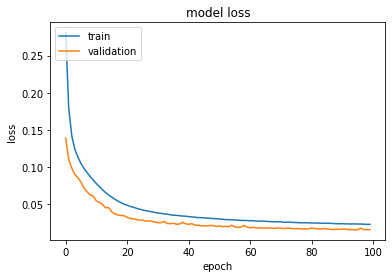

In [17]:
# 1 layer training
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)

In [18]:
# 1 layer testing
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96-fc1d-patch_1-base_1-layer_1-label_NDIsynthetic
(84, 50, 96)
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               14550     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1)                 0         
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
testing data shape: (84, 84, 50, 96)
prediction has s

/home/vw/anaconda3/envs/project/lib/python3.7/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


2D CNN

96
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 150)         129750    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 1, 1, 1)           0         
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
['N']
The remained data has shape: (90846, 3, 3, 96)
(90846, 3, 3, 96)
(90846, 1, 1, 150)
(90846, 1, 1, 150)
(9

2022-04-07 15:21:33.578744: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 627927552 exceeds 10% of free system memory.
2022-04-07 15:21:33.847679: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:21:33.847818: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


Training start ...


2022-04-07 15:21:34.253675: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:21:34.268586: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:21:34.268807: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:21:34.269777: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_21_34
2022-04-07 15:21:34.270193: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_21_34/vw.trace.json.gz
2022-04-07 15:21:34.270249: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:21:34.270979: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

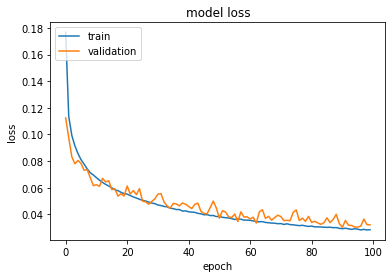

In [19]:
# 1 layer training
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)

In [20]:
# 1 layer testing
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96-conv2d-patch_3-base_1-layer_1-label_NDIsynthetic
(84, 84, 96)
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 82, 82, 150)       129750    
_________________________________________________________________
dropout_3 (Dropout)          (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 82, 82, 1)         151       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 82, 82, 1)         0         
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
testing data shape: (50, 84, 84, 96)
prediction 

3D CNN

96
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d (Conv3D)              (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 1, 1, 1, 1)        0         
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
['N']
The remained data has shape: (90846, 3, 3, 3, 96)


2022-04-07 15:22:25.332796: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 1883782656 exceeds 10% of free system memory.
2022-04-07 15:22:25.859832: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 941891328 exceeds 10% of free system memory.


(90846, 3, 3, 3, 96)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 1)
(90846, 1, 1, 1, 1)
Training start ...


2022-04-07 15:22:26.121548: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:22:26.121653: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:22:26.430529: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 753504768 exceeds 10% of free system memory.


2022-04-07 15:22:26.867142: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:22:26.884060: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:22:26.884290: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:22:26.885285: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_22_26
2022-04-07 15:22:26.885712: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_22_26/vw.trace.json.gz
2022-04-07 15:22:26.885773: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:22:26.886555: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

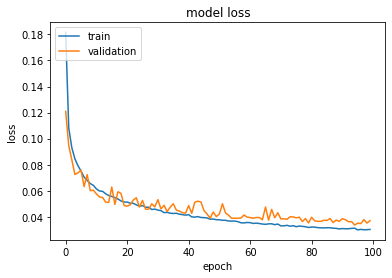

In [21]:
# 1 layer training
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)

In [22]:
# 1 layer testing
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96-conv3d-patch_3-base_1-layer_1-label_NDIsynthetic
(84, 84, 50)
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
dropout_5 (Dropout)          (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 82, 82, 48, 1)     151       
_________________________________________________________________
re_lu_5 (ReLU)               (None, 82, 82, 48, 1)     0         
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
testing data shape: (1, 84, 84, 50, 96)
predicti

1
fc1d
96input size the ssim score for ndi is: 0.9829158710390075
3
conv2d
96input size the ssim score for ndi is: 0.9798956242450024
3
conv3d
96input size the ssim score for ndi is: 0.9778767500842549


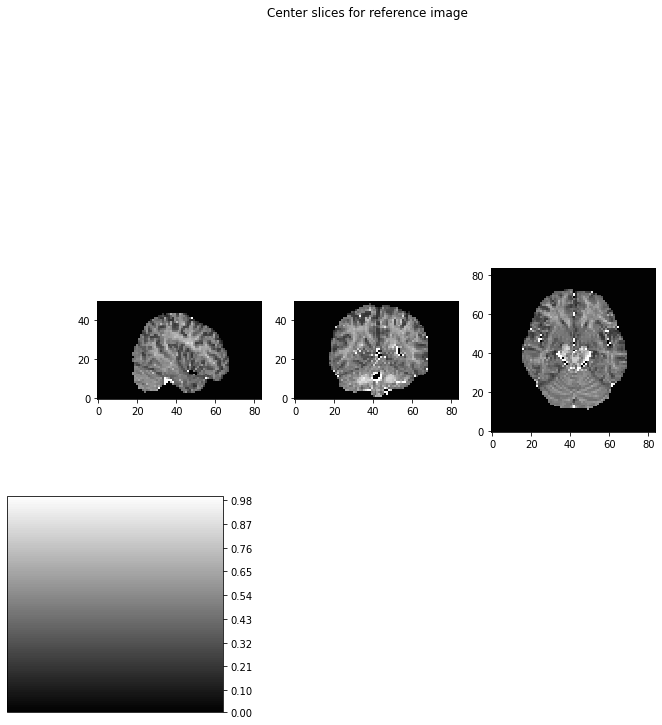

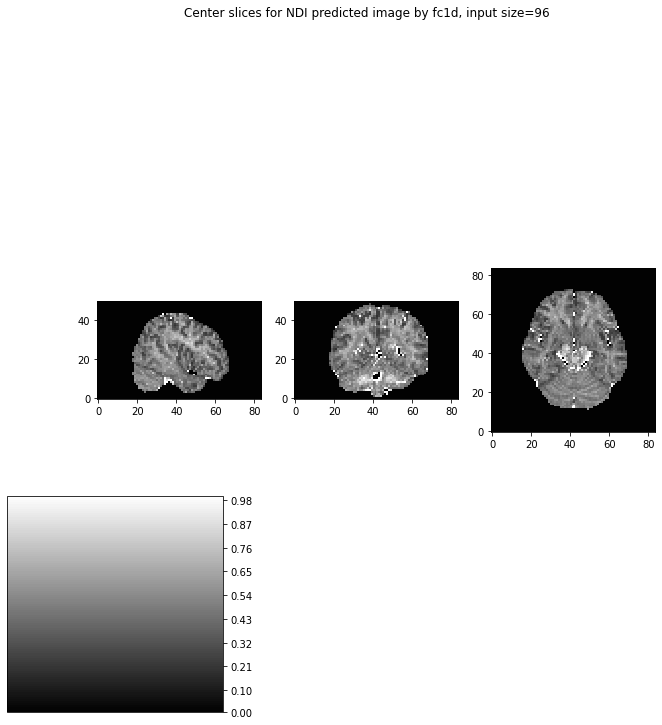

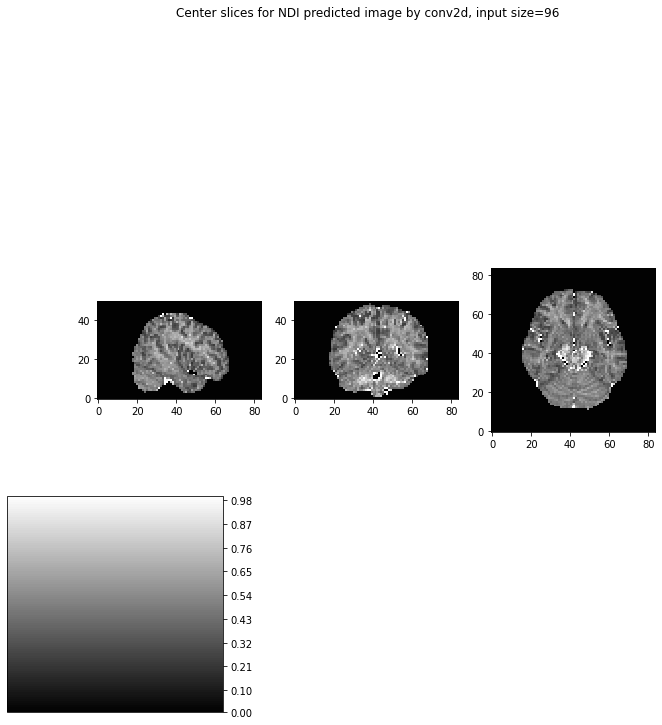

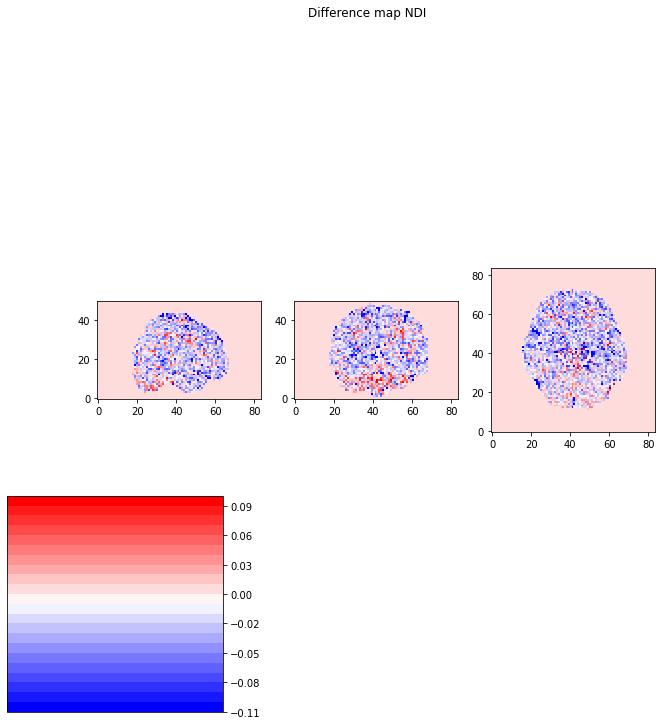

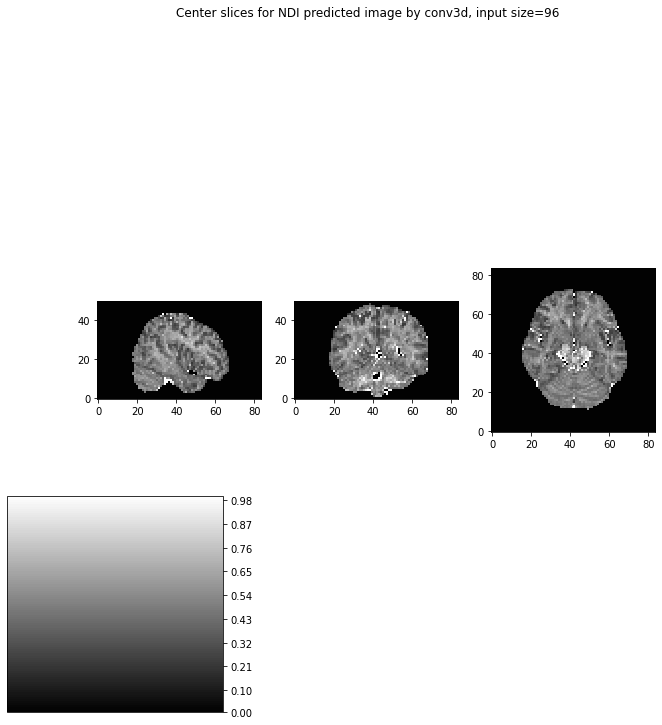

In [23]:
# load the reference img and pred img
visualise0(s01_NDI_img_data)
visualise1(s01_NDI_img_data, 96, 's01_still', 'fc1d',layer, s01_NDI_affine)
visualise1(s01_NDI_img_data, 96, 's01_still', 'conv2d',layer, s01_NDI_affine)
visualise1(s01_NDI_img_data, 96, 's01_still', 'conv3d',layer, s01_NDI_affine)

<strong>2 layer</strong>

In [12]:
layer = 2 

ANN

96
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_6 (Dropout)          (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_6 (ReLU)               (None, 1)                 0         
Total params: 37,351
Trainable params: 37,351
Non-trainable params: 0
______________________________________________

2022-04-07 15:25:00.800214: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:25:00.800342: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 15:25:01.008106: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:25:01.021875: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:25:01.022119: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:25:01.023235: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_25_01
2022-04-07 15:25:01.023705: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_25_01/vw.trace.json.gz
2022-04-07 15:25:01.023769: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:25:01.024595: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

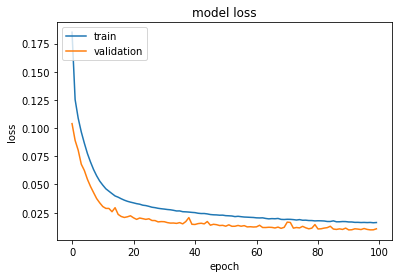

96-fc1d-patch_1-base_1-layer_2-label_NDIsynthetic
(84, 50, 96)
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_5 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_7 (Dropout)          (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_7 (ReLU)               (None, 1)                 0         
Total params: 37,351
Trainable params: 37,351
Non-traina

In [25]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu (ReLU)                 (None, 1, 1, 1)           0         
Total params: 152,551
Trainable params: 152,551
Non-trainable params: 0
_____________________________________________

2022-04-09 13:37:55.803078: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-04-09 13:37:55.832792: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-09 13:37:55.832893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.777GHz coreCount: 28 deviceMemorySize: 11.76GiB deviceMemoryBandwidth: 335.32GiB/s
2022-04-09 13:37:55.832919: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-09 13:37:55.849227: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-09 13:37:55.870820: I tensorflow/stream_executor/pl

The remained data has shape: (90846, 3, 3, 96)
(90846, 3, 3, 96)
(90846, 1, 1, 150)
(90846, 1, 1, 150)
(90846, 1, 1, 150)
(90846, 1, 1, 1)
(90846, 1, 1, 1)
Training start ...


2022-04-09 13:37:57.480758: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 13:37:57.481402: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1391] Profiler found 1 GPUs
2022-04-09 13:37:57.485798: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcupti.so.10.1
2022-04-09 13:37:57.488602: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


2022-04-09 13:37:57.987203: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 13:37:57.990975: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 13:37:57.991838: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 13:37:57.994701: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_13_37_57
2022-04-09 13:37:57.995428: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_13_37_57/vw.trace.json.gz
2022-04-09 13:37:57.995525: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 13:37:57.998171: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

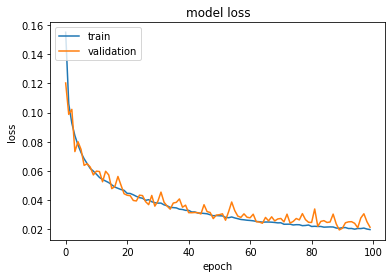

96-conv2d-patch_3-base_1-layer_2-label_NDIsynthetic
(84, 84, 96)
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_1 (Dropout)          (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 82, 82, 1)         151       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 82, 82, 1)         0         
Total params: 152,551
Trainable params: 152,551
Non-tra

/home/vw/anaconda3/envs/project/lib/python3.7/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)


In [13]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d (Conv3D)              (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 1, 1, 1, 1)        0         
Total params: 411,751
Trainable params: 411,751
Non-trainable params: 0
_____________________________________________

2022-04-09 13:39:37.765888: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 1883782656 exceeds 10% of free system memory.


(90846, 3, 3, 3, 96)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 1)
(90846, 1, 1, 1, 1)
Training start ...


2022-04-09 13:39:38.534412: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 13:39:38.534585: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 13:39:39.157572: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 13:39:39.175265: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 13:39:39.175488: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 13:39:39.176603: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_13_39_39
2022-04-09 13:39:39.177051: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_13_39_39/vw.trace.json.gz
2022-04-09 13:39:39.177109: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 13:39:39.177993: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

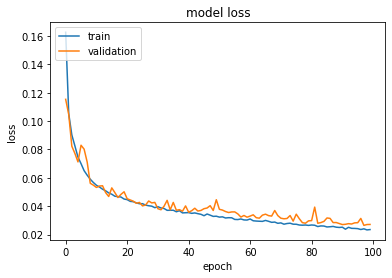

96-conv3d-patch_3-base_1-layer_2-label_NDIsynthetic
(84, 84, 50)
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_3 (Dropout)          (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 82, 82, 48, 1)     151       
_________________________________________________________________
re_lu_3 (ReLU)               (None, 82, 82, 48, 1)     0         
Total params: 411,751
Trainable params: 411,751
Non-tr

In [14]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for ndi is: 0.9850980425394016
3
conv2d
96input size the ssim score for ndi is: 0.981421294978663
3
conv3d
96input size the ssim score for ndi is: 0.9824026005291547


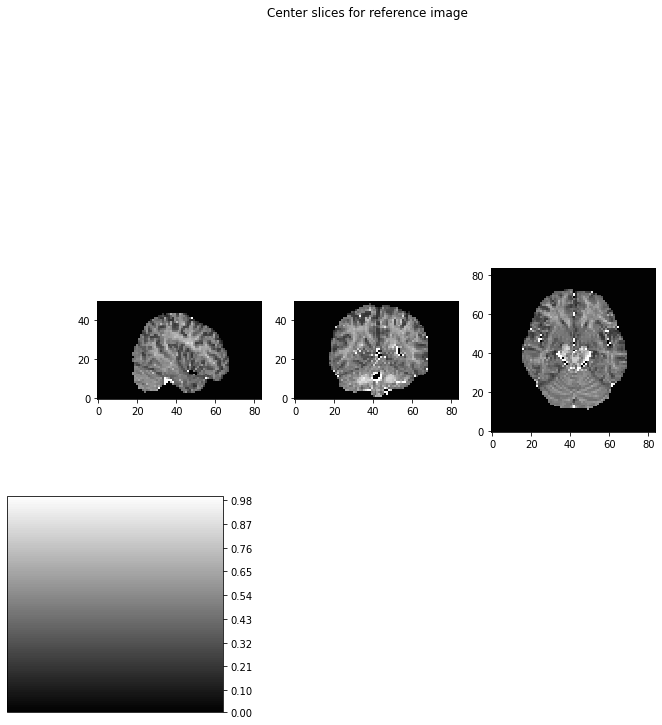

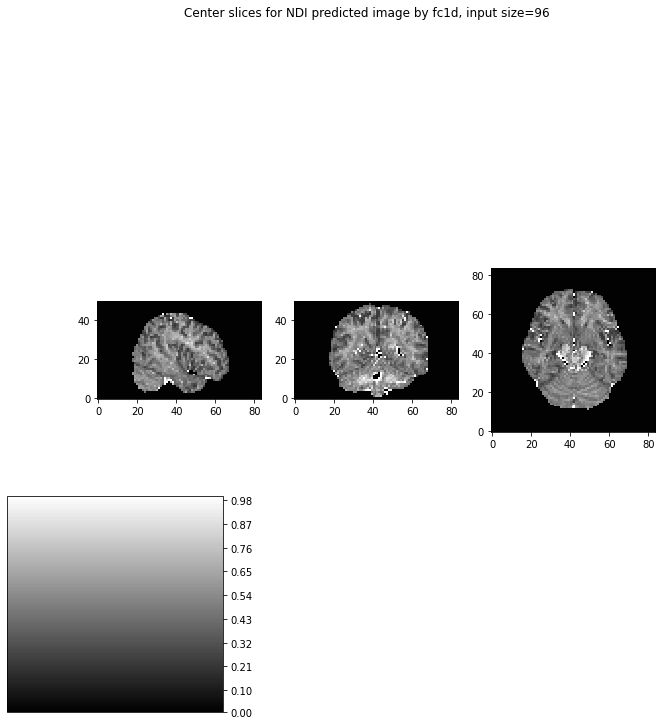

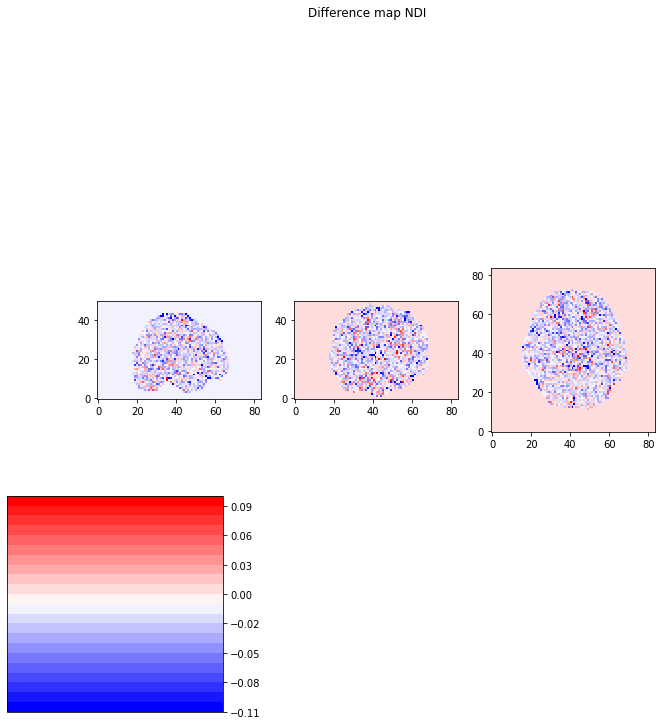

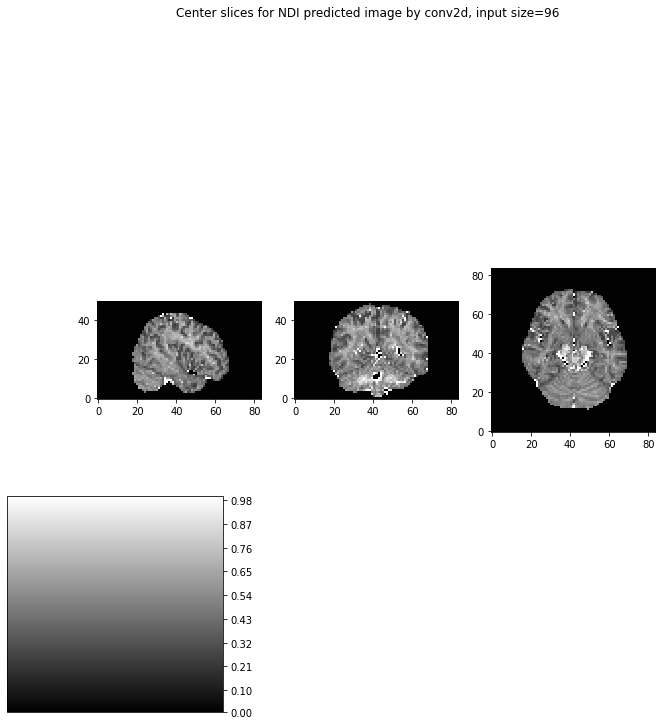

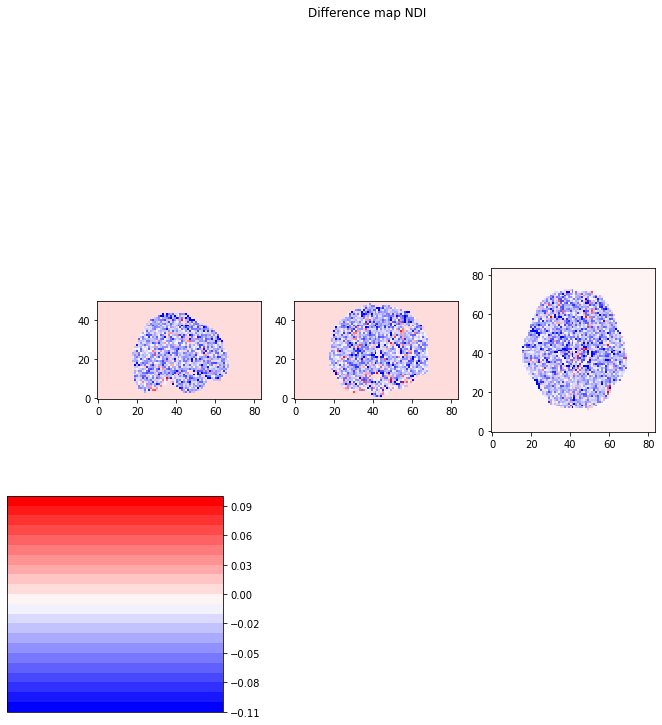

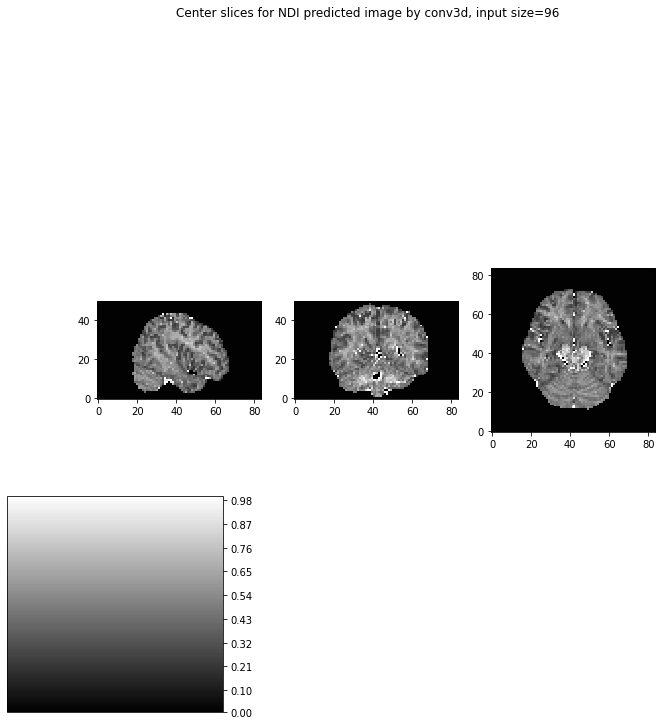

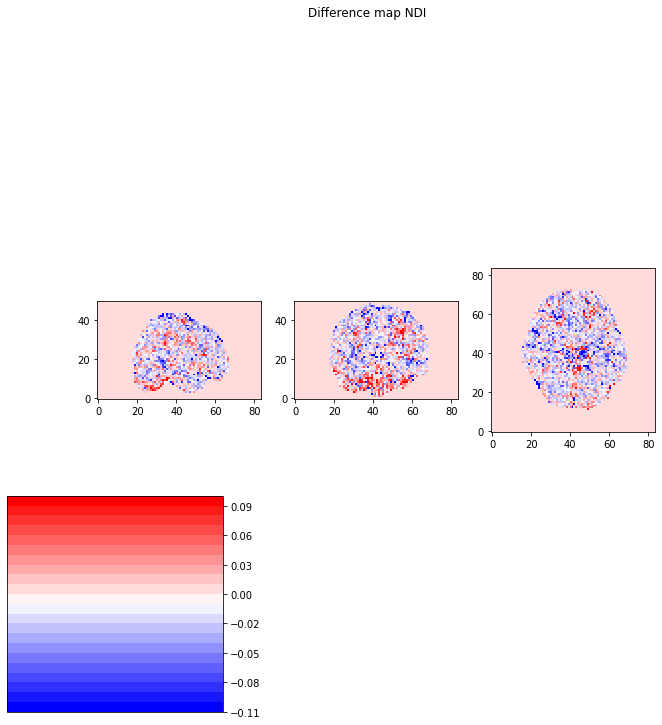

In [27]:
# load the reference img and pred img
visualise0(s01_NDI_img_data)
visualise1(s01_NDI_img_data, 96, 's01_still', 'fc1d',layer, s01_NDI_affine)
visualise1(s01_NDI_img_data, 96, 's01_still', 'conv2d',layer, s01_NDI_affine)
visualise1(s01_NDI_img_data, 96, 's01_still', 'conv3d',layer, s01_NDI_affine)

<strong>3 layer</strong>

In [28]:
layer = 3

ANN

96
Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_7 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_8 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_12 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_12 (ReLU)              (None, 1)            

2022-04-07 15:29:41.985010: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:29:41.985138: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 15:29:42.225045: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:29:42.240601: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:29:42.240846: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:29:42.241952: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_29_42
2022-04-07 15:29:42.242443: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_29_42/vw.trace.json.gz
2022-04-07 15:29:42.242507: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:29:42.243363: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

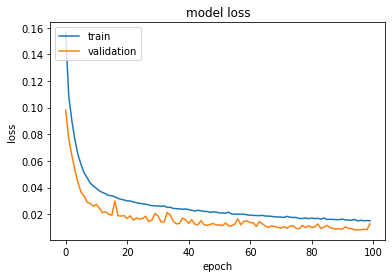

96-fc1d-patch_1-base_1-layer_3-label_NDIsynthetic
(84, 50, 96)
Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_10 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_11 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_13 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
________________________________________________________

In [30]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_14 (ReLU)              (None, 1, 1, 1)      

2022-04-07 15:30:26.412192: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:30:26.412304: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 15:30:26.866788: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:30:26.886026: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:30:26.886268: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:30:26.887362: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_30_26
2022-04-07 15:30:26.887845: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_30_26/vw.trace.json.gz
2022-04-07 15:30:26.887925: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:30:26.888752: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

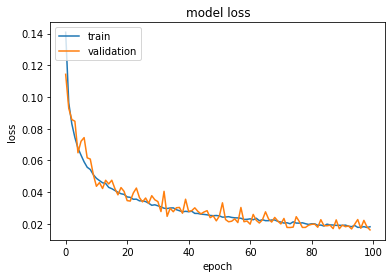

96-conv2d-patch_3-base_1-layer_3-label_NDIsynthetic
(84, 84, 96)
Model: "functional_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_15 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 82, 82, 1)         151       
______________________________________________________

In [31]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

In [29]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96
Model: "functional_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_55 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_56 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_14 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_57 (Conv3D)           (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_14 (ReLU)              (None, 1, 1, 1, 1)   

2022-04-08 08:59:49.768091: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 08:59:49.768272: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 08:59:50.430857: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 08:59:50.450949: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 08:59:50.451192: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 08:59:50.452321: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_08_59_50
2022-04-08 08:59:50.452821: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_08_59_50/vw.trace.json.gz
2022-04-08 08:59:50.452883: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 08:59:50.453773: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

96-conv3d-patch_3-base_1-layer_3-label_NDIsynthetic
(84, 84, 50)
Model: "functional_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_59 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_60 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_15 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_61 (Conv3D)           (None, 82, 82, 48, 1)     151       
______________________________________________________

1
fc1d
96input size the ssim score for ndi is: 0.9862575929714379
3
conv2d
96input size the ssim score for ndi is: 0.9846419050756351
3
conv3d
96input size the ssim score for ndi is: 0.9823976274154538


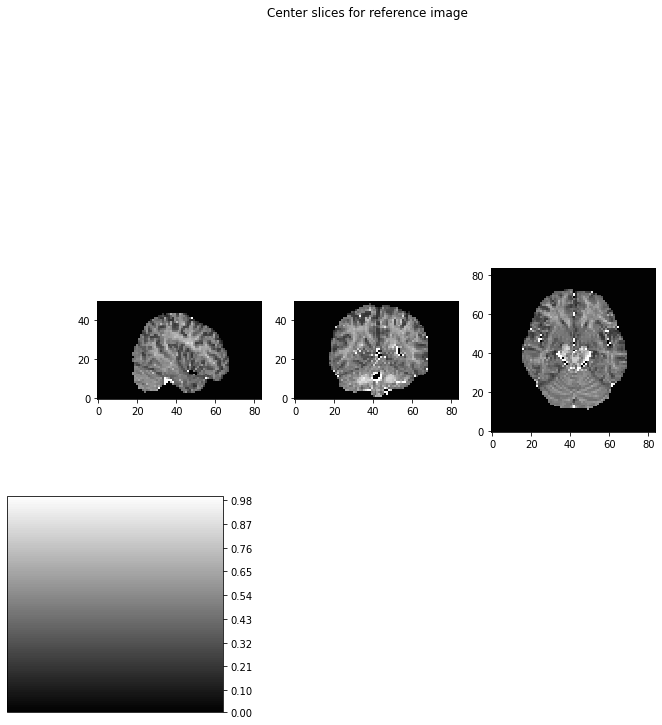

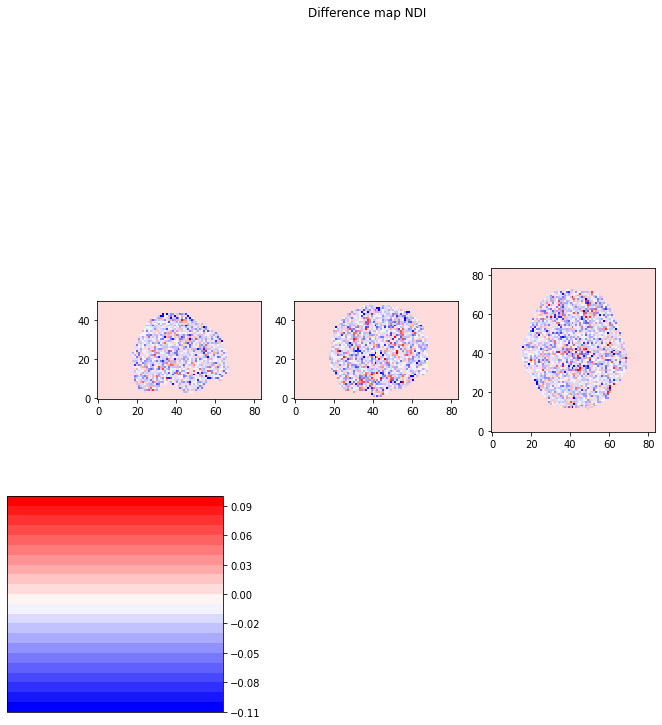

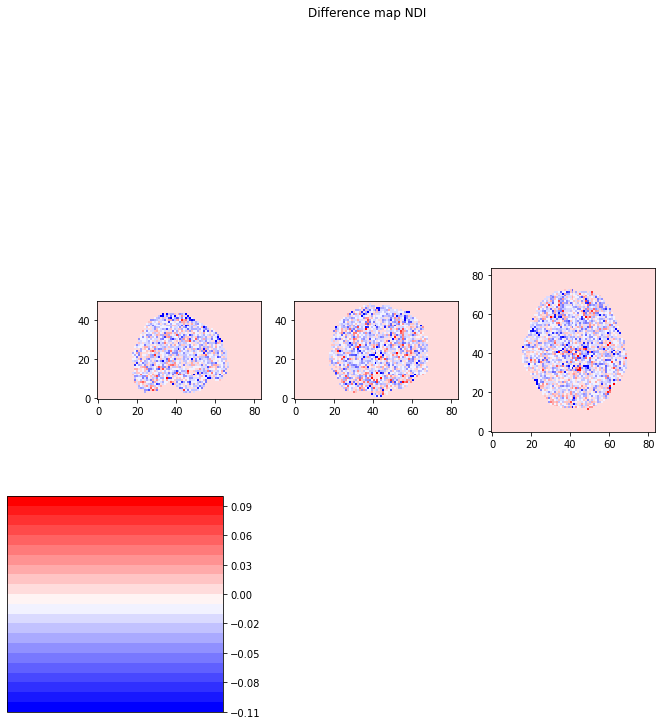

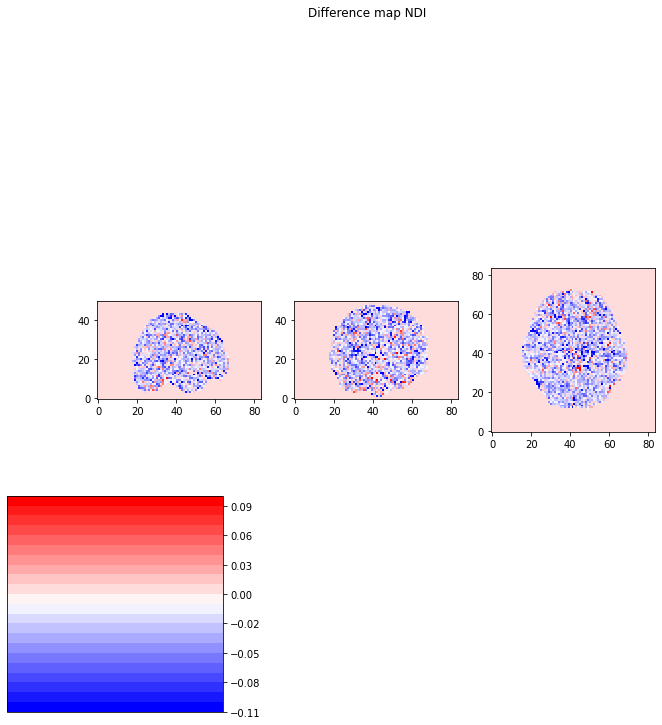

In [30]:
# load the reference img and pred img
visualise0(s01_NDI_img_data)
visualise1(s01_NDI_img_data, 96, 's01_still', 'fc1d',layer, s01_NDI_affine)
visualise1(s01_NDI_img_data, 96, 's01_still', 'conv2d',layer, s01_NDI_affine)
visualise1(s01_NDI_img_data, 96, 's01_still', 'conv3d',layer, s01_NDI_affine)

<strong>4 layer</strong>

In [15]:
layer = 4

ANN

96
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense (Dense)                (None, 150)               14550     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_4 (Dropout)          (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)            

2022-04-09 13:43:04.711011: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 13:43:04.711138: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 13:43:04.949847: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 13:43:04.965881: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 13:43:04.966135: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 13:43:04.967330: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_13_43_04
2022-04-09 13:43:04.967824: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_13_43_04/vw.trace.json.gz
2022-04-09 13:43:04.967890: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 13:43:04.968807: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

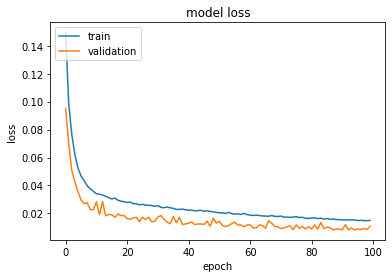

96-fc1d-patch_1-base_1-layer_4-label_NDIsynthetic
(84, 50, 96)
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_5 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_6 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_7 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_5 (Dropout)          (None, 150)               0         
________________________________________________________

In [16]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 1, 1, 1)      

2022-04-07 15:35:52.366927: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:35:52.367059: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 15:35:52.846357: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:35:52.868833: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:35:52.869102: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:35:52.870261: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_35_52
2022-04-07 15:35:52.870784: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_35_52/vw.trace.json.gz
2022-04-07 15:35:52.870855: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:35:52.871730: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

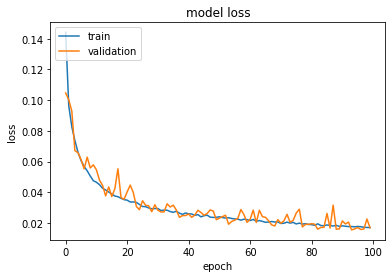

96-conv2d-patch_3-base_1-layer_4-label_NDIsynthetic
(84, 84, 96)
Model: "functional_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_21 (Dropout)         (None, 82, 82, 150)       0         
______________________________________________________

In [36]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 1, 1, 1, 1)    

2022-04-08 08:38:57.926166: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 1883782656 exceeds 10% of free system memory.


(90846, 3, 3, 3, 96)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 1)
(90846, 1, 1, 1, 1)
Training start ...


2022-04-08 08:38:58.719848: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 08:38:58.719953: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 08:38:59.370135: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 08:38:59.391171: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 08:38:59.391421: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 08:38:59.392563: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_08_38_59
2022-04-08 08:38:59.393086: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_08_38_59/vw.trace.json.gz
2022-04-08 08:38:59.393152: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 08:38:59.394100: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

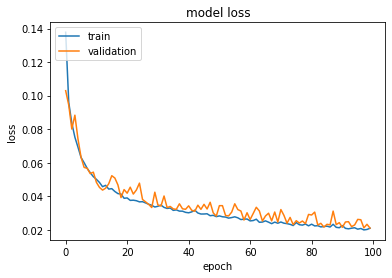

96-conv3d-patch_3-base_1-layer_4-label_NDIsynthetic
(84, 84, 50)
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_3 (Dropout)          (None, 82, 82, 48, 150)   0         
______________________________________________________

In [15]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for ndi is: 0.9835864321463057
3
conv2d
96input size the ssim score for ndi is: 0.9852389562705082
3
conv3d
96input size the ssim score for ndi is: 0.983213297634758


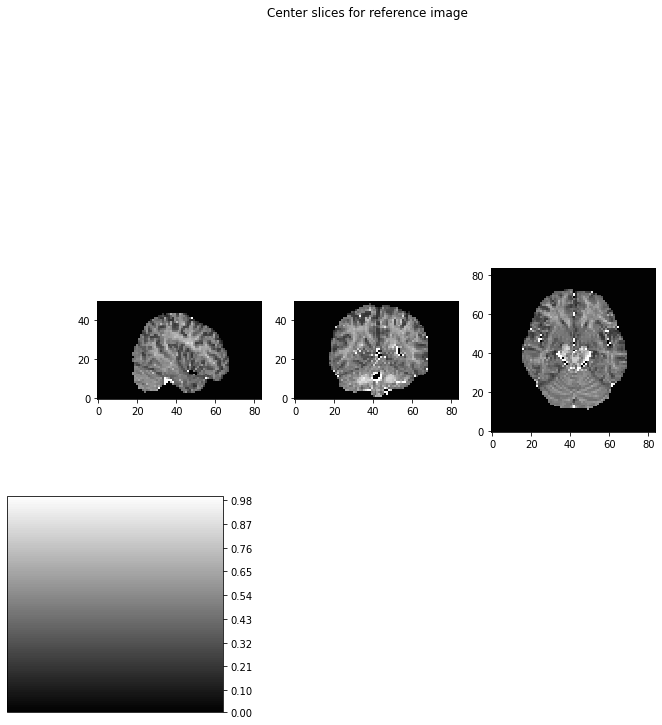

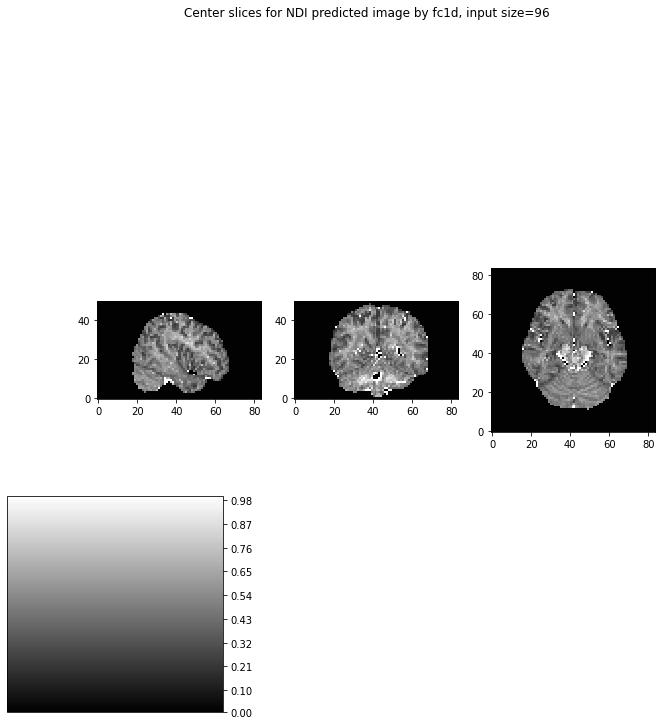

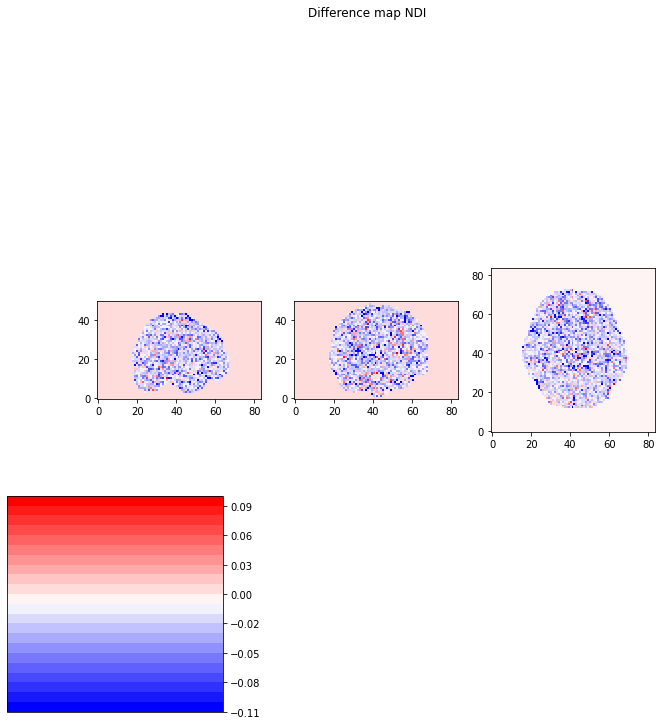

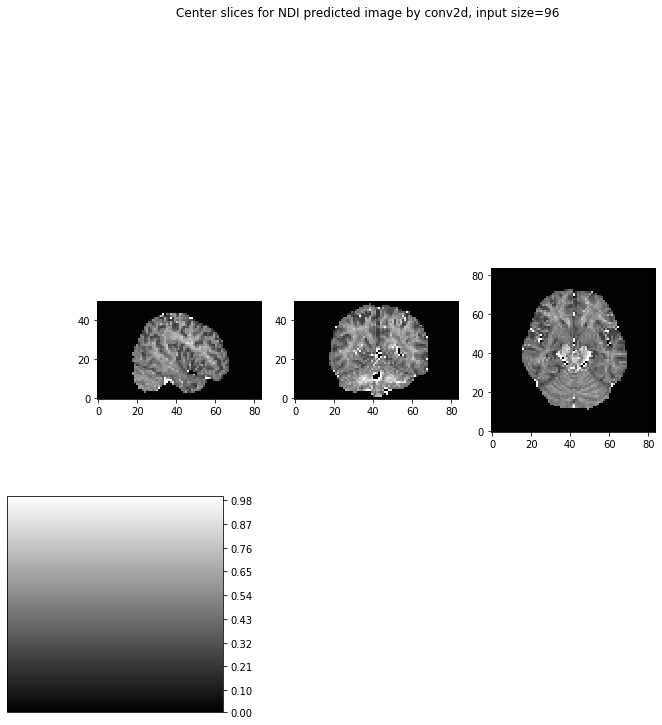

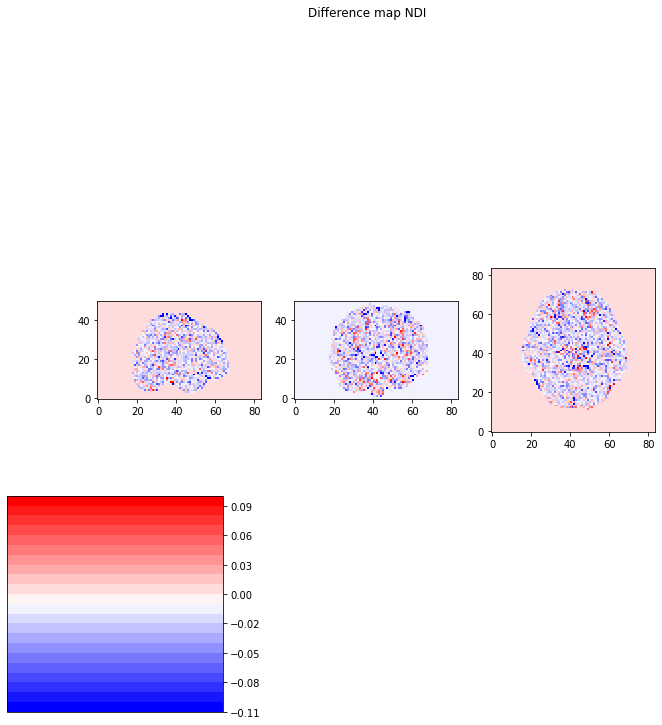

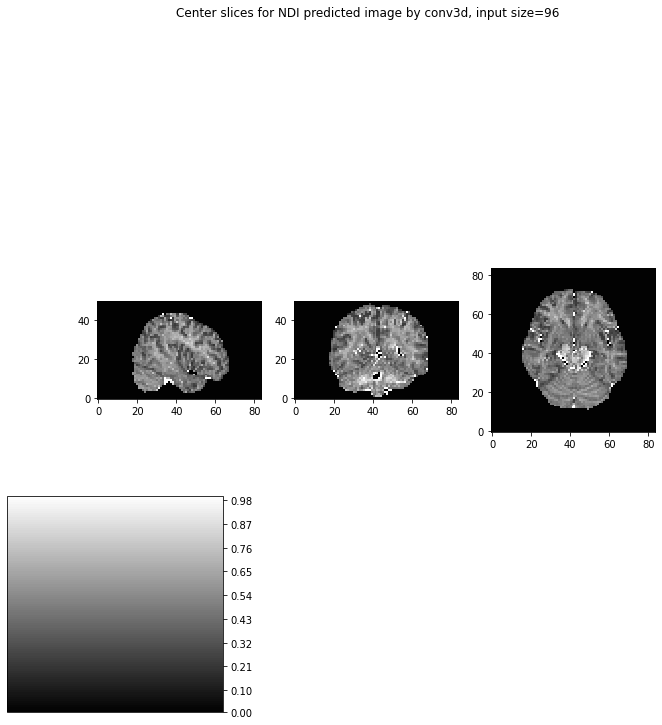

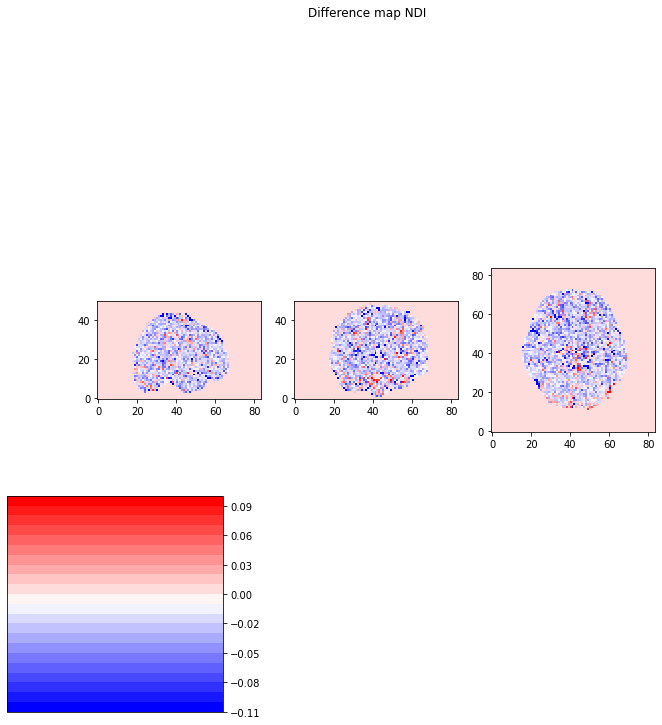

In [16]:
# load the reference img and pred img
visualise0(s01_NDI_img_data)
visualise1(s01_NDI_img_data, 96, 's01_still', 'fc1d',layer, s01_NDI_affine)
visualise1(s01_NDI_img_data, 96, 's01_still', 'conv2d',layer, s01_NDI_affine)
visualise1(s01_NDI_img_data, 96, 's01_still', 'conv3d',layer, s01_NDI_affine)

<strong>5 layer</strong>

In [17]:
layer = 5

ANN

96
Model: "functional_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_20 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_21 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_22 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_23 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_24 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_24 (Dropout)         (None, 150)          

2022-04-07 15:40:53.227355: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:40:53.227431: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 15:40:53.513684: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:40:53.533762: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:40:53.534038: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:40:53.535257: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_40_53
2022-04-07 15:40:53.535835: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_40_53/vw.trace.json.gz
2022-04-07 15:40:53.535913: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:40:53.536863: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

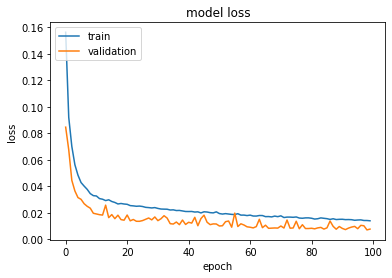

96-fc1d-patch_1-base_1-layer_5-label_NDIsynthetic
(84, 50, 96)
Model: "functional_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_25 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_26 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_27 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_28 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_29 (Dense)             (None, 150)               22650     
________________________________________________________

In [40]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

In [41]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96
Model: "functional_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_26 (Dropout)         (None, 1, 1, 150)    

2022-04-07 15:41:52.194123: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:41:52.194278: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 15:41:52.699921: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:41:52.724712: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:41:52.724976: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:41:52.726242: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_41_52
2022-04-07 15:41:52.726790: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_41_52/vw.trace.json.gz
2022-04-07 15:41:52.726879: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:41:52.727754: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

96-conv2d-patch_3-base_1-layer_5-label_NDIsynthetic
(84, 84, 96)
Model: "functional_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 82, 82, 150)       22650     
______________________________________________________

3D CNN

96
Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 1, 150) 

2022-04-08 08:42:48.893916: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 1883782656 exceeds 10% of free system memory.


(90846, 3, 3, 3, 96)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 1)
(90846, 1, 1, 1, 1)
Training start ...


2022-04-08 08:42:49.710199: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 08:42:49.710324: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 08:42:50.391422: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 08:42:50.414614: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 08:42:50.414881: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 08:42:50.416085: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_08_42_50
2022-04-08 08:42:50.416689: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_08_42_50/vw.trace.json.gz
2022-04-08 08:42:50.416767: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 08:42:50.417735: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

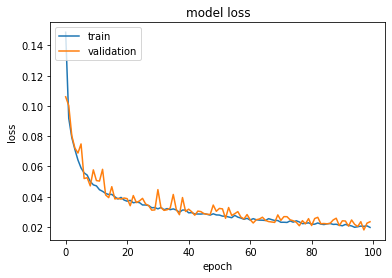

96-conv3d-patch_3-base_1-layer_5-label_NDIsynthetic
(84, 84, 50)
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 82, 82, 48, 150)   22650     
______________________________________________________

In [18]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for ndi is: 0.9839882400514797
3
conv2d
96input size the ssim score for ndi is: 0.9835848014442783
3
conv3d
96input size the ssim score for ndi is: 0.9800723340792695


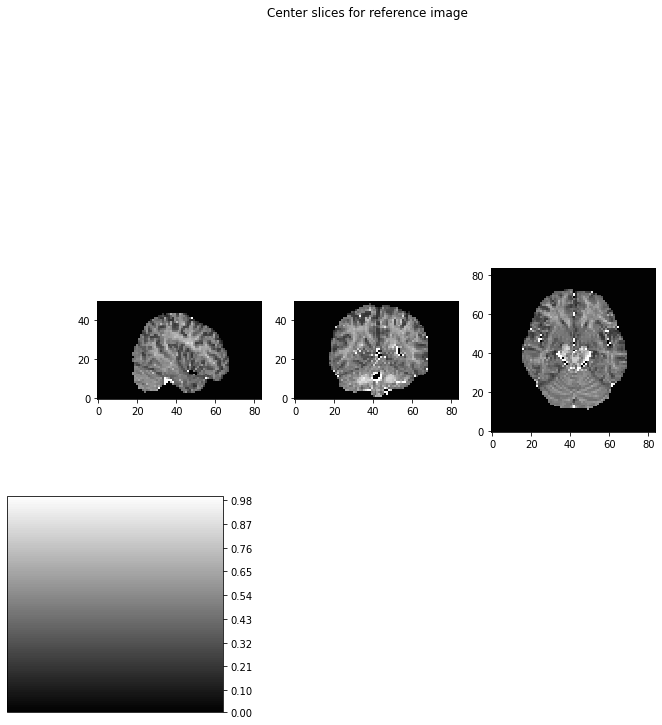

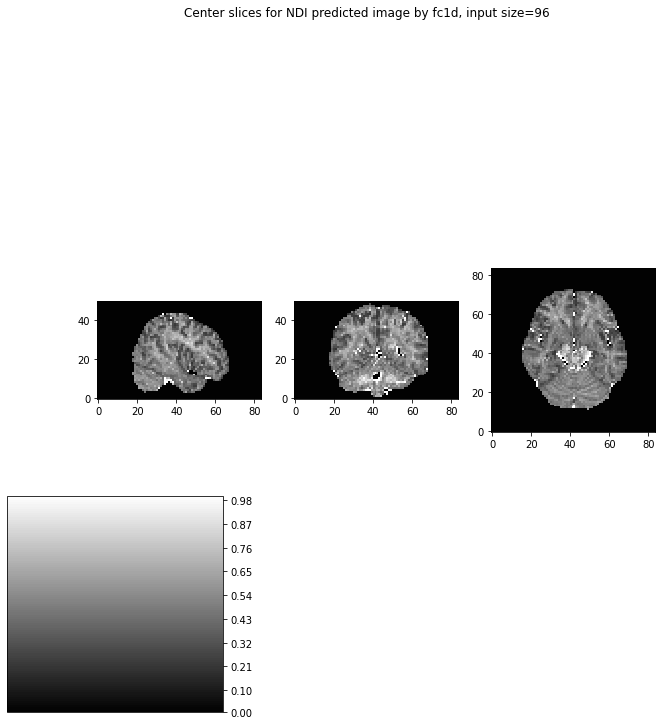

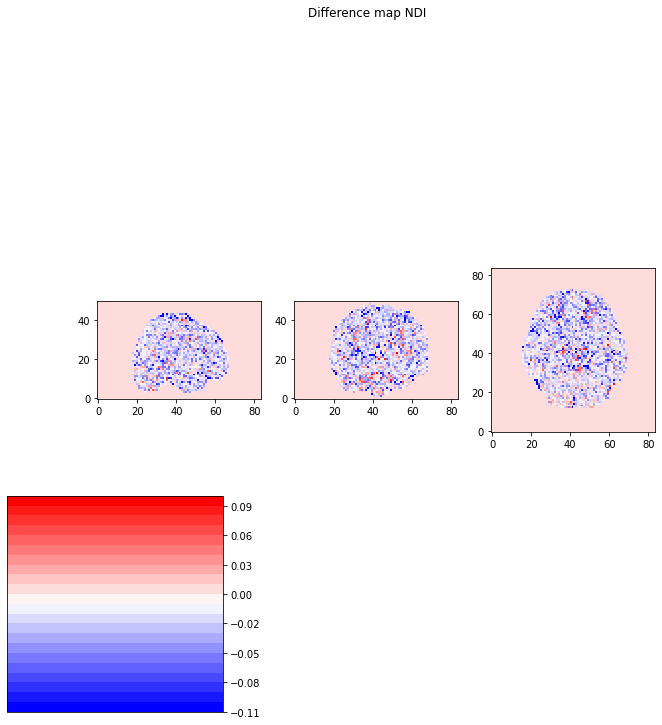

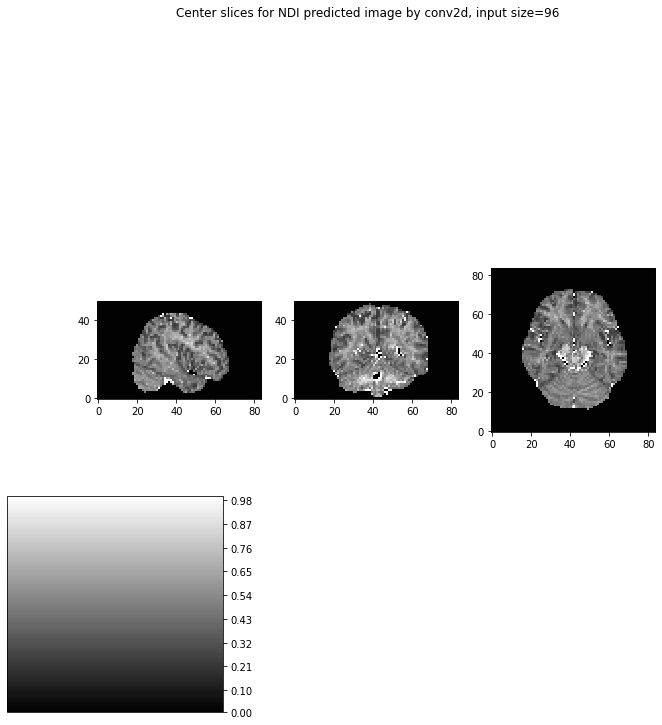

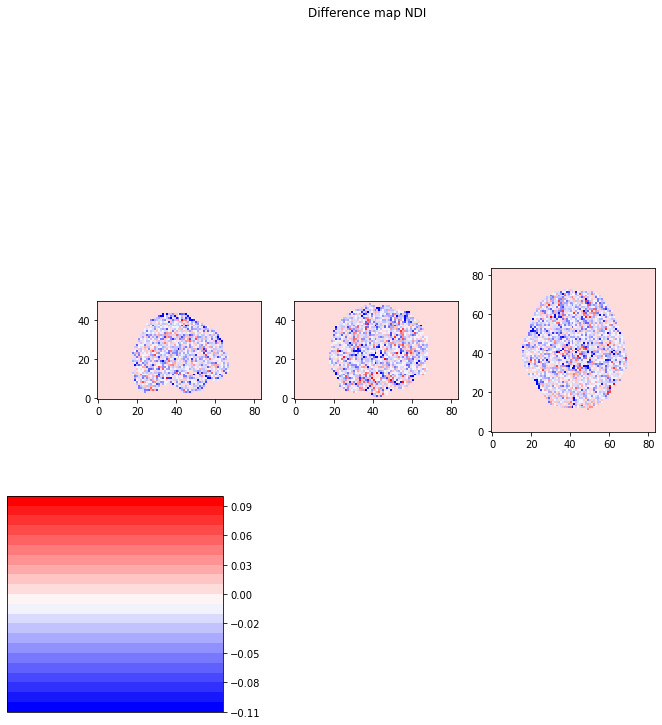

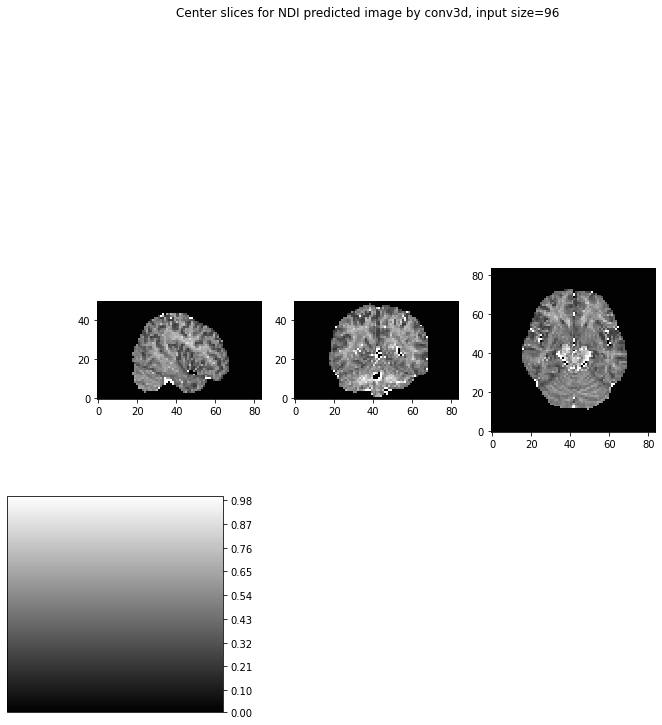

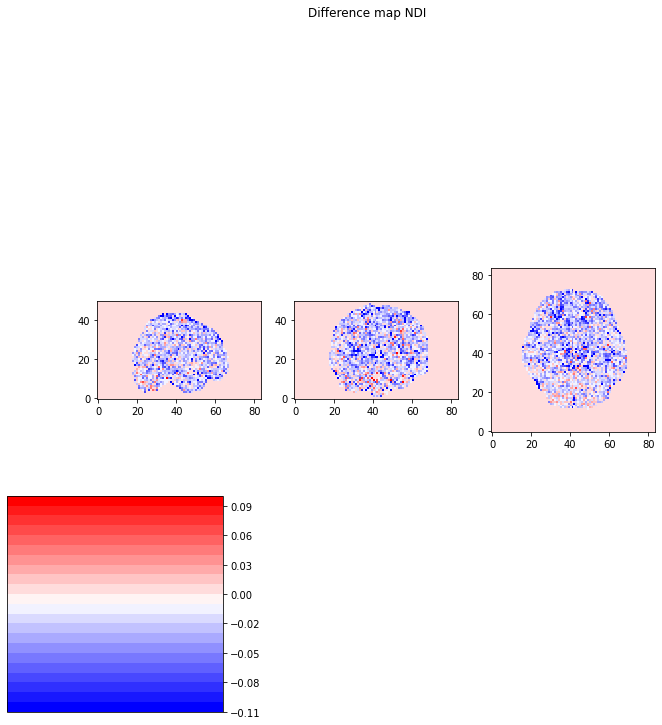

In [43]:
# load the reference img and pred img
visualise0(s01_NDI_img_data)
visualise1(s01_NDI_img_data, 96, 's01_still', 'fc1d',layer, s01_NDI_affine)
visualise1(s01_NDI_img_data, 96, 's01_still', 'conv2d',layer, s01_NDI_affine)
visualise1(s01_NDI_img_data, 96, 's01_still', 'conv3d',layer, s01_NDI_affine)

<strong>6 layer</strong>

In [19]:
layer = 6

ANN

96
Model: "functional_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_30 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_31 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_32 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_33 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_34 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_35 (Dense)             (None, 150)          

2022-04-07 15:47:24.024859: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:47:24.024984: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 15:47:24.350709: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:47:24.374142: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:47:24.374432: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:47:24.375660: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_47_24
2022-04-07 15:47:24.376253: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_47_24/vw.trace.json.gz
2022-04-07 15:47:24.376334: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:47:24.377298: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

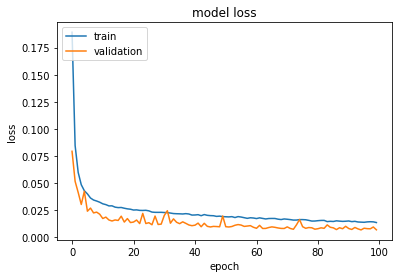

96-fc1d-patch_1-base_1-layer_6-label_NDIsynthetic
(84, 50, 96)
Model: "functional_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_36 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_37 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_38 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_39 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_40 (Dense)             (None, 150)               22650     
________________________________________________________

In [45]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 1, 1, 150)    

2022-04-07 15:48:32.650237: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:48:32.650318: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 15:48:33.201005: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:48:33.229145: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:48:33.229472: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:48:33.230717: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_48_33
2022-04-07 15:48:33.231310: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_48_33/vw.trace.json.gz
2022-04-07 15:48:33.231392: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:48:33.232354: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

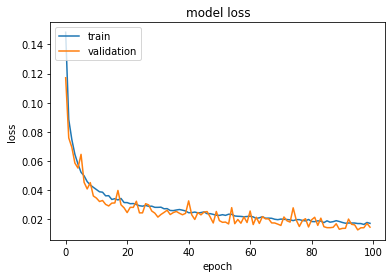

96-conv2d-patch_3-base_1-layer_6-label_NDIsynthetic
(84, 84, 96)
Model: "functional_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 82, 82, 150)       22650     
_____________________________________________________

In [46]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_31 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_35 (Conv3D)           (None, 1, 1, 1, 150) 

2022-04-08 08:46:33.016416: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 1883782656 exceeds 10% of free system memory.


(90846, 3, 3, 3, 96)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 1)
(90846, 1, 1, 1, 1)
Training start ...


2022-04-08 08:46:33.844065: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 08:46:33.844238: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-08 08:46:34.535485: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-08 08:46:34.561193: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-08 08:46:34.561503: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-08 08:46:34.562833: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_08_08_46_34
2022-04-08 08:46:34.563425: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_08_08_46_34/vw.trace.json.gz
2022-04-08 08:46:34.563503: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-08 08:46:34.564467: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

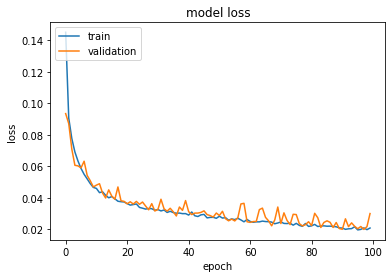

96-conv3d-patch_3-base_1-layer_6-label_NDIsynthetic
(84, 84, 50)
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_39 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_40 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 82, 82, 48, 150)   22650     
______________________________________________________

In [20]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type N'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type N'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for ndi is: 0.9843280046656492
3
conv2d
96input size the ssim score for ndi is: 0.9837550965218169
3
conv3d
96input size the ssim score for ndi is: 0.9840877426090957


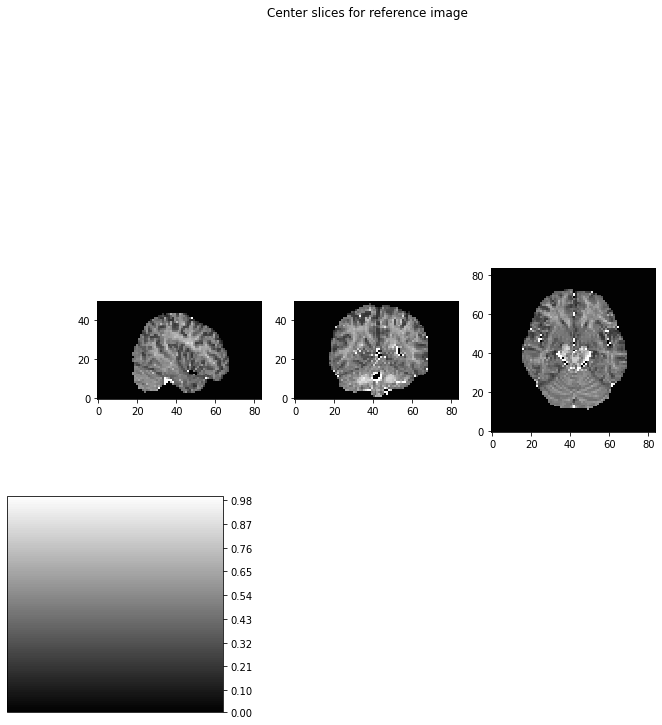

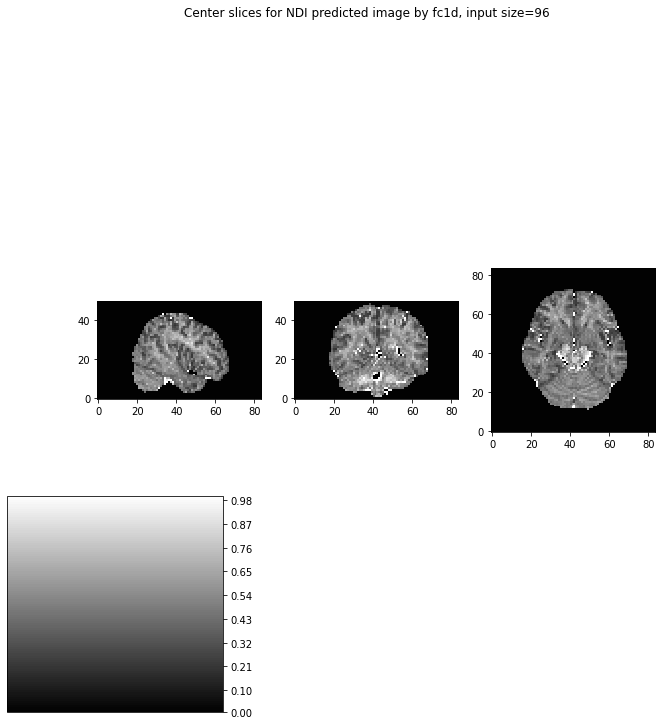

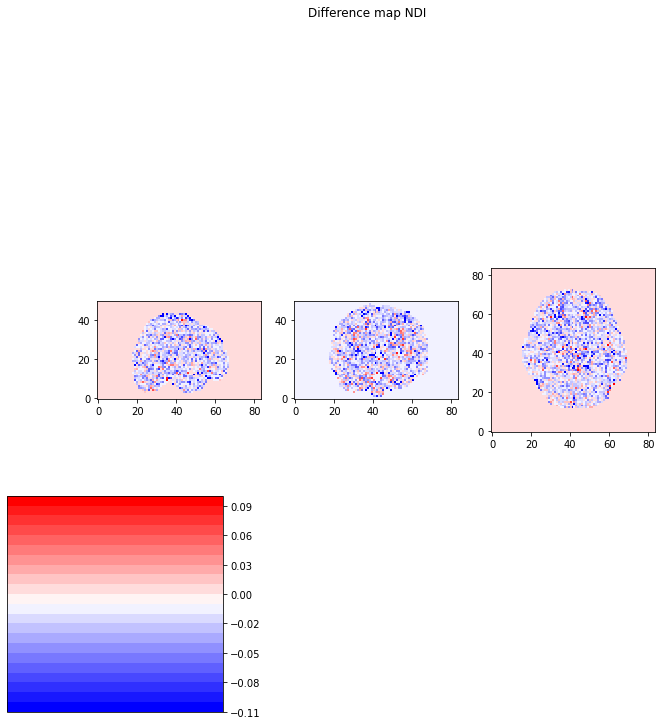

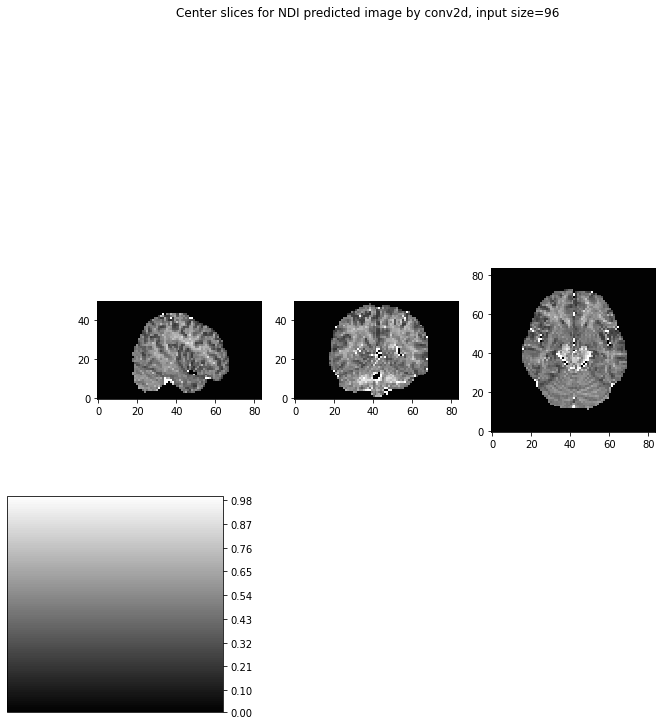

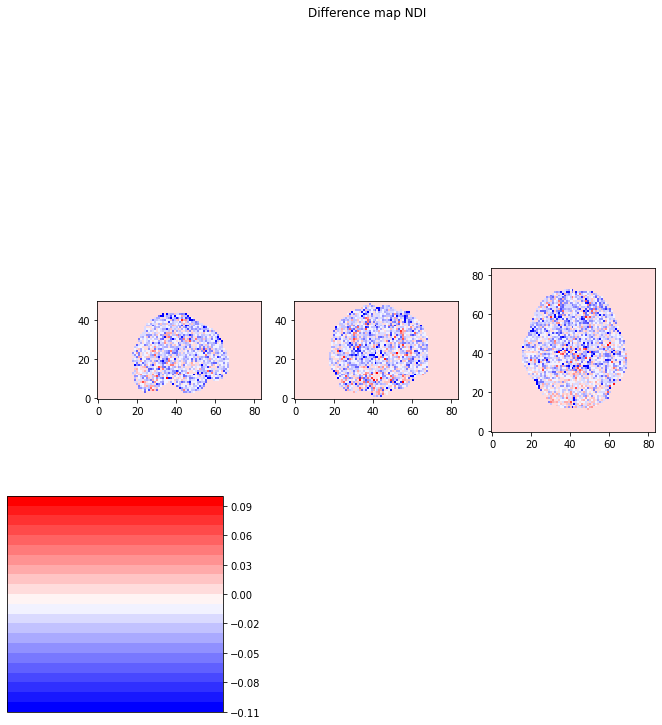

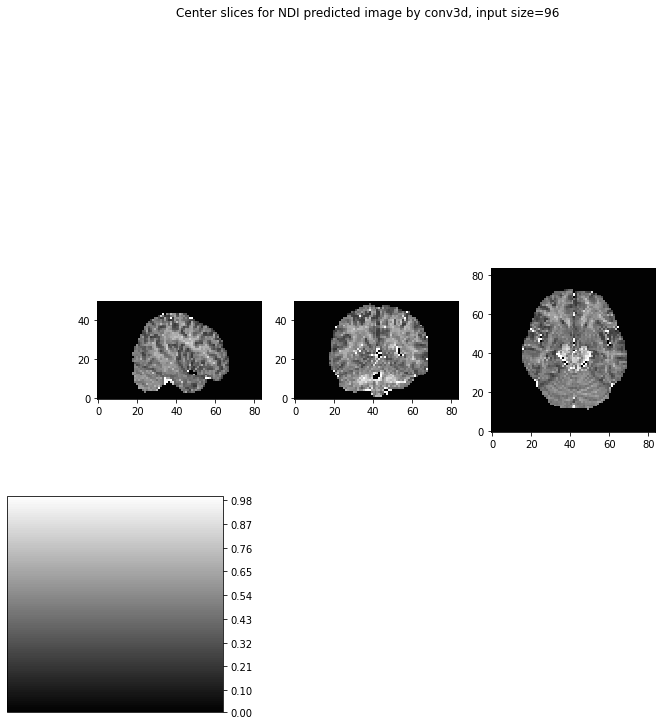

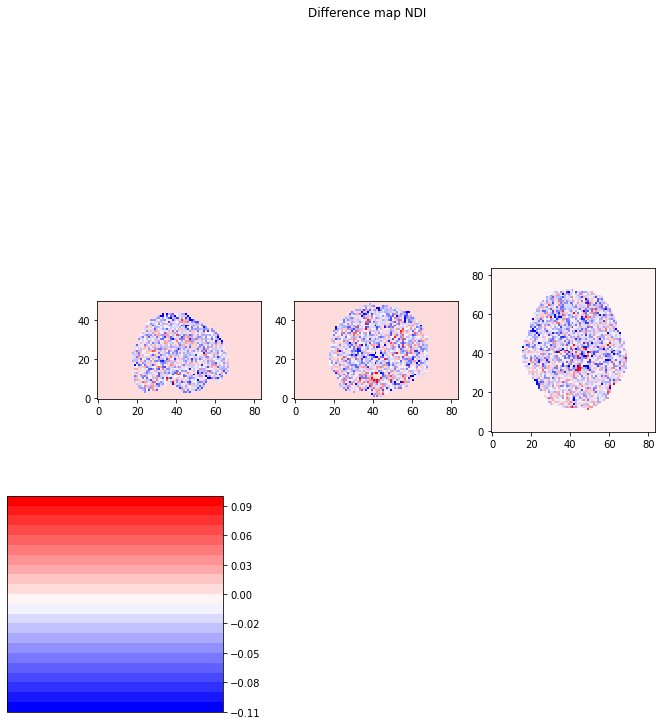

In [48]:
# load the reference img and pred img
visualise0(s01_NDI_img_data)
visualise1(s01_NDI_img_data, 96, 's01_still', 'fc1d',layer, s01_NDI_affine)
visualise1(s01_NDI_img_data, 96, 's01_still', 'conv2d',layer, s01_NDI_affine)
visualise1(s01_NDI_img_data, 96, 's01_still', 'conv3d',layer, s01_NDI_affine)

___

<strong>ODI</strong>


In [49]:
"""
Generate training dataset ODI for ANN.
"""
cmd = "--subjects s01_still s02_still --fc1d --label_type O"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (352800,)
data befor masking has shape: (352800, 96)
data after masking has shape: (81882, 96) the ratio of masked voxel is: 0.23209183673469388
training dataset has shape:(81882, 96)
(84, 84, 50, 1)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (81882, 1) the ratio of masked voxel is: 0.23209183673469388
training label has shape:(81882, 1)
Generating for s02_still ...
mask has shape: (352800,)
data befor masking has shape: (352800, 96)
data after masking has shape: (91401, 96) the ratio of masked voxel is: 0.2590731292517007
training dataset has shape:(91401, 96)
(84, 84, 50, 1)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (91401, 1) the ratio of masked voxel is: 0.2590731292517007
training label has shape:(91401, 1)


In [50]:
"""
Generate training dataset ODI for 2D CNN.
"""
cmd = "--subjects s01_still s02_still --conv2d --label_type O"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 48, 96)
label has shape: (82, 82, 48, 1)
(81634, 3, 3, 96)
saved patches has shape: (81634, 3, 3, 96)
(81634, 1, 1, 1)
svaed labels has shape: (81634, 1, 1, 1)
Generating for s02_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 48, 96)
label has shape: (82, 82, 48, 1)
(90846, 3, 3, 96)
saved patches has shape: (90846, 3, 3, 96)
(90846, 1, 1, 1)
svaed labels has shape: (90846, 1, 1, 1)


In [51]:
"""
Generate training dataset ODI for 3D CNN.
"""
cmd = "--subjects s01_still s02_still --conv3d --label_type O"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 50, 96)
label has shape: (82, 82, 48, 1)
(84, 84, 50, 96) (82, 82, 48)
(81634, 3, 3, 3, 96)
saved patches has shape: (81634, 2592)
(82, 82, 48, 1) (82, 82, 48)
(81634, 1, 1, 1, 1)
svaed labels has shape: (81634, 1, 1, 1, 1)
Generating for s02_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 50, 96)
label has shape: (82, 82, 48, 1)
(84, 84, 50, 96) (82, 82, 48)
(90846, 3, 3, 3, 96)
saved patches has shape: (90846, 2592)
(82, 82, 48, 1) (82, 82, 48)
(90846, 1, 1, 1, 1)
svaed labels has shape: (90846, 1, 1, 1, 1)


<strong>1 layer</strong>

In [52]:
layer = 1

ANN

96
Model: "functional_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_42 (Dense)             (None, 150)               14550     
_________________________________________________________________
dropout_36 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_36 (ReLU)              (None, 1)                 0         
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
['O']
The remained data has shape: (91401, 96)
(91401, 96)
(91401, 150)
(91401, 150)
(91401, 1)
(91401, 1)
Trai

2022-04-07 15:55:14.612364: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:55:14.612458: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 15:55:14.871334: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:55:14.892921: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:55:14.893170: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:55:14.894497: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_55_14
2022-04-07 15:55:14.894958: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_55_14/vw.trace.json.gz
2022-04-07 15:55:14.895056: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:55:14.895871: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

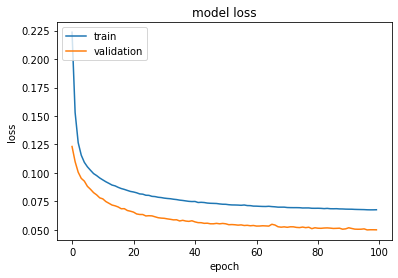

96-fc1d-patch_1-base_1-layer_1-label_ODIsynthetic
(84, 50, 96)
Model: "functional_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_43 (Dense)             (None, 150)               14550     
_________________________________________________________________
dropout_37 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_37 (ReLU)              (None, 1)                 0         
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
testing data shape: (84, 84, 50, 96)
prediction has

In [53]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
dropout_38 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_38 (ReLU)              (None, 1, 1, 1)           0         
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
['O']
The remained data has shape: (90846, 3, 3, 96)
(90846, 3, 3, 96)
(90846, 1, 1, 150)
(90846, 1, 1, 150)


2022-04-07 15:55:43.689635: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:55:43.689770: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 15:55:44.151837: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:55:44.167411: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:55:44.167625: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:55:44.168602: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_55_44
2022-04-07 15:55:44.169022: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_55_44/vw.trace.json.gz
2022-04-07 15:55:44.169082: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:55:44.169854: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

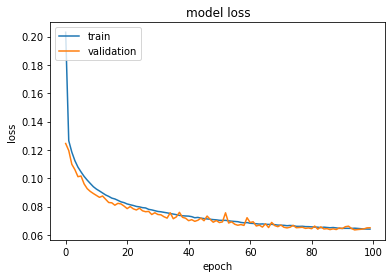

96-conv2d-patch_3-base_1-layer_1-label_ODIsynthetic
(84, 84, 96)
Model: "functional_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
dropout_39 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 82, 82, 1)         151       
_________________________________________________________________
re_lu_39 (ReLU)              (None, 82, 82, 1)         0         
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
testing data shape: (50, 84, 84, 96)
prediction

In [54]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
dropout_40 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_55 (Conv3D)           (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_40 (ReLU)              (None, 1, 1, 1, 1)        0         
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
['O']
The remained data has shape: (90846, 3, 3, 3, 96)
(90846, 3, 3, 3, 96)
(90846, 1, 1, 1, 150)
(90846, 1,

2022-04-07 15:56:41.641478: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:56:41.641641: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 15:56:42.495003: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:56:42.515454: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:56:42.515727: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:56:42.516838: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_56_42
2022-04-07 15:56:42.517286: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_56_42/vw.trace.json.gz
2022-04-07 15:56:42.517348: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:56:42.518159: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

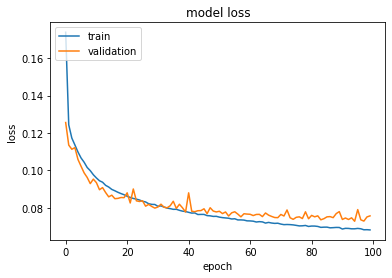

96-conv3d-patch_3-base_1-layer_1-label_ODIsynthetic
(84, 84, 50)
Model: "functional_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_56 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
dropout_41 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_57 (Conv3D)           (None, 82, 82, 48, 1)     151       
_________________________________________________________________
re_lu_41 (ReLU)              (None, 82, 82, 48, 1)     0         
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
testing data shape: (1, 84, 84, 50, 96)
predict

In [55]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for odi is: 0.9590267845513475
3
conv2d
96input size the ssim score for odi is: 0.9552738653027237
3
conv3d
96input size the ssim score for odi is: 0.9498712690468513


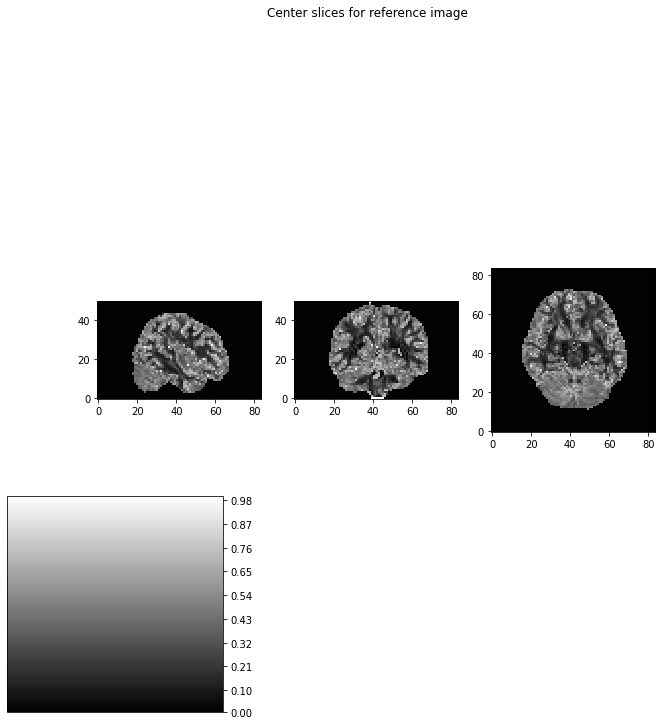

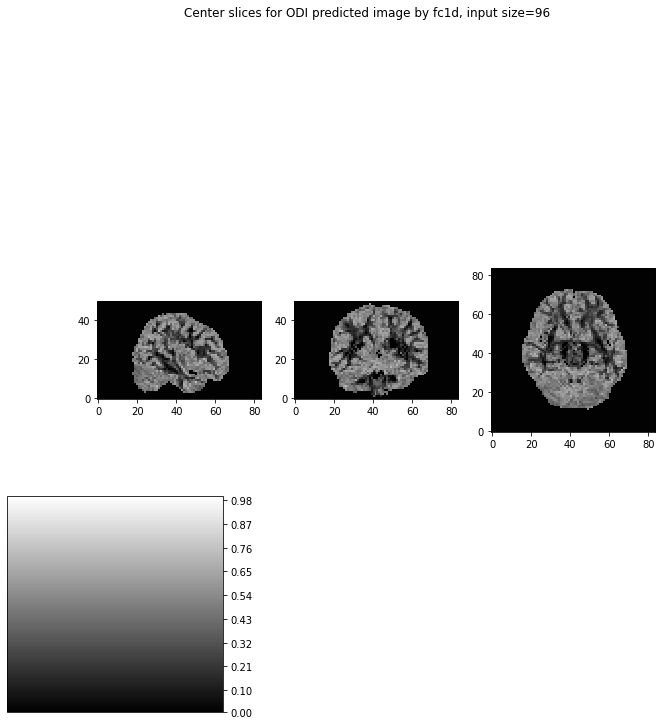

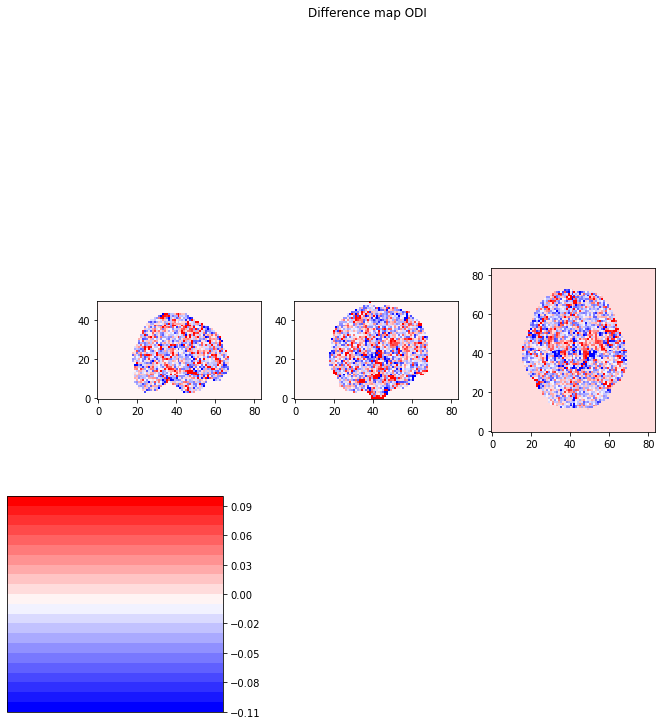

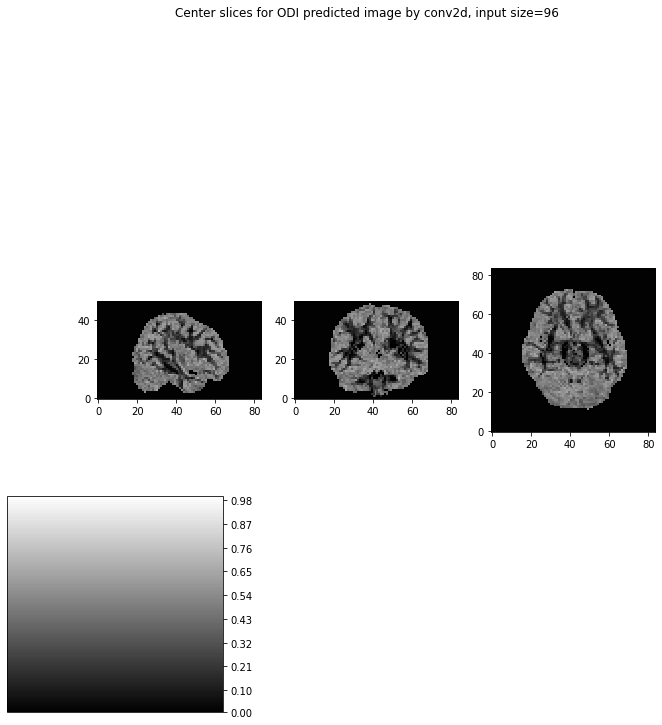

In [56]:
# load the reference img and pred img
visualise0(s01_ODI_img_data)
visualise2(s01_ODI_img_data, 96, 's01_still', 'fc1d',layer, s01_ODI_affine)
visualise2(s01_ODI_img_data, 96, 's01_still', 'conv2d',layer, s01_ODI_affine)
visualise2(s01_ODI_img_data, 96, 's01_still', 'conv3d',layer, s01_ODI_affine)

<strong>2 layer</strong>

In [57]:
layer = 2 

ANN

96
Model: "functional_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_44 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_45 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_42 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_42 (ReLU)              (None, 1)                 0         
Total params: 37,351
Trainable params: 37,351
Non-trainable params: 0
_____________________________________________

2022-04-07 15:59:20.413364: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:59:20.413435: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 15:59:20.670045: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:59:20.684099: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:59:20.684337: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:59:20.685451: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_59_20
2022-04-07 15:59:20.685911: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_59_20/vw.trace.json.gz
2022-04-07 15:59:20.685977: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:59:20.686747: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

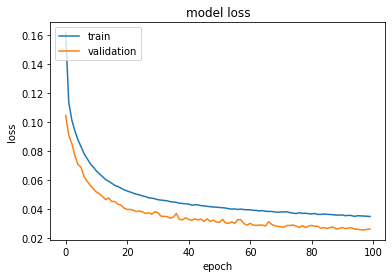

96-fc1d-patch_1-base_1-layer_2-label_ODIsynthetic
(84, 50, 96)
Model: "functional_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_46 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_47 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_43 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_43 (ReLU)              (None, 1)                 0         
Total params: 37,351
Trainable params: 37,351
Non-train

In [58]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

In [59]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96
Model: "functional_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_44 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_44 (ReLU)              (None, 1, 1, 1)           0         
Total params: 152,551
Trainable params: 152,551
Non-trainable params: 0
___________________________________________

2022-04-07 15:59:57.576564: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:59:57.576703: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 15:59:58.067785: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 15:59:58.088053: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 15:59:58.088300: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 15:59:58.089484: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_15_59_58
2022-04-07 15:59:58.090023: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_15_59_58/vw.trace.json.gz
2022-04-07 15:59:58.090108: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 15:59:58.091053: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

96-conv2d-patch_3-base_1-layer_2-label_ODIsynthetic
(84, 84, 96)
Model: "functional_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_45 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 82, 82, 1)         151       
_________________________________________________________________
re_lu_45 (ReLU)              (None, 82, 82, 1)         0         
Total params: 152,551
Trainable params: 152,551
Non-t

3D CNN

96
Model: "functional_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_59 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_46 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_60 (Conv3D)           (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_46 (ReLU)              (None, 1, 1, 1, 1)        0         
Total params: 411,751
Trainable params: 411,751
Non-trainable params: 0
___________________________________________

2022-04-07 16:01:11.253104: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:01:11.253223: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 16:01:11.957261: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:01:11.975751: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 16:01:11.976001: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 16:01:11.977044: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_16_01_11
2022-04-07 16:01:11.977500: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_16_01_11/vw.trace.json.gz
2022-04-07 16:01:11.977563: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 16:01:11.978379: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

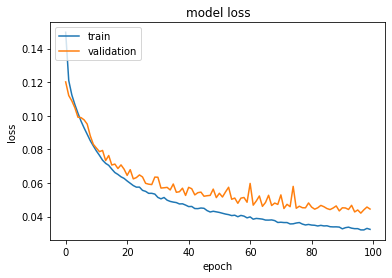

96-conv3d-patch_3-base_1-layer_2-label_ODIsynthetic
(84, 84, 50)
Model: "functional_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_61 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_47 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_63 (Conv3D)           (None, 82, 82, 48, 1)     151       
_________________________________________________________________
re_lu_47 (ReLU)              (None, 82, 82, 48, 1)     0         
Total params: 411,751
Trainable params: 411,751
Non-t

In [60]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for odi is: 0.9638440577745917
3
conv2d
96input size the ssim score for odi is: 0.9631525408710699
3
conv3d
96input size the ssim score for odi is: 0.9614356161244839


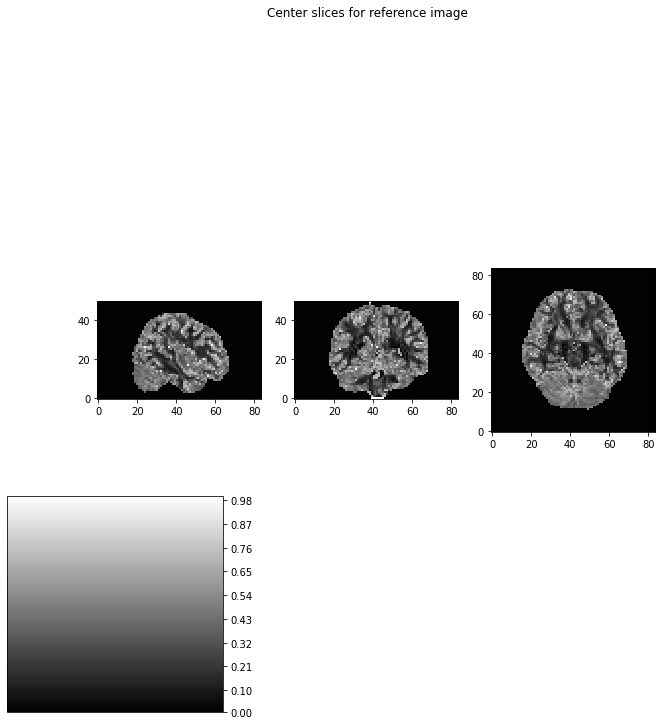

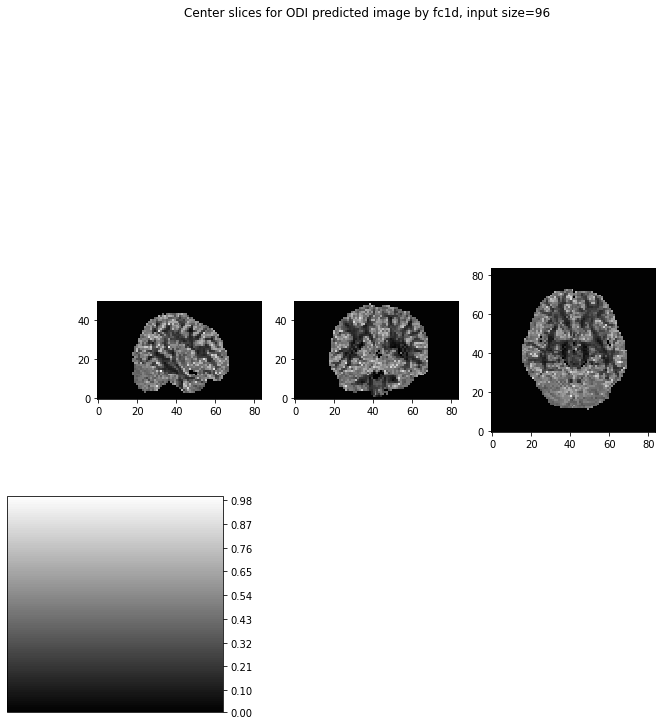

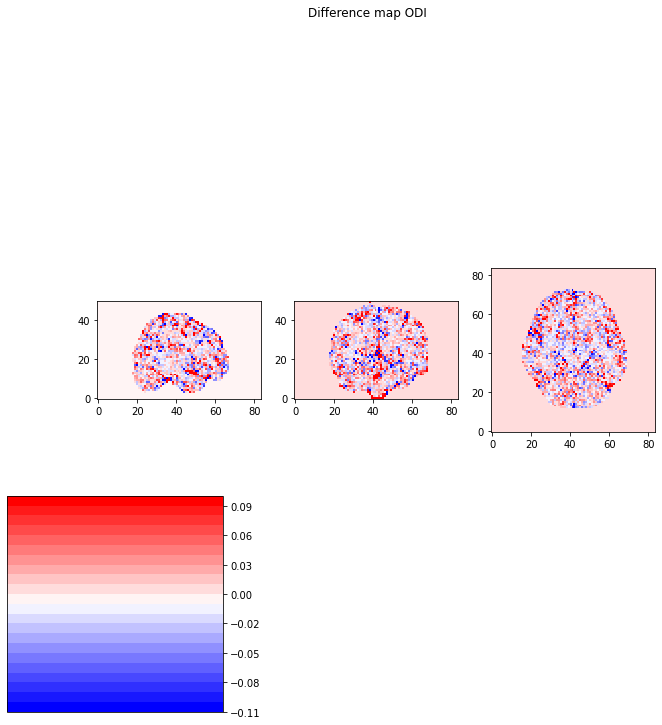

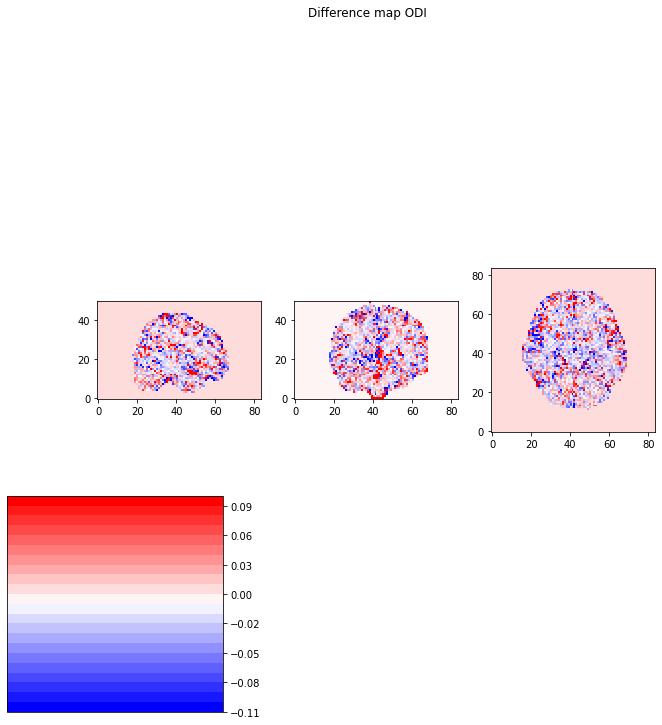

In [61]:
# load the reference img and pred img
visualise0(s01_ODI_img_data)
visualise2(s01_ODI_img_data, 96, 's01_still', 'fc1d',layer, s01_ODI_affine)
visualise2(s01_ODI_img_data, 96, 's01_still', 'conv2d',layer, s01_ODI_affine)
visualise2(s01_ODI_img_data, 96, 's01_still', 'conv3d',layer, s01_ODI_affine)

<strong>3 layer</strong>

In [62]:
layer = 3

ANN

96
Model: "functional_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_48 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_49 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_50 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_48 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_48 (ReLU)              (None, 1)           

2022-04-07 16:04:04.116043: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:04:04.116120: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 16:04:04.425142: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:04:04.443077: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 16:04:04.443318: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 16:04:04.444422: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_16_04_04
2022-04-07 16:04:04.444909: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_16_04_04/vw.trace.json.gz
2022-04-07 16:04:04.444986: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 16:04:04.445875: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

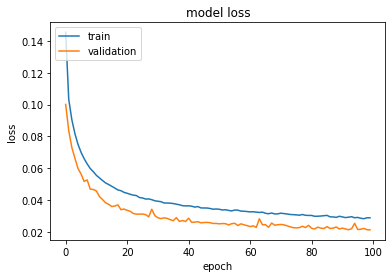

96-fc1d-patch_1-base_1-layer_3-label_ODIsynthetic
(84, 50, 96)
Model: "functional_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_51 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_52 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_53 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_49 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_______________________________________________________

In [63]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_50 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_50 (ReLU)              (None, 1, 1, 1)     

2022-04-07 16:04:48.048264: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:04:48.048391: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 16:04:48.557160: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:04:48.577659: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 16:04:48.577895: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 16:04:48.579027: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_16_04_48
2022-04-07 16:04:48.579505: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_16_04_48/vw.trace.json.gz
2022-04-07 16:04:48.579577: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 16:04:48.580407: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

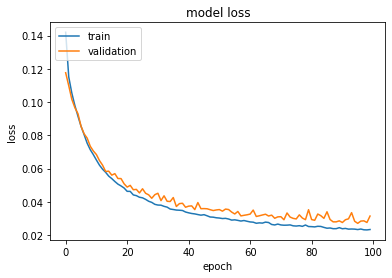

96-conv2d-patch_3-base_1-layer_3-label_ODIsynthetic
(84, 84, 96)
Model: "functional_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_51 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 82, 82, 1)         151       
_____________________________________________________

In [64]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_64 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_65 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_52 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_67 (Conv3D)           (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_52 (ReLU)              (None, 1, 1, 1, 1)  

2022-04-07 16:06:15.687073: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:06:15.687150: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 16:06:16.410596: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:06:16.431180: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 16:06:16.431420: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 16:06:16.432477: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_16_06_16
2022-04-07 16:06:16.432949: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_16_06_16/vw.trace.json.gz
2022-04-07 16:06:16.433011: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 16:06:16.433890: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

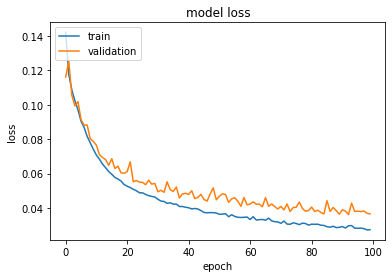

96-conv3d-patch_3-base_1-layer_3-label_ODIsynthetic
(84, 84, 50)
Model: "functional_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_68 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_69 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_53 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_71 (Conv3D)           (None, 82, 82, 48, 1)     151       
_____________________________________________________

In [65]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for odi is: 0.9640309006690313
3
conv2d
96input size the ssim score for odi is: 0.9632216494420931
3
conv3d
96input size the ssim score for odi is: 0.963497044640489


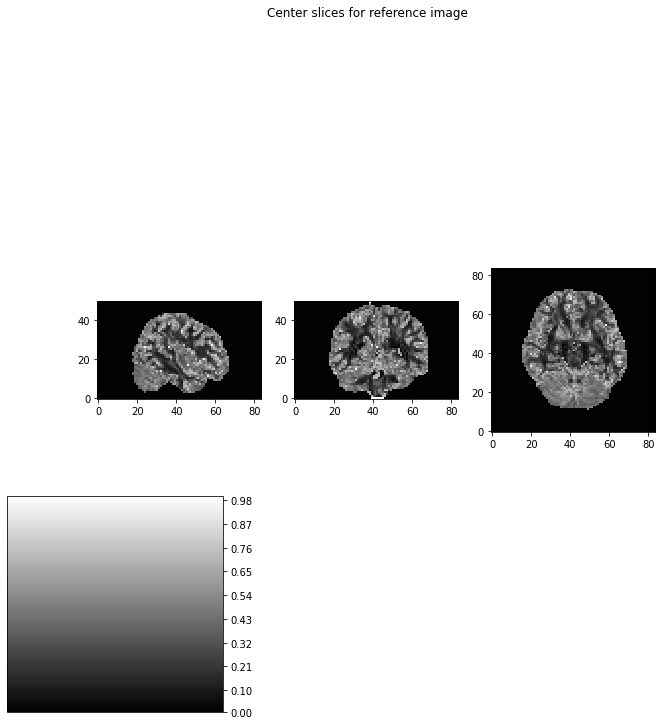

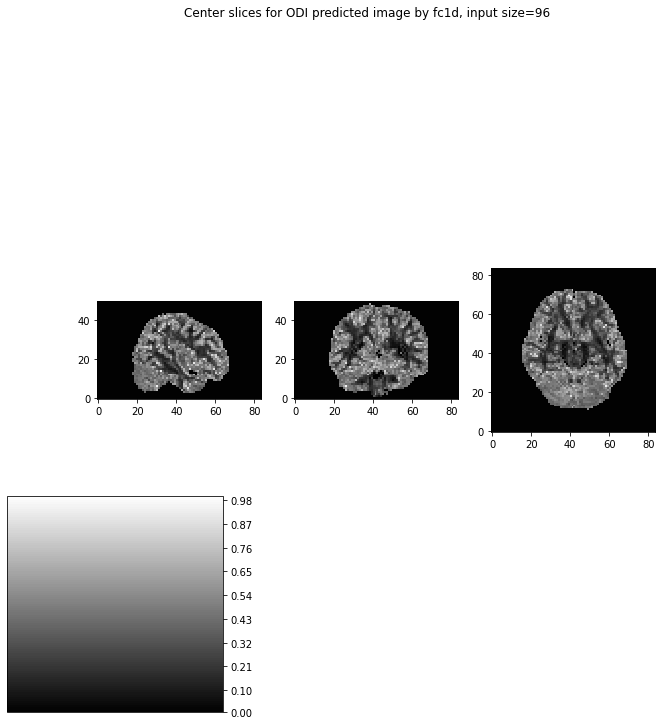

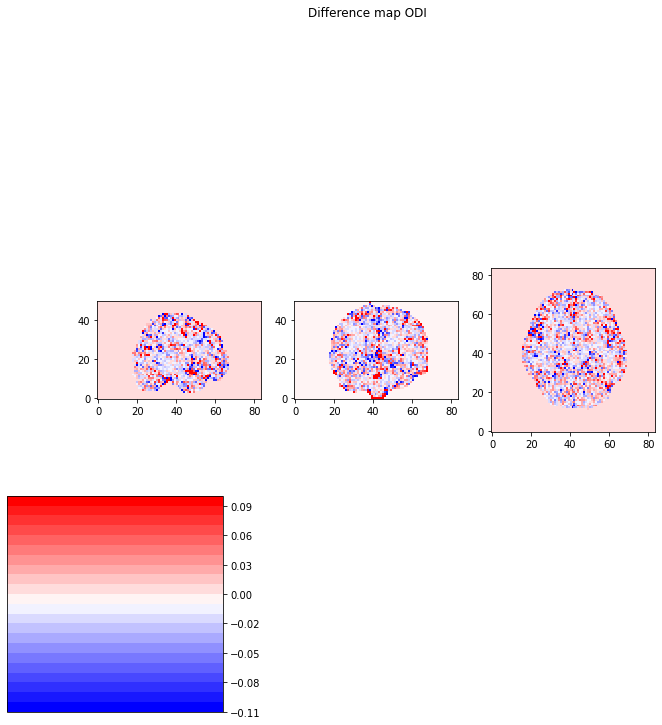

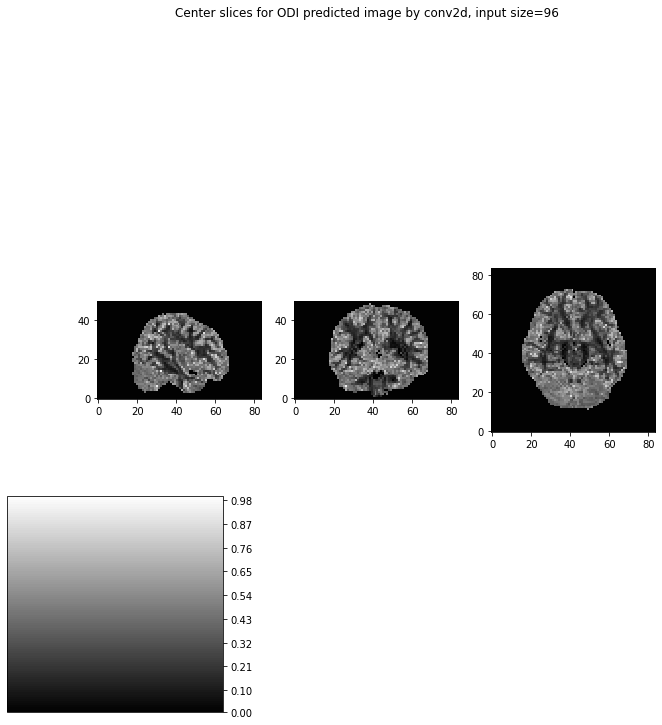

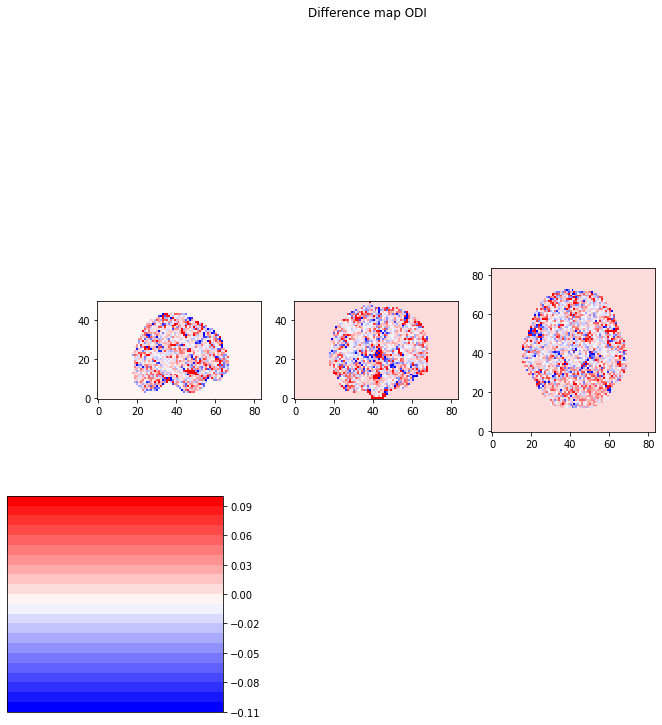

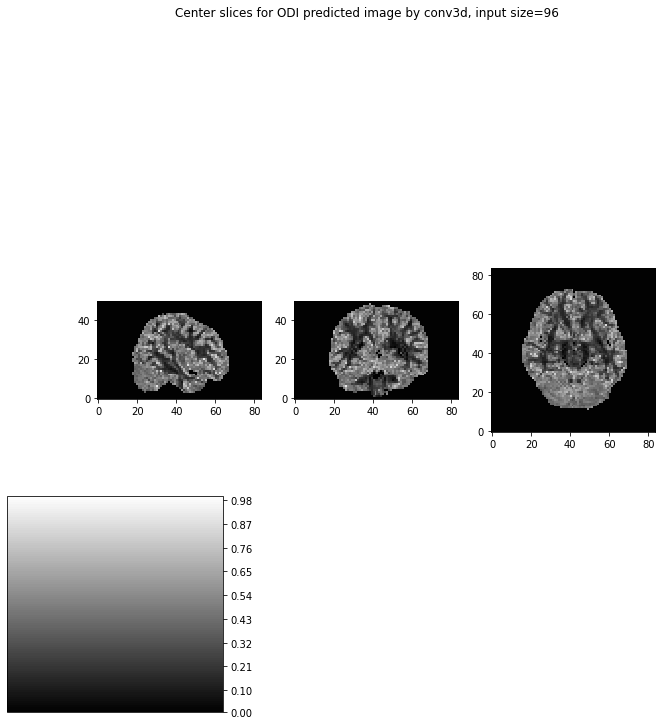

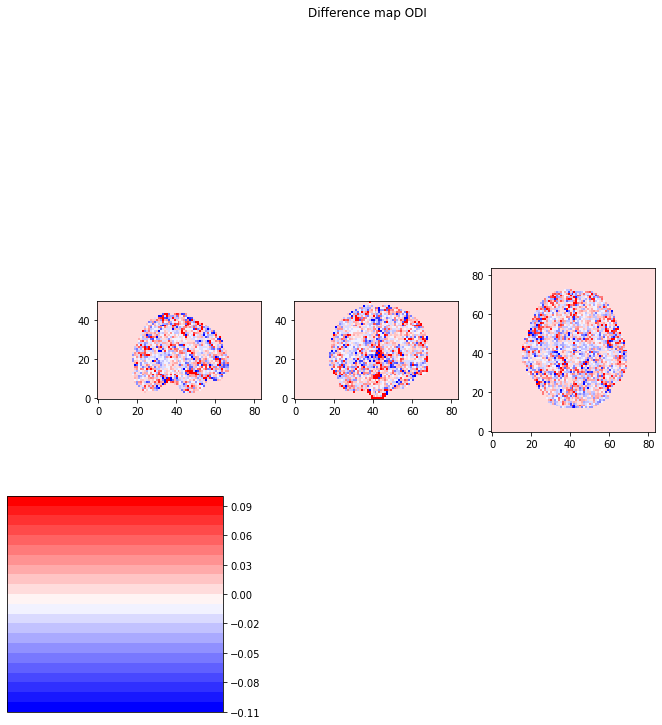

In [66]:
# load the reference img and pred img
visualise0(s01_ODI_img_data)
visualise2(s01_ODI_img_data, 96, 's01_still', 'fc1d',layer, s01_ODI_affine)
visualise2(s01_ODI_img_data, 96, 's01_still', 'conv2d',layer, s01_ODI_affine)
visualise2(s01_ODI_img_data, 96, 's01_still', 'conv3d',layer, s01_ODI_affine)

<strong>4 layer</strong>

In [17]:
layer = 4

ANN

96
Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 150)               14550     
_________________________________________________________________
dense_9 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_10 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_11 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_6 (Dropout)          (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)            

2022-04-09 14:32:29.997392: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 14:32:29.997495: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 14:32:30.236933: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 14:32:30.257331: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 14:32:30.257617: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 14:32:30.258912: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_14_32_30
2022-04-09 14:32:30.259430: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_14_32_30/vw.trace.json.gz
2022-04-09 14:32:30.259504: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 14:32:30.260526: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

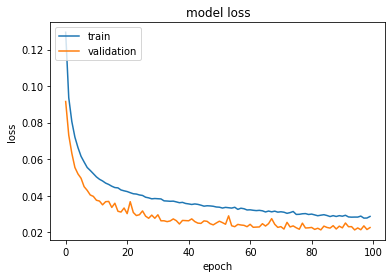

96-fc1d-patch_1-base_1-layer_4-label_ODIsynthetic
(84, 50, 96)
Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_13 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_14 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_15 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_7 (Dropout)          (None, 150)               0         
________________________________________________________

In [18]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 1, 1)      

2022-04-09 14:33:51.176856: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 14:33:51.176960: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 14:33:51.629684: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 14:33:51.651406: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 14:33:51.651654: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 14:33:51.652853: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_14_33_51
2022-04-09 14:33:51.653379: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_14_33_51/vw.trace.json.gz
2022-04-09 14:33:51.653454: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 14:33:51.654479: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

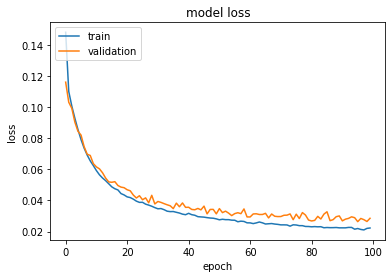

96-conv2d-patch_3-base_1-layer_4-label_ODIsynthetic
(84, 84, 96)
Model: "functional_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_9 (Dropout)          (None, 82, 82, 150)       0         
______________________________________________________

In [19]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 1, 1, 1, 1)   

2022-04-09 14:35:54.019196: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 1883782656 exceeds 10% of free system memory.


(90846, 3, 3, 3, 96)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 150)
(90846, 1, 1, 1, 1)
(90846, 1, 1, 1, 1)
Training start ...


2022-04-09 14:35:54.851739: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 14:35:54.851895: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 14:35:55.557099: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 14:35:55.578321: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 14:35:55.578587: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 14:35:55.583544: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_14_35_55
2022-04-09 14:35:55.584091: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_14_35_55/vw.trace.json.gz
2022-04-09 14:35:55.584229: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 14:35:55.585255: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

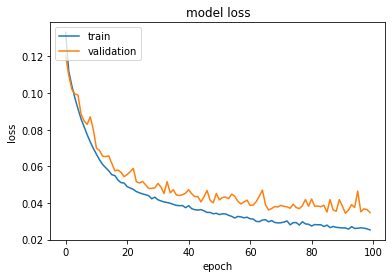

96-conv3d-patch_3-base_1-layer_4-label_ODIsynthetic
(84, 84, 50)
Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_11 (Dropout)         (None, 82, 82, 48, 150)   0         
______________________________________________________

In [20]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for odi is: 0.9638306233359738
3
conv2d
96input size the ssim score for odi is: 0.9629352026442504
3
conv3d
96input size the ssim score for odi is: 0.9618135092019782


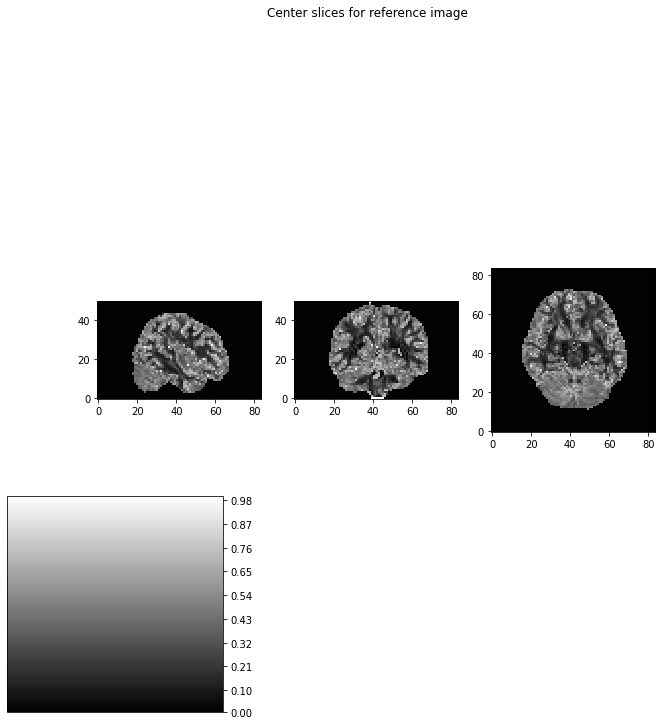

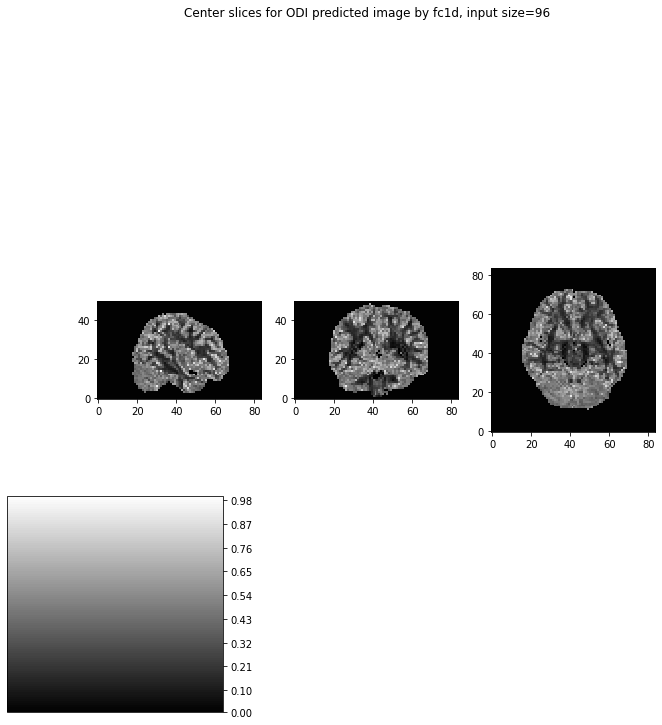

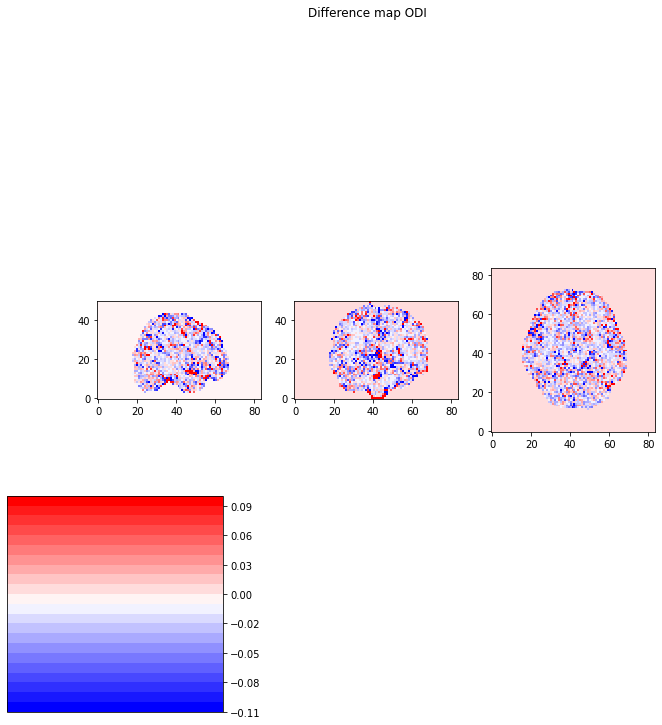

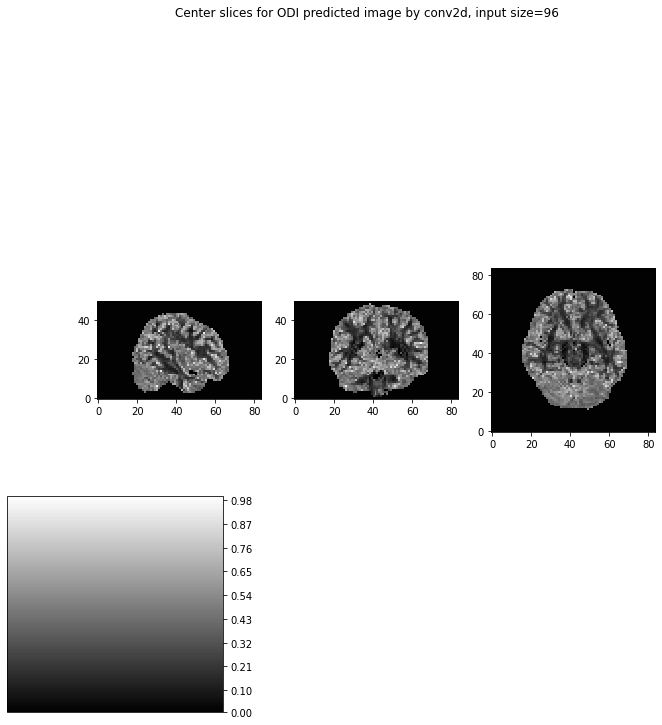

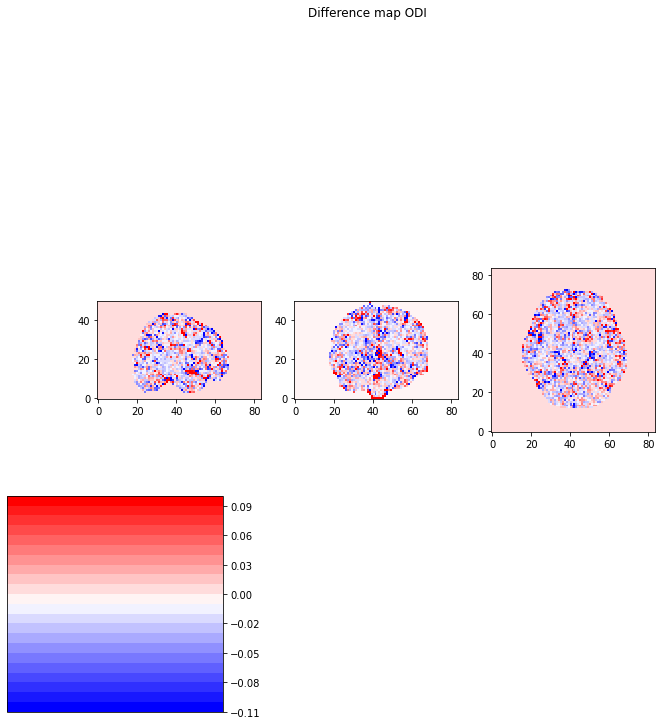

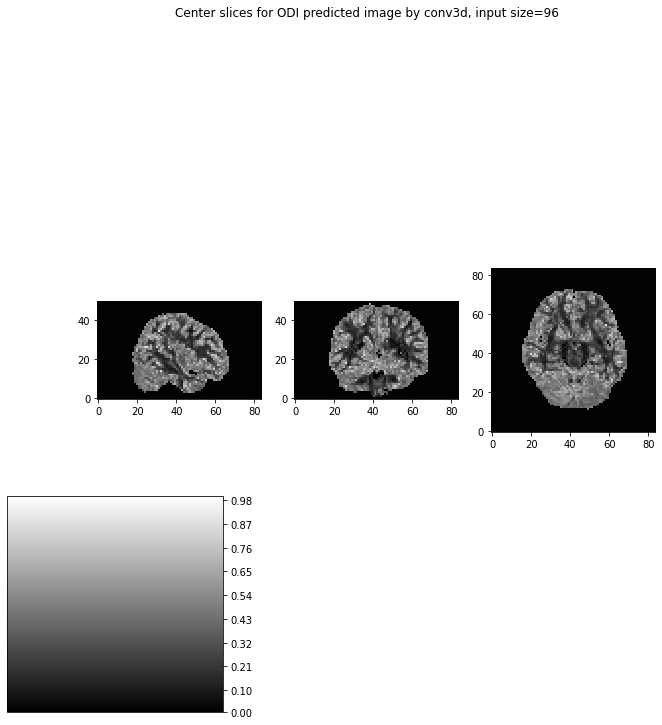

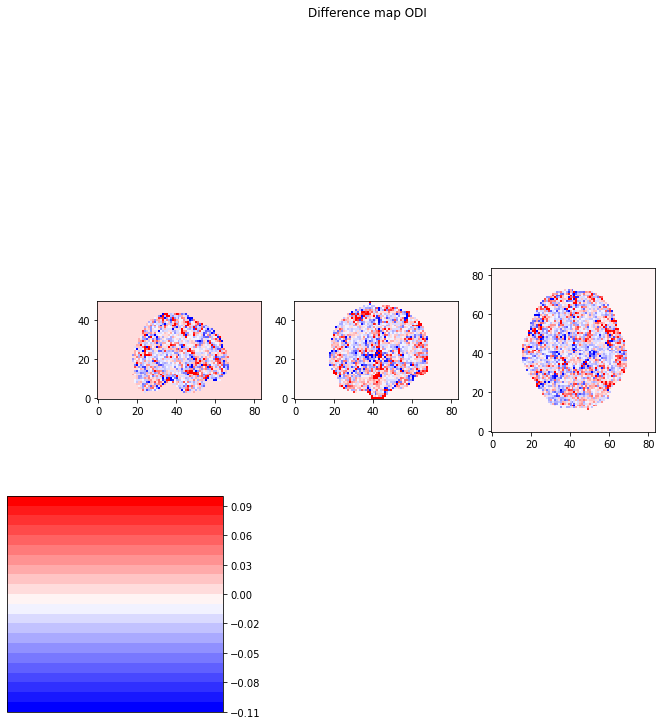

In [71]:
# load the reference img and pred img
visualise0(s01_ODI_img_data)
visualise2(s01_ODI_img_data, 96, 's01_still', 'fc1d',layer, s01_ODI_affine)
visualise2(s01_ODI_img_data, 96, 's01_still', 'conv2d',layer, s01_ODI_affine)
visualise2(s01_ODI_img_data, 96, 's01_still', 'conv3d',layer, s01_ODI_affine)

<strong>5 layer</strong>

In [72]:
layer = 5

<strong>ANN</strong>

96
Model: "functional_181"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_62 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_63 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_64 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_65 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_66 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_60 (Dropout)         (None, 150)         

2022-04-07 16:14:51.592256: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:14:51.592376: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 16:14:51.956933: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:14:51.978748: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 16:14:51.979043: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 16:14:51.980326: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_16_14_51
2022-04-07 16:14:51.980884: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_16_14_51/vw.trace.json.gz
2022-04-07 16:14:51.980970: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 16:14:51.981939: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

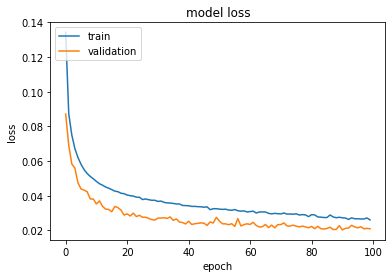

96-fc1d-patch_1-base_1-layer_5-label_ODIsynthetic
(84, 50, 96)
Model: "functional_185"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_67 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_68 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_69 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_70 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_71 (Dense)             (None, 150)               22650     
_______________________________________________________

In [73]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

<strong>2D CNN</strong>

96
Model: "functional_187"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_62 (Dropout)         (None, 1, 1, 150)   

2022-04-07 16:15:48.144156: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:15:48.144313: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 16:15:48.715448: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:15:48.741955: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 16:15:48.742244: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 16:15:48.743479: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_16_15_48
2022-04-07 16:15:48.744057: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_16_15_48/vw.trace.json.gz
2022-04-07 16:15:48.744145: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 16:15:48.745130: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

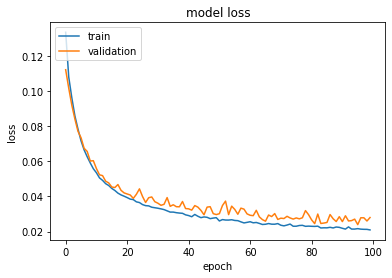

96-conv2d-patch_3-base_1-layer_5-label_ODIsynthetic
(84, 84, 96)
Model: "functional_191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 82, 82, 150)       22650     
_____________________________________________________

In [74]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

<strong>3D CNN</strong>

96
Model: "functional_193"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_82 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_83 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_84 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_85 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_86 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_64 (Dropout)         (None, 1, 1, 1, 150)

2022-04-07 16:17:45.657972: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:17:45.658138: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 16:17:46.432101: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:17:46.456357: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 16:17:46.456640: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 16:17:46.457857: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_16_17_46
2022-04-07 16:17:46.458418: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_16_17_46/vw.trace.json.gz
2022-04-07 16:17:46.458494: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 16:17:46.459387: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

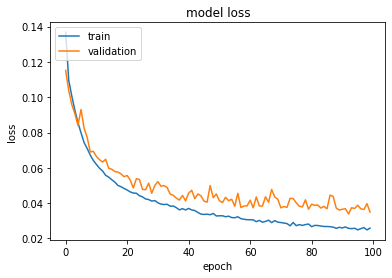

96-conv3d-patch_3-base_1-layer_5-label_ODIsynthetic
(84, 84, 50)
Model: "functional_197"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_88 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_89 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_90 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_91 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_92 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_____________________________________________________

In [75]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for odi is: 0.9645064189032663
3
conv2d
96input size the ssim score for odi is: 0.9638497053069617
3
conv3d
96input size the ssim score for odi is: 0.963449196589581


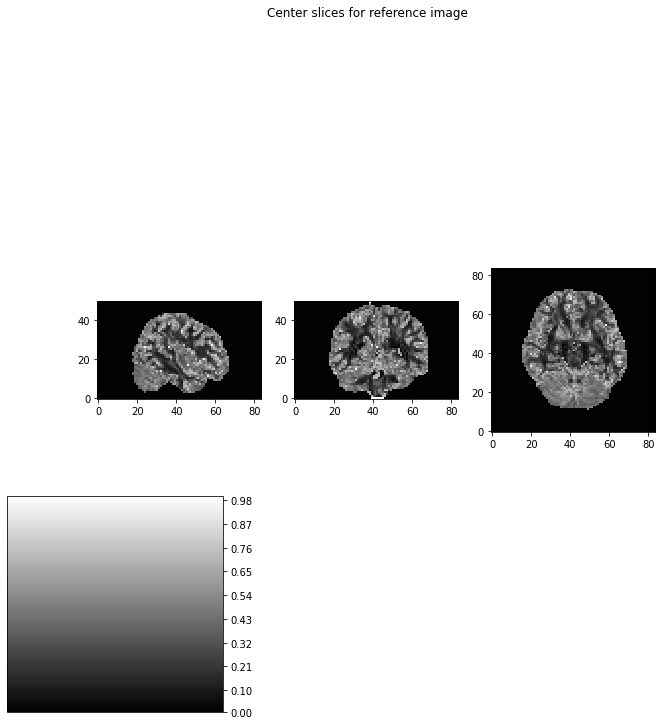

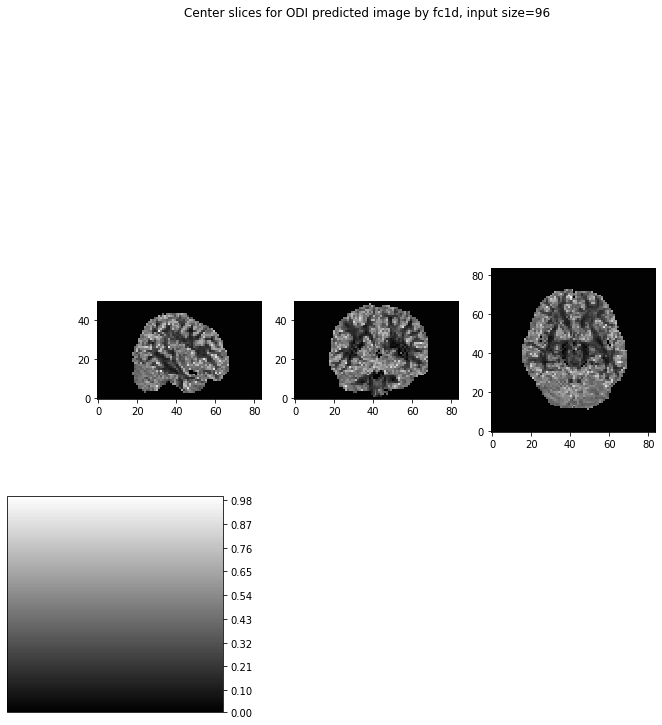

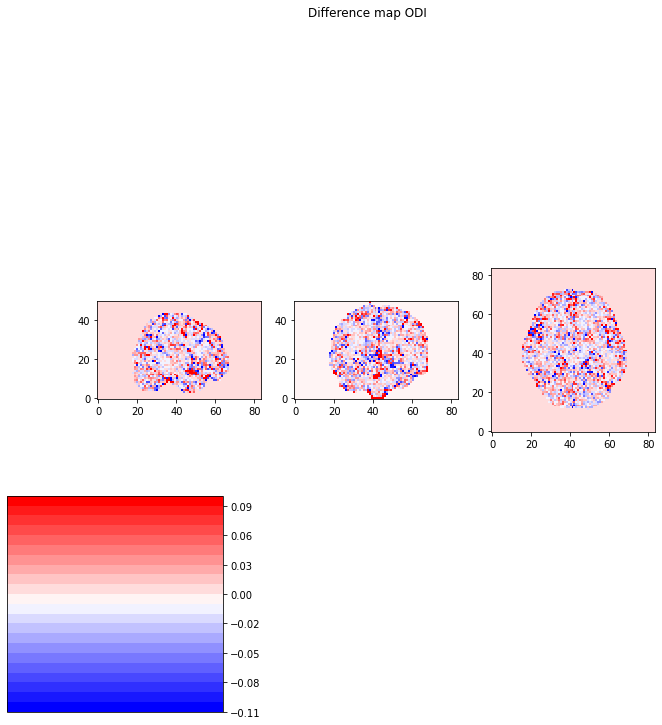

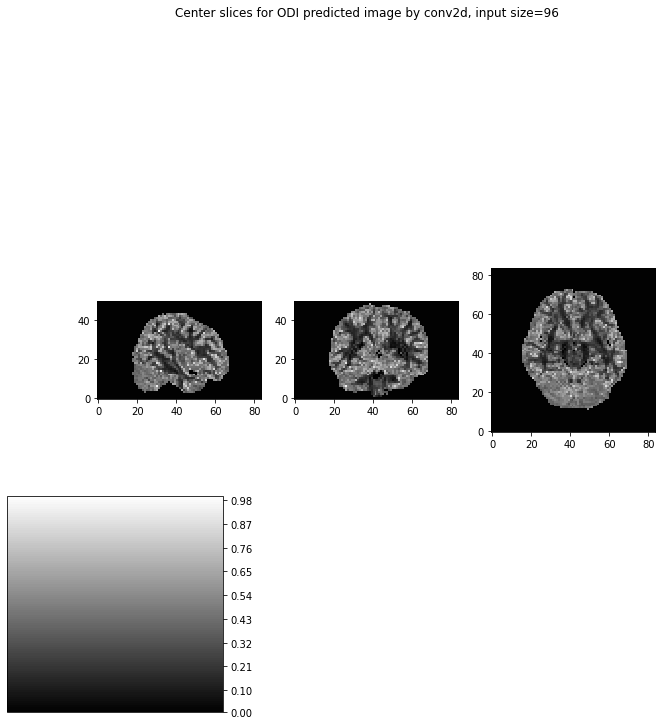

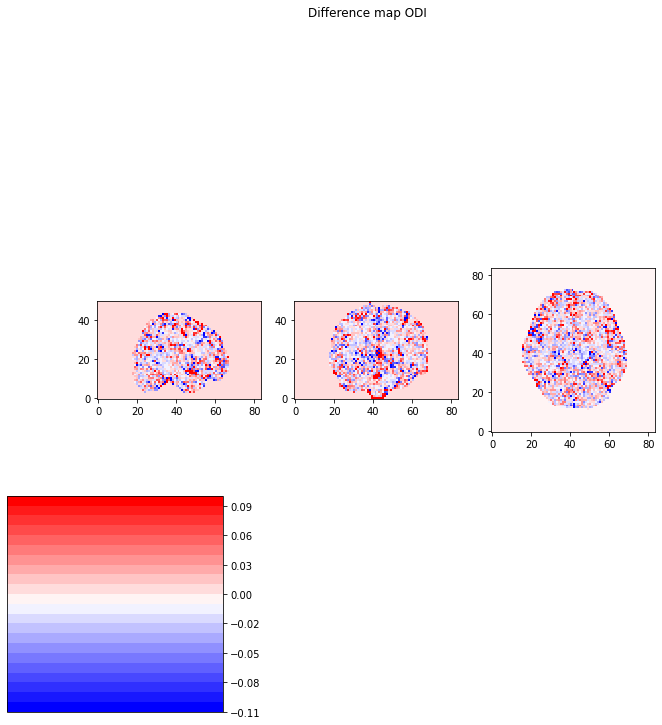

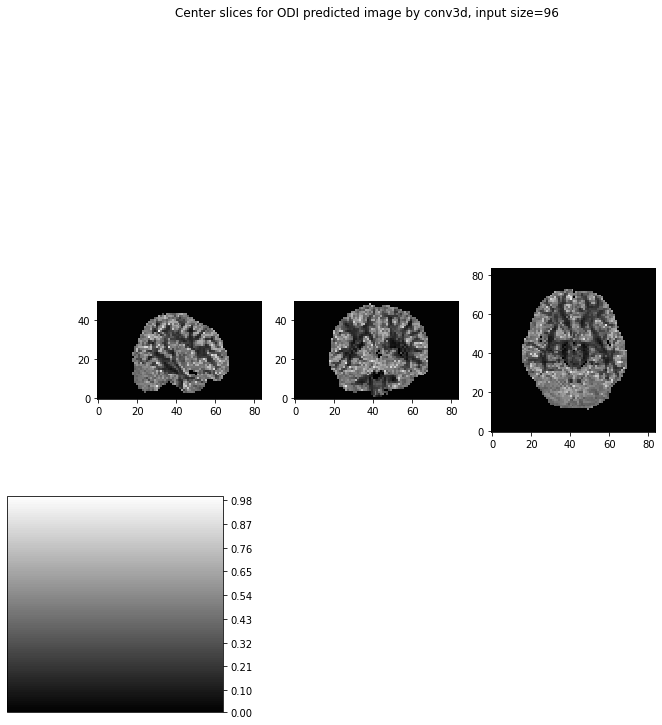

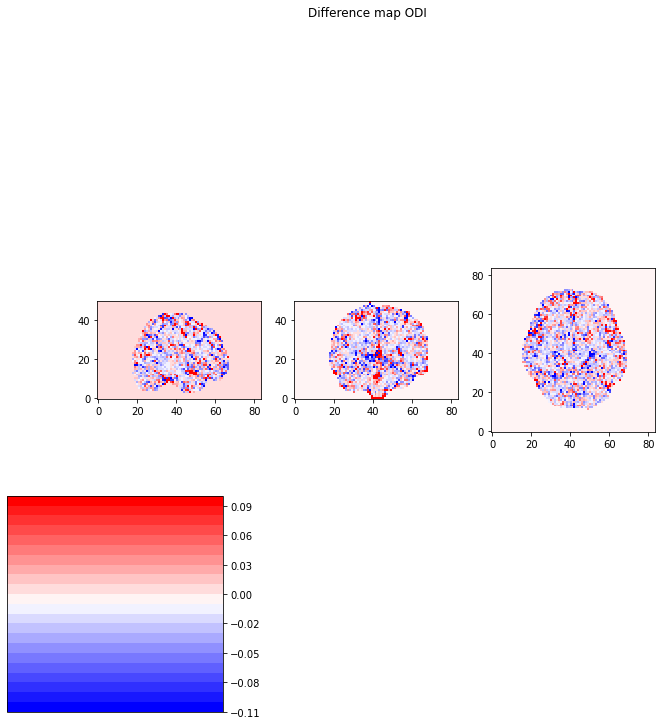

In [76]:
# load the reference img and pred img
visualise0(s01_ODI_img_data)
visualise2(s01_ODI_img_data, 96, 's01_still', 'fc1d',layer, s01_ODI_affine)
visualise2(s01_ODI_img_data, 96, 's01_still', 'conv2d',layer, s01_ODI_affine)
visualise2(s01_ODI_img_data, 96, 's01_still', 'conv3d',layer, s01_ODI_affine)

<strong>6 layer</strong>

In [77]:
layer = 6

ANN

96
Model: "functional_199"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_72 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_73 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_74 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_75 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_76 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_77 (Dense)             (None, 150)         

2022-04-07 16:21:04.673153: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:21:04.673260: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 16:21:05.053262: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:21:05.077885: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 16:21:05.078208: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 16:21:05.079459: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_16_21_05
2022-04-07 16:21:05.080045: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_16_21_05/vw.trace.json.gz
2022-04-07 16:21:05.080122: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 16:21:05.081062: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

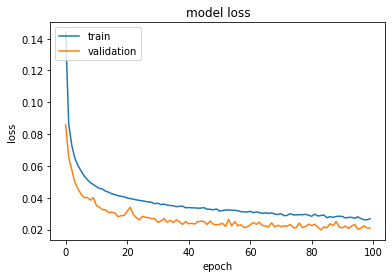

96-fc1d-patch_1-base_1-layer_6-label_ODIsynthetic
(84, 50, 96)
Model: "functional_203"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_78 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_79 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_80 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_81 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_82 (Dense)             (None, 150)               22650     
_______________________________________________________

In [78]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 1, 1, 150)   

2022-04-07 16:22:08.114196: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:22:08.114302: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 16:22:08.702415: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:22:08.731889: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 16:22:08.732188: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 16:22:08.733463: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_16_22_08
2022-04-07 16:22:08.734044: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_16_22_08/vw.trace.json.gz
2022-04-07 16:22:08.734128: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 16:22:08.735041: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

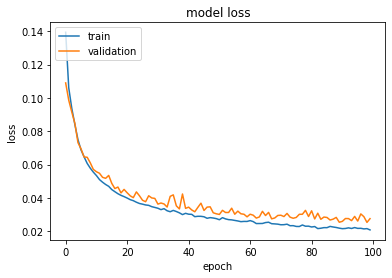

96-conv2d-patch_3-base_1-layer_6-label_ODIsynthetic
(84, 84, 96)
Model: "functional_209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 82, 82, 150)       22650     
_____________________________________________________

In [79]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

In [80]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type O'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type O'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96
Model: "functional_211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_94 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_95 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_96 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_97 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_98 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_99 (Conv3D)           (None, 1, 1, 1, 150)

2022-04-07 16:24:19.971912: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:24:19.972004: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-07 16:24:20.983828: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-07 16:24:21.020034: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-07 16:24:21.020402: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-07 16:24:21.021767: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_07_16_24_21
2022-04-07 16:24:21.022366: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_07_16_24_21/vw.trace.json.gz
2022-04-07 16:24:21.022453: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-07 16:24:21.023426: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

96-conv3d-patch_3-base_1-layer_6-label_ODIsynthetic
(84, 84, 50)
Model: "functional_215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_101 (Conv3D)          (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_102 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_103 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_104 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_____________________________________________________

1
fc1d
96input size the ssim score for odi is: 0.9644917788184807
3
conv2d
96input size the ssim score for odi is: 0.9638904994567926
3
conv3d
96input size the ssim score for odi is: 0.9632801465901212


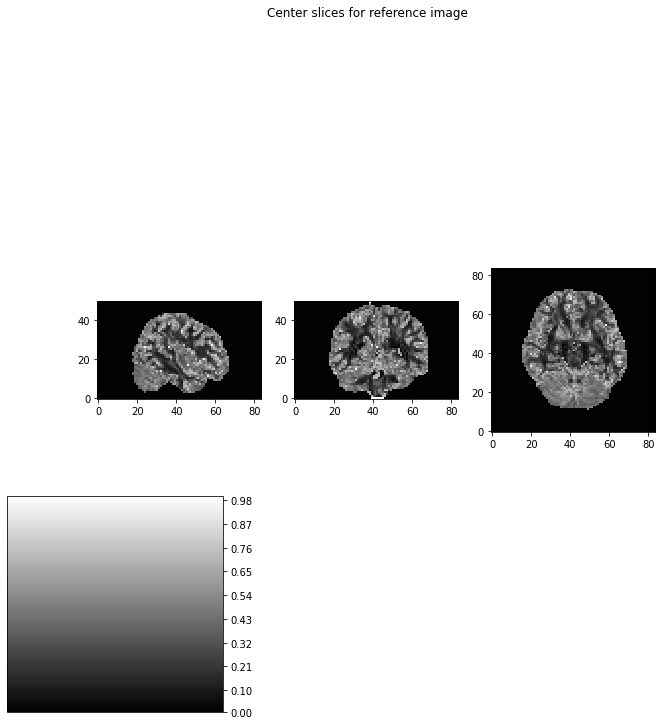

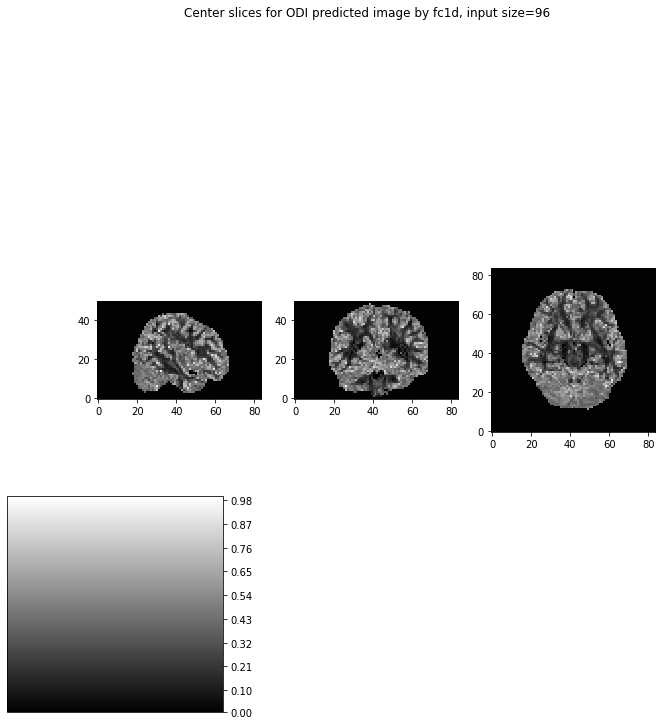

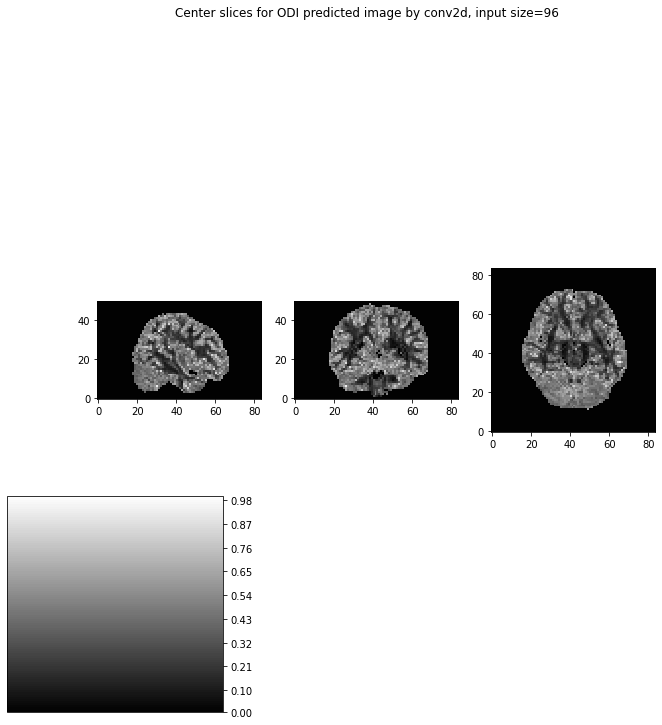

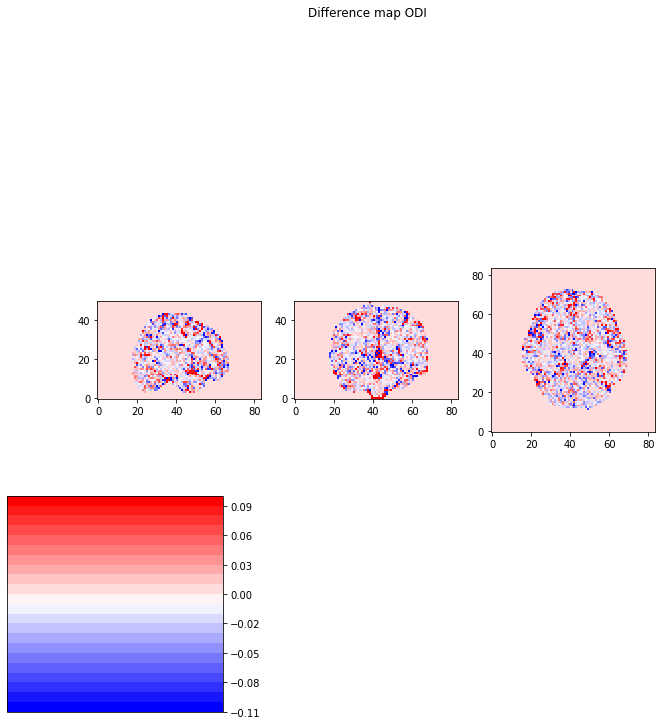

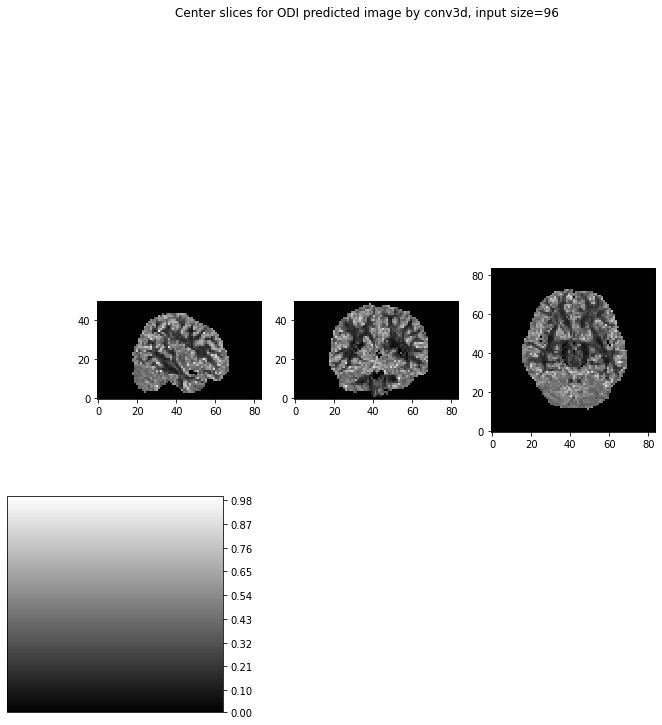

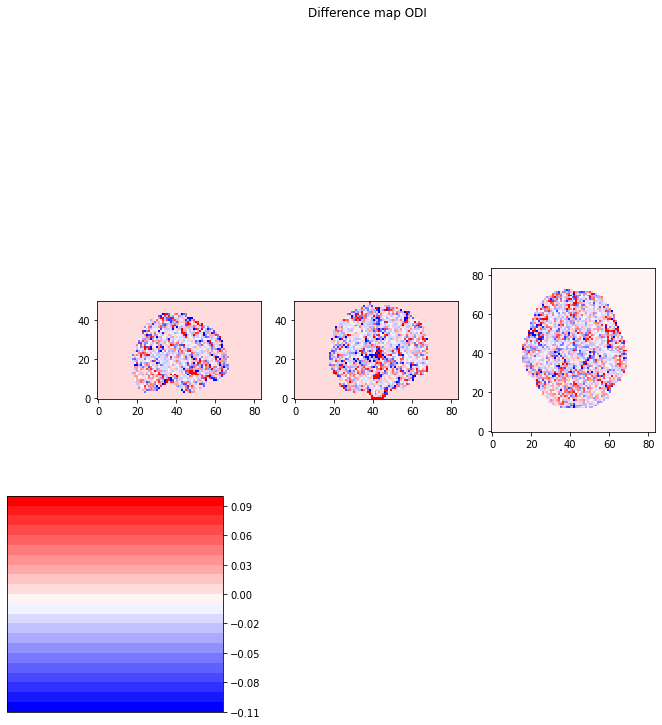

In [81]:
# load the reference img and pred img
visualise0(s01_ODI_img_data)
visualise2(s01_ODI_img_data, 96, 's01_still', 'fc1d',layer, s01_ODI_affine)
visualise2(s01_ODI_img_data, 96, 's01_still', 'conv2d',layer, s01_ODI_affine)
visualise2(s01_ODI_img_data, 96, 's01_still', 'conv3d',layer, s01_ODI_affine)

<strong>FWF</strong>

In [82]:
# Generate the dataset for ANNc
cmd = "--subjects s01_still s02_still --fc1d --label_type F"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (352800,)
data befor masking has shape: (352800, 96)
data after masking has shape: (81882, 96) the ratio of masked voxel is: 0.23209183673469388
training dataset has shape:(81882, 96)
(84, 84, 50, 1)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (81882, 1) the ratio of masked voxel is: 0.23209183673469388
training label has shape:(81882, 1)
Generating for s02_still ...
mask has shape: (352800,)
data befor masking has shape: (352800, 96)
data after masking has shape: (91401, 96) the ratio of masked voxel is: 0.2590731292517007
training dataset has shape:(91401, 96)
(84, 84, 50, 1)
mask has shape: (352800,)
data befor masking has shape: (352800, 1)
data after masking has shape: (91401, 1) the ratio of masked voxel is: 0.2590731292517007
training label has shape:(91401, 1)


In [83]:
# Generate the dataset for 2D CNN
cmd = "--subjects s01_still s02_still --conv2d --label_type F"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 48, 96)
label has shape: (82, 82, 48, 1)
(81634, 3, 3, 96)
saved patches has shape: (81634, 3, 3, 96)
(81634, 1, 1, 1)
svaed labels has shape: (81634, 1, 1, 1)
Generating for s02_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 48, 96)
label has shape: (82, 82, 48, 1)
(90846, 3, 3, 96)
saved patches has shape: (90846, 3, 3, 96)
(90846, 1, 1, 1)
svaed labels has shape: (90846, 1, 1, 1)


In [84]:
# Generate the dataset for 3D CNN
cmd = "--subjects s01_still s02_still --conv3d --label_type F"
args = data_parser().parse_args(cmd.split())
generate_data(args)

Generating for s01_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 50, 96)
label has shape: (82, 82, 48, 1)
(84, 84, 50, 96) (82, 82, 48)
(81634, 3, 3, 3, 96)
saved patches has shape: (81634, 2592)
(82, 82, 48, 1) (82, 82, 48)
(81634, 1, 1, 1, 1)
svaed labels has shape: (81634, 1, 1, 1, 1)
Generating for s02_still ...
mask has shape: (82, 82, 48)
data has shape: (84, 84, 50, 96)
label has shape: (82, 82, 48, 1)
(84, 84, 50, 96) (82, 82, 48)
(90846, 3, 3, 3, 96)
saved patches has shape: (90846, 2592)
(82, 82, 48, 1) (82, 82, 48)
(90846, 1, 1, 1, 1)
svaed labels has shape: (90846, 1, 1, 1, 1)


<strong>1 layer</strong>

In [39]:
layer = 1

ANN

In [40]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96
Model: "functional_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 150)               14550     
_________________________________________________________________
dropout_34 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_34 (ReLU)              (None, 1)                 0         
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
['F']
The remained data has shape: (91401, 96)
(91401, 96)
(91401, 150)
(91401, 150)
(91401, 1)
(91401, 1)
Trai

2022-04-09 15:07:46.343829: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:07:46.343905: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:07:46.589020: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:07:46.612928: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:07:46.613164: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:07:46.614408: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_07_46
2022-04-09 15:07:46.614849: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_07_46/vw.trace.json.gz
2022-04-09 15:07:46.614911: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:07:46.615765: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

96-fc1d-patch_1-base_1-layer_1-label_FWFsynthetic
(84, 50, 96)
Model: "functional_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_25 (Dense)             (None, 150)               14550     
_________________________________________________________________
dropout_35 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_35 (ReLU)              (None, 1)                 0         
Total params: 14,701
Trainable params: 14,701
Non-trainable params: 0
_________________________________________________________________
testing data shape: (84, 84, 50, 96)
prediction has

2D CNN

96
Model: "functional_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
dropout_40 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_40 (ReLU)              (None, 1, 1, 1)           0         
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
['F']
The remained data has shape: (90846, 3, 3, 96)
(90846, 3, 3, 96)
(90846, 1, 1, 150)
(90846, 1, 1, 150)


2022-04-09 15:12:35.858845: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:12:35.858959: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:12:36.331812: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:12:36.348425: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:12:36.348662: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:12:36.349785: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_12_36
2022-04-09 15:12:36.350240: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_12_36/vw.trace.json.gz
2022-04-09 15:12:36.350313: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:12:36.351192: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

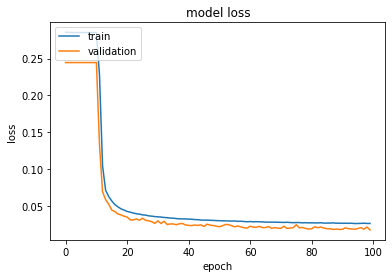

96-conv2d-patch_3-base_1-layer_1-label_FWFsynthetic
(84, 84, 96)
Model: "functional_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
dropout_41 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 82, 82, 1)         151       
_________________________________________________________________
re_lu_41 (ReLU)              (None, 82, 82, 1)         0         
Total params: 129,901
Trainable params: 129,901
Non-trainable params: 0
_________________________________________________________________
testing data shape: (50, 84, 84, 96)
prediction

In [43]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_56 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
dropout_38 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_57 (Conv3D)           (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_38 (ReLU)              (None, 1, 1, 1, 1)        0         
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
['F']
The remained data has shape: (90846, 3, 3, 3, 96)
(90846, 3, 3, 3, 96)
(90846, 1, 1, 1, 150)
(90846, 1,

2022-04-09 15:09:56.657510: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:09:56.657647: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:09:57.313016: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:09:57.328868: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:09:57.329084: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:09:57.330158: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_09_57
2022-04-09 15:09:57.330598: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_09_57/vw.trace.json.gz
2022-04-09 15:09:57.330658: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:09:57.331584: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

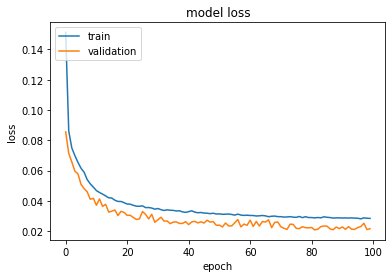

96-conv3d-patch_3-base_1-layer_1-label_FWFsynthetic
(84, 84, 50)
Model: "functional_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
dropout_39 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_59 (Conv3D)           (None, 82, 82, 48, 1)     151       
_________________________________________________________________
re_lu_39 (ReLU)              (None, 82, 82, 48, 1)     0         
Total params: 389,101
Trainable params: 389,101
Non-trainable params: 0
_________________________________________________________________
testing data shape: (1, 84, 84, 50, 96)
predict

In [42]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for fwf is: 0.9555651967188089
3
conv2d
96input size the ssim score for fwf is: 0.9568222403909062
3
conv3d
96input size the ssim score for fwf is: 0.9565274778041465


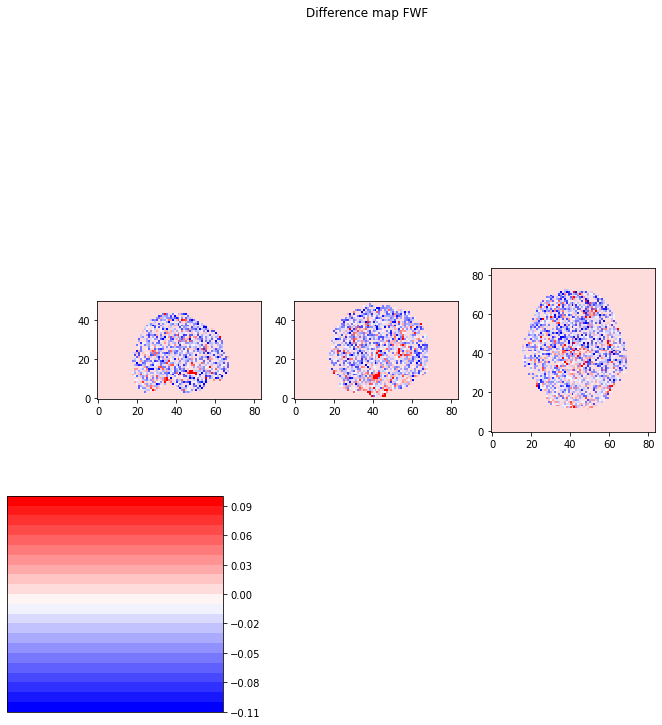

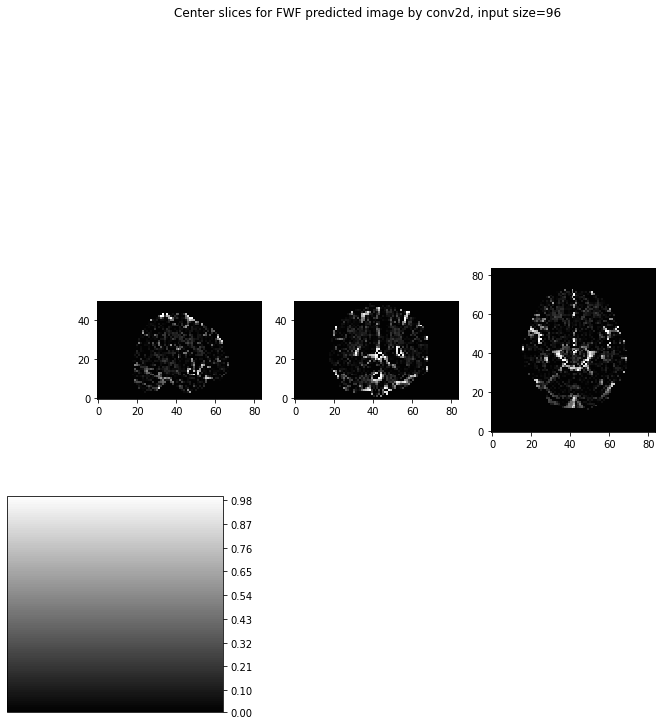

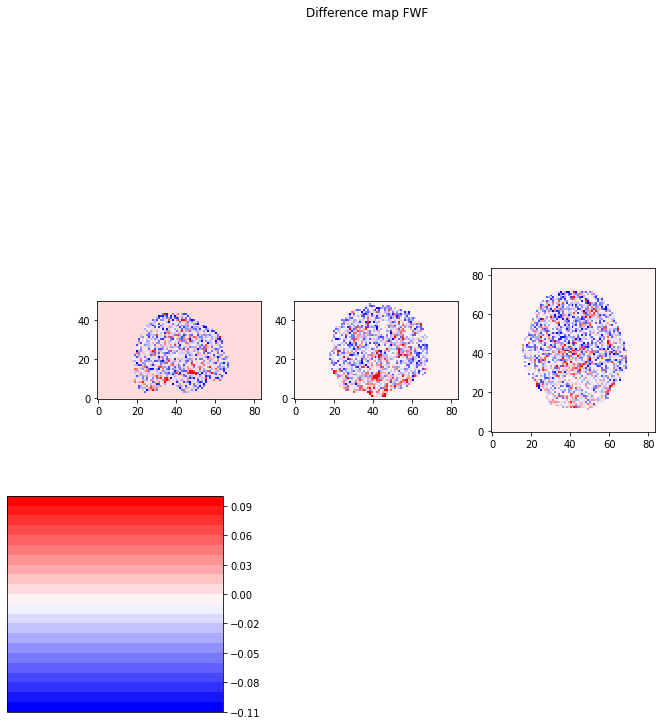

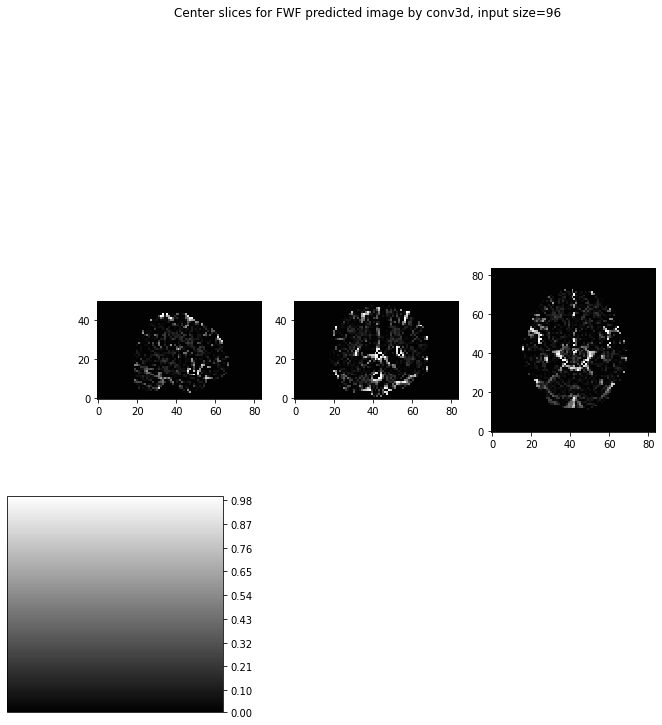

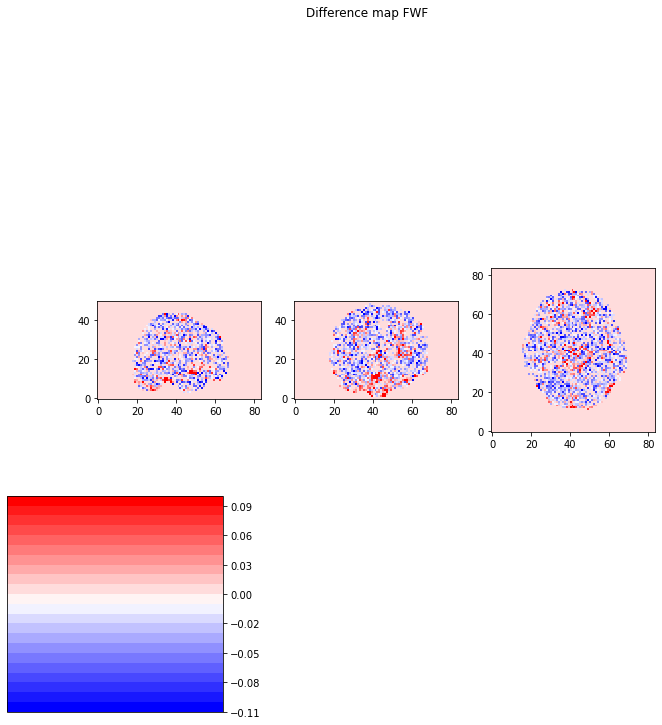

In [44]:
# load the reference img and pred img
visualise0(s01_FWF_img_data)
visualise3(s01_FWF_img_data, 96, 's01_still', 'fc1d',layer, s01_FWF_affine)
visualise3(s01_FWF_img_data, 96, 's01_still', 'conv2d',layer, s01_FWF_affine)
visualise3(s01_FWF_img_data, 96, 's01_still', 'conv3d',layer, s01_FWF_affine)

<strong>2 layer</strong>

In [45]:
layer = 2

ANN

In [46]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96
Model: "functional_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_26 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_27 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_42 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_42 (ReLU)              (None, 1)                 0         
Total params: 37,351
Trainable params: 37,351
Non-trainable params: 0
_____________________________________________

2022-04-09 15:14:21.034731: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:14:21.034871: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:14:21.328802: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:14:21.345594: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:14:21.345837: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:14:21.347039: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_14_21
2022-04-09 15:14:21.347512: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_14_21/vw.trace.json.gz
2022-04-09 15:14:21.347579: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:14:21.348525: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

96-fc1d-patch_1-base_1-layer_2-label_FWFsynthetic
(84, 50, 96)
Model: "functional_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_28 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_29 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_43 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_43 (ReLU)              (None, 1)                 0         
Total params: 37,351
Trainable params: 37,351
Non-train

2D CNN

In [47]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96
Model: "functional_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_44 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_44 (ReLU)              (None, 1, 1, 1)           0         
Total params: 152,551
Trainable params: 152,551
Non-trainable params: 0
___________________________________________

2022-04-09 15:15:39.607433: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:15:39.607604: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:15:40.087720: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:15:40.105119: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:15:40.105350: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:15:40.106598: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_15_40
2022-04-09 15:15:40.107055: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_15_40/vw.trace.json.gz
2022-04-09 15:15:40.107123: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:15:40.108021: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

96-conv2d-patch_3-base_1-layer_2-label_FWFsynthetic
(84, 84, 96)
Model: "functional_137"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_45 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 82, 82, 1)         151       
_________________________________________________________________
re_lu_45 (ReLU)              (None, 82, 82, 1)         0         
Total params: 152,551
Trainable params: 152,551
Non-t

3D CNN

In [48]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

96
Model: "functional_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_60 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_61 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_46 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_62 (Conv3D)           (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_46 (ReLU)              (None, 1, 1, 1, 1)        0         
Total params: 411,751
Trainable params: 411,751
Non-trainable params: 0
___________________________________________

2022-04-09 15:17:17.573296: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:17:17.573476: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:17:18.259320: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:17:18.277307: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:17:18.277550: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:17:18.278696: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_17_18
2022-04-09 15:17:18.279152: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_17_18/vw.trace.json.gz
2022-04-09 15:17:18.279213: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:17:18.280117: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

96-conv3d-patch_3-base_1-layer_2-label_FWFsynthetic
(84, 84, 50)
Model: "functional_143"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_63 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_64 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_47 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_65 (Conv3D)           (None, 82, 82, 48, 1)     151       
_________________________________________________________________
re_lu_47 (ReLU)              (None, 82, 82, 48, 1)     0         
Total params: 411,751
Trainable params: 411,751
Non-t

1
fc1d
96input size the ssim score for fwf is: 0.9537091585351928
3
conv2d
96input size the ssim score for fwf is: 0.9580390618017071
3
conv3d
96input size the ssim score for fwf is: 0.9578297816573947


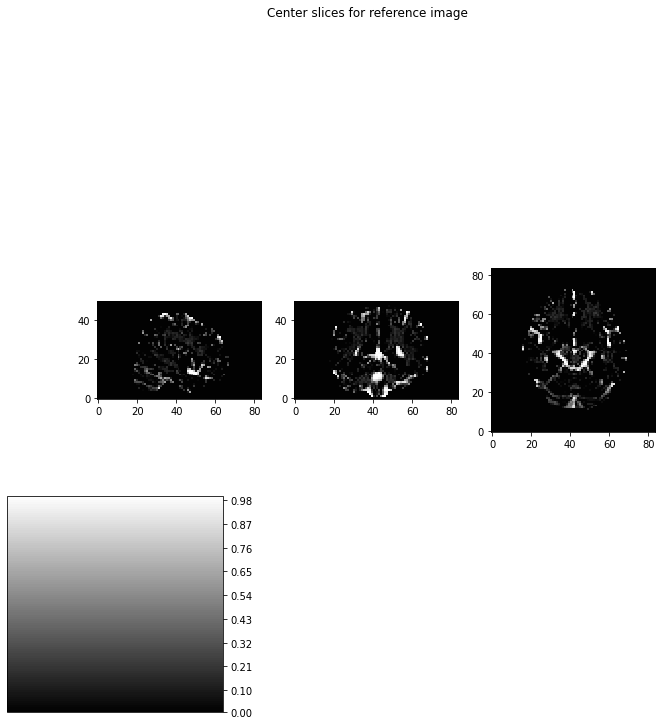

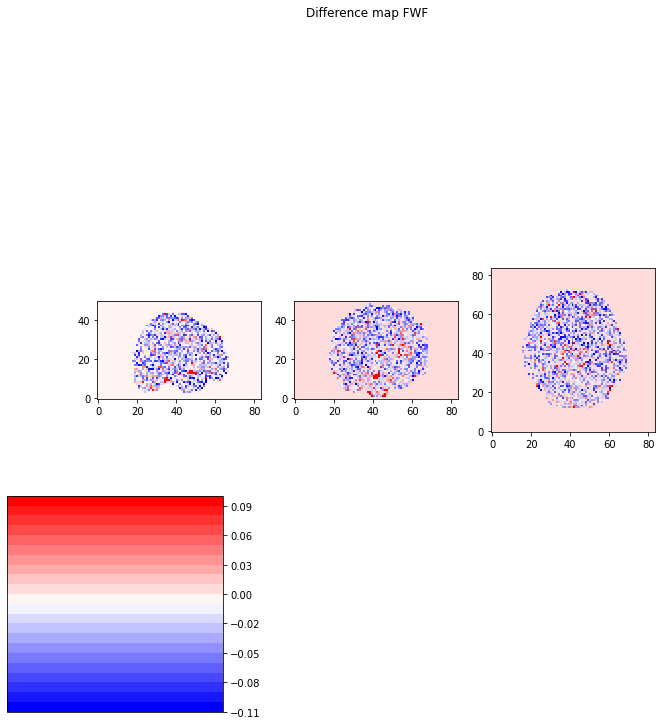

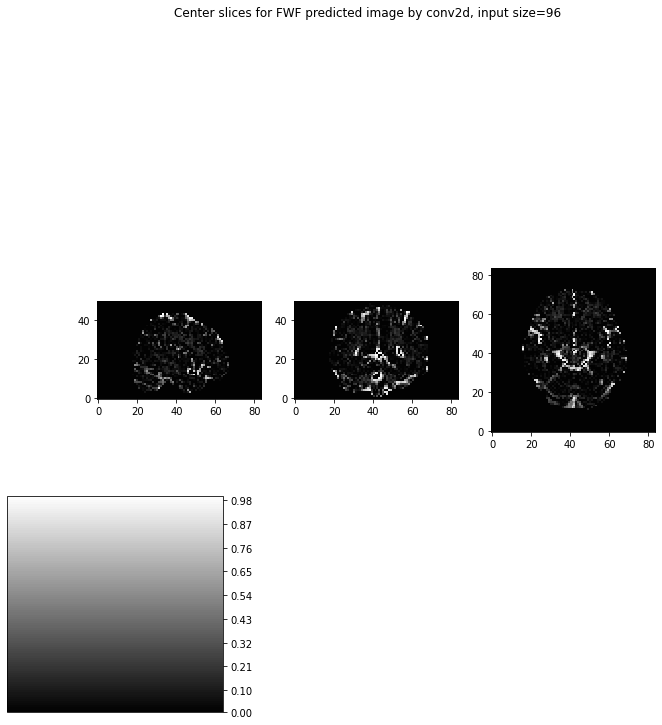

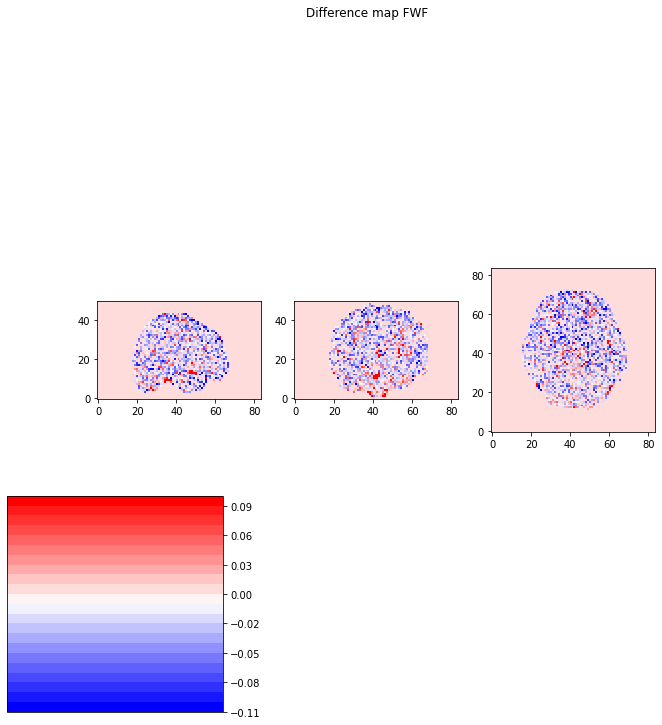

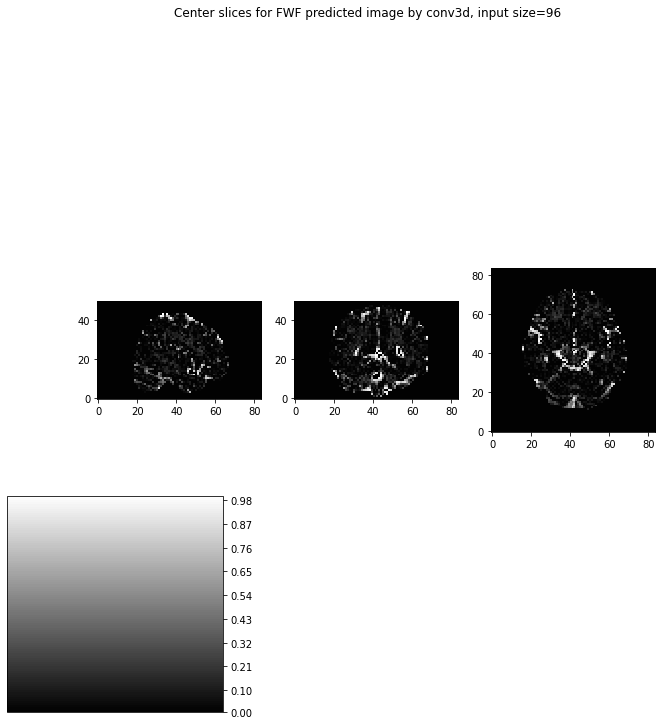

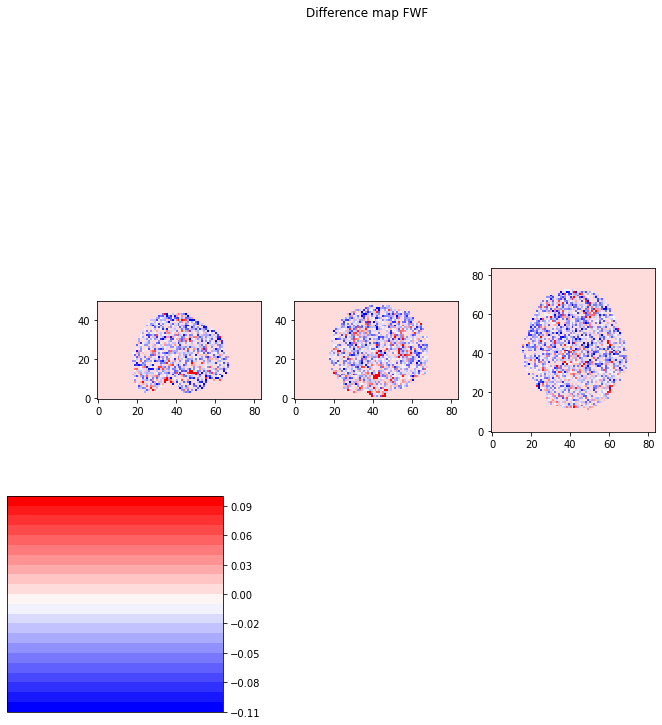

In [49]:
# load the reference img and pred img
visualise0(s01_FWF_img_data)
visualise3(s01_FWF_img_data, 96, 's01_still', 'fc1d',layer, s01_FWF_affine)
visualise3(s01_FWF_img_data, 96, 's01_still', 'conv2d',layer, s01_FWF_affine)
visualise3(s01_FWF_img_data, 96, 's01_still', 'conv3d',layer, s01_FWF_affine)

<strong>3 layer</strong>

In [50]:
layer = 3 

ANN

96
Model: "functional_145"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_30 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_31 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_32 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_48 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_________________________________________________________________
re_lu_48 (ReLU)              (None, 1)           

2022-04-09 15:20:42.187640: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:20:42.187741: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:20:42.475562: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:20:42.493548: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:20:42.493792: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:20:42.494981: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_20_42
2022-04-09 15:20:42.495457: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_20_42/vw.trace.json.gz
2022-04-09 15:20:42.495522: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:20:42.496463: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

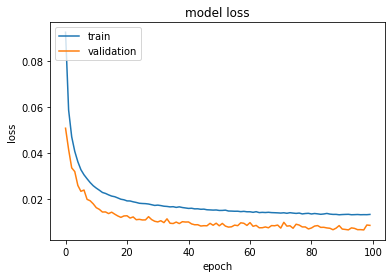

96-fc1d-patch_1-base_1-layer_3-label_FWFsynthetic
(84, 50, 96)
Model: "functional_149"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_33 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_34 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_35 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_49 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 151       
_______________________________________________________

In [51]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_157"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_52 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 1, 1, 1)           151       
_________________________________________________________________
re_lu_52 (ReLU)              (None, 1, 1, 1)     

2022-04-09 15:24:31.628776: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:24:31.628865: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:24:32.120539: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:24:32.138465: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:24:32.138711: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:24:32.139891: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_24_32
2022-04-09 15:24:32.140368: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_24_32/vw.trace.json.gz
2022-04-09 15:24:32.140426: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:24:32.141315: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

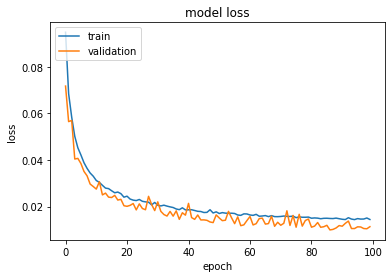

96-conv2d-patch_3-base_1-layer_3-label_FWFsynthetic
(84, 84, 96)
Model: "functional_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_53 (Dropout)         (None, 82, 82, 150)       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 82, 82, 1)         151       
_____________________________________________________

In [53]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_67 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_68 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_54 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_69 (Conv3D)           (None, 1, 1, 1, 1)        151       
_________________________________________________________________
re_lu_54 (ReLU)              (None, 1, 1, 1, 1)  

2022-04-09 15:27:11.461370: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:27:11.461451: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:27:12.161696: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:27:12.181832: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:27:12.182087: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:27:12.183243: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_27_12
2022-04-09 15:27:12.183722: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_27_12/vw.trace.json.gz
2022-04-09 15:27:12.183783: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:27:12.184712: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

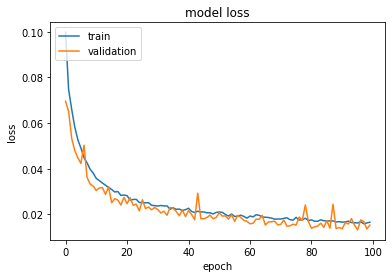

96-conv3d-patch_3-base_1-layer_3-label_FWFsynthetic
(84, 84, 50)
Model: "functional_167"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_71 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_72 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_55 (Dropout)         (None, 82, 82, 48, 150)   0         
_________________________________________________________________
conv3d_73 (Conv3D)           (None, 82, 82, 48, 1)     151       
_____________________________________________________

In [54]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for fwf is: 0.9548845749420911
3
conv2d
96input size the ssim score for fwf is: 0.9561466531793548
3
conv3d
96input size the ssim score for fwf is: 0.9550611933372344


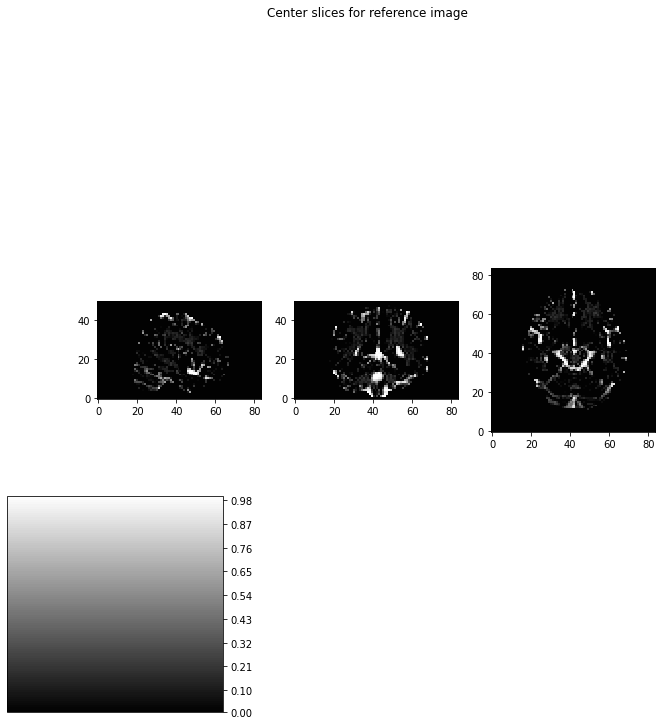

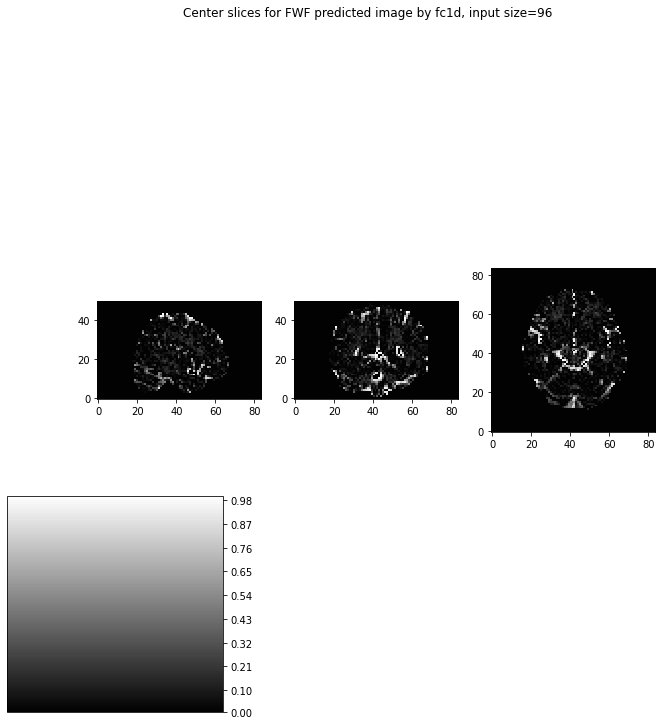

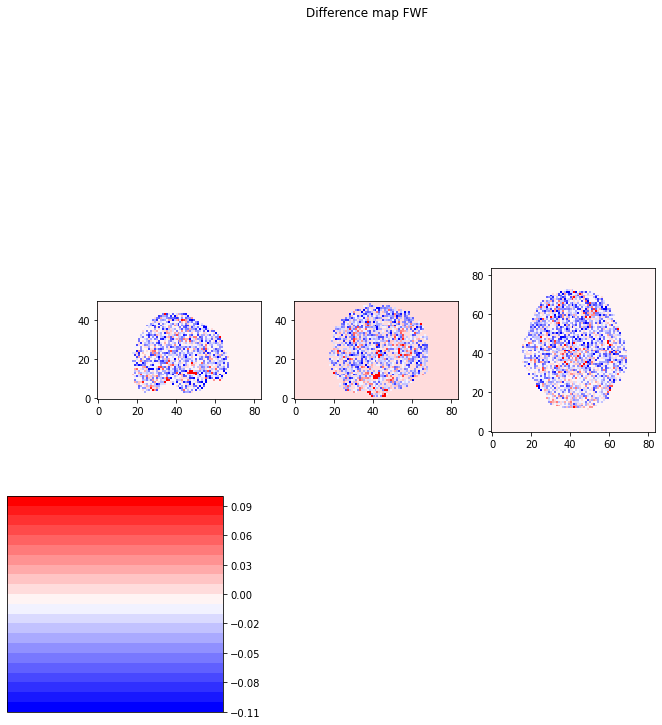

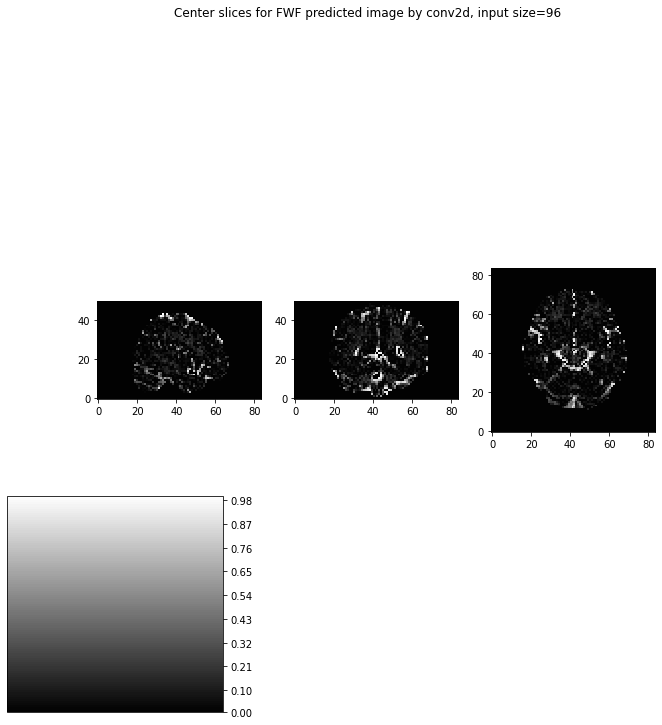

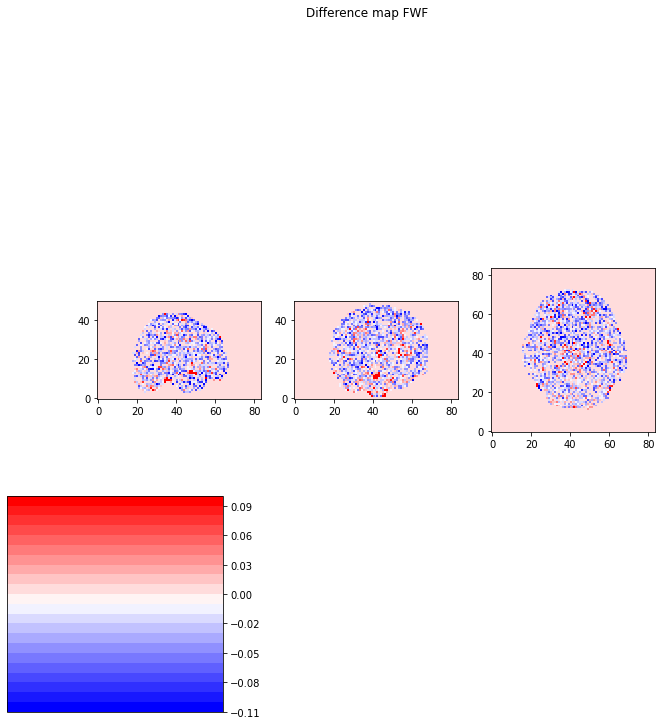

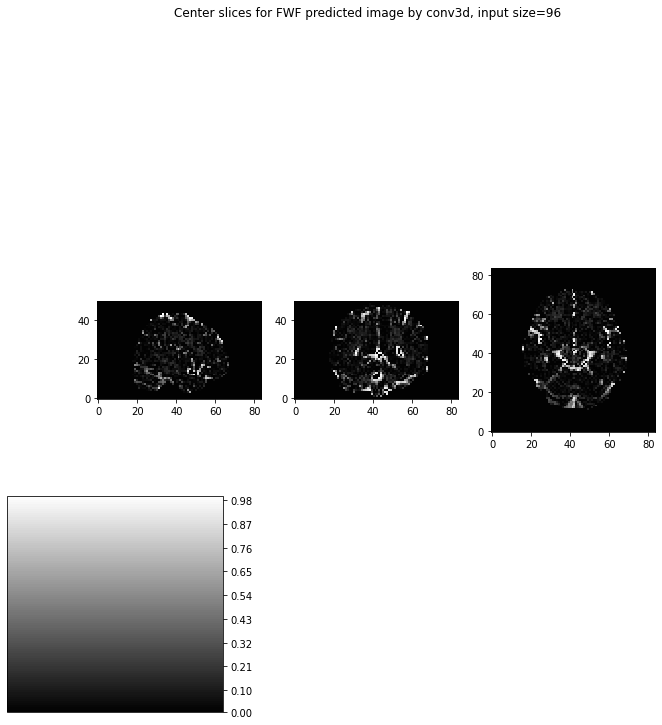

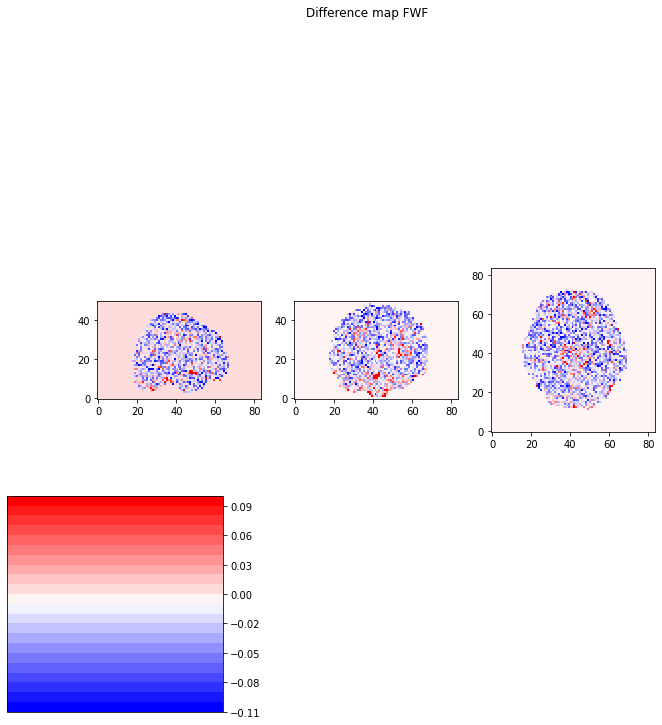

In [55]:
# load the reference img and pred img
visualise0(s01_FWF_img_data)
visualise3(s01_FWF_img_data, 96, 's01_still', 'fc1d',layer, s01_FWF_affine)
visualise3(s01_FWF_img_data, 96, 's01_still', 'conv2d',layer, s01_FWF_affine)
visualise3(s01_FWF_img_data, 96, 's01_still', 'conv3d',layer, s01_FWF_affine)

<strong>4 layer</strong>

In [56]:
layer = 4

ANN

96
Model: "functional_169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_36 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_37 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_38 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_39 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_56 (Dropout)         (None, 150)               0         
_________________________________________________________________
output (Dense)               (None, 1)           

2022-04-09 15:30:52.357792: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:30:52.357894: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:30:52.685904: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:30:52.707429: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:30:52.707695: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:30:52.708960: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_30_52
2022-04-09 15:30:52.709464: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_30_52/vw.trace.json.gz
2022-04-09 15:30:52.709534: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:30:52.710508: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

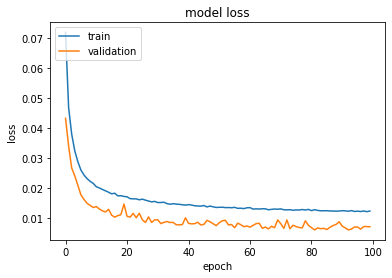

96-fc1d-patch_1-base_1-layer_4-label_FWFsynthetic
(84, 50, 96)
Model: "functional_173"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_40 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_41 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_42 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_43 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_57 (Dropout)         (None, 150)               0         
_______________________________________________________

In [57]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_175"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_58 (Dropout)         (None, 1, 1, 150)         0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 1, 1, 1)     

2022-04-09 15:32:14.656392: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:32:14.656573: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:32:15.204819: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:32:15.228059: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:32:15.228316: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:32:15.229555: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_32_15
2022-04-09 15:32:15.230104: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_32_15/vw.trace.json.gz
2022-04-09 15:32:15.230200: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:32:15.231180: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

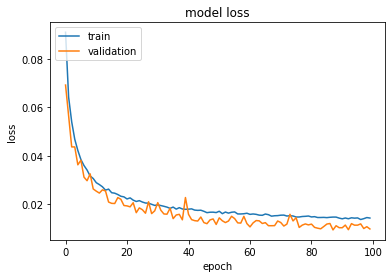

96-conv2d-patch_3-base_1-layer_4-label_FWFsynthetic
(84, 84, 96)
Model: "functional_179"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
dropout_59 (Dropout)         (None, 82, 82, 150)       0         
_____________________________________________________

In [58]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_187"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_84 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_85 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_86 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_87 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_62 (Dropout)         (None, 1, 1, 1, 150)      0         
_________________________________________________________________
conv3d_88 (Conv3D)           (None, 1, 1, 1, 1)  

2022-04-09 15:37:52.124304: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:37:52.124463: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:37:52.872385: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:37:52.895401: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:37:52.895681: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:37:52.896978: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_37_52
2022-04-09 15:37:52.897512: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_37_52/vw.trace.json.gz
2022-04-09 15:37:52.897586: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:37:52.898605: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

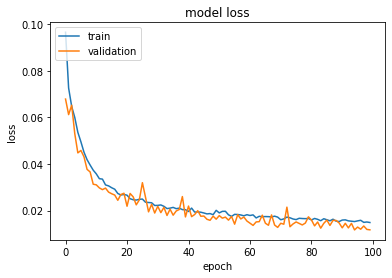

96-conv3d-patch_3-base_1-layer_4-label_FWFsynthetic
(84, 84, 50)
Model: "functional_191"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_89 (Conv3D)           (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_90 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_91 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_92 (Conv3D)           (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
dropout_63 (Dropout)         (None, 82, 82, 48, 150)   0         
_____________________________________________________

In [60]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for fwf is: 0.9582033424368633
3
conv2d
96input size the ssim score for fwf is: 0.9580943751963964
3
conv3d
96input size the ssim score for fwf is: 0.958111229421399


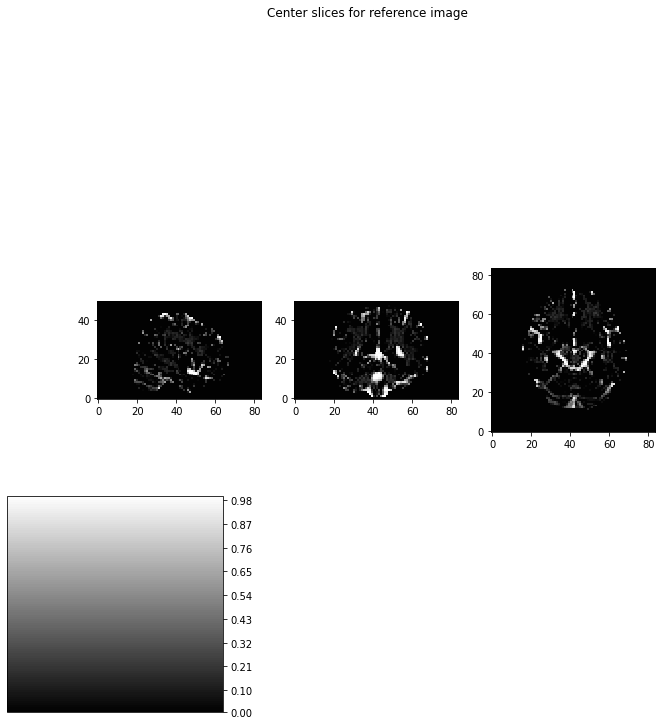

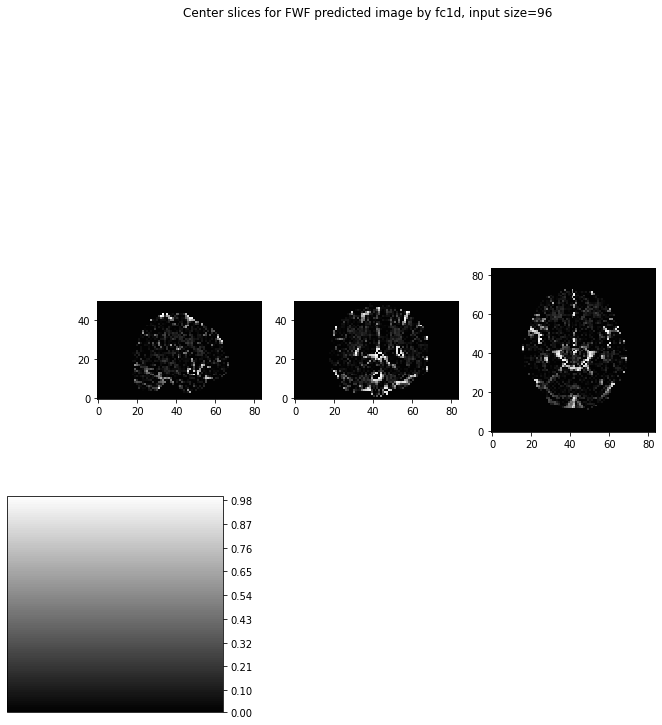

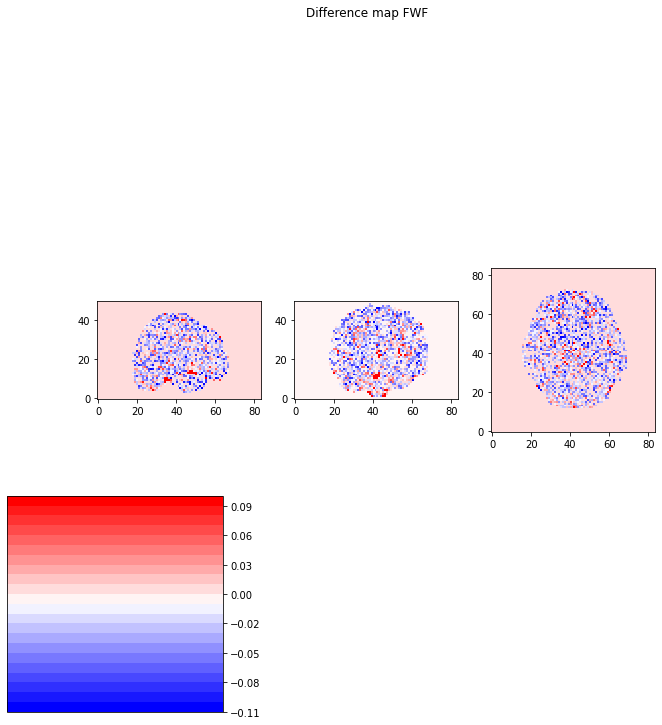

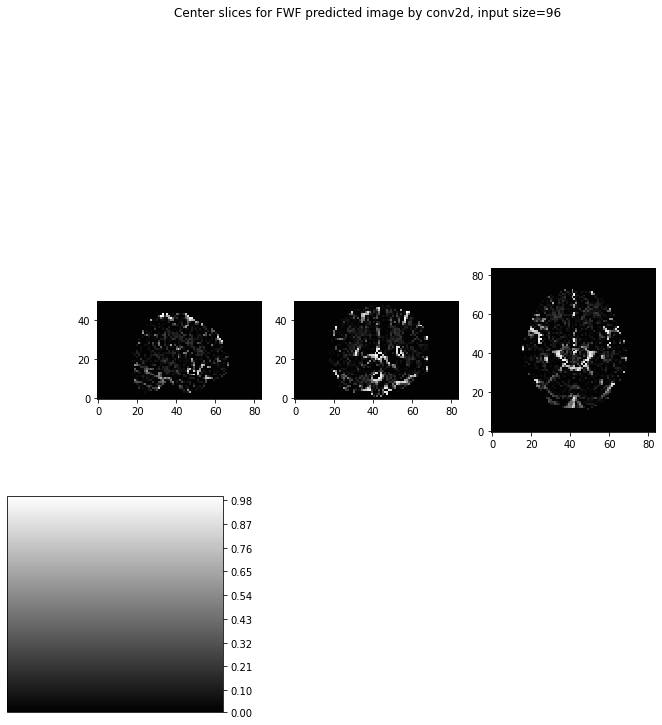

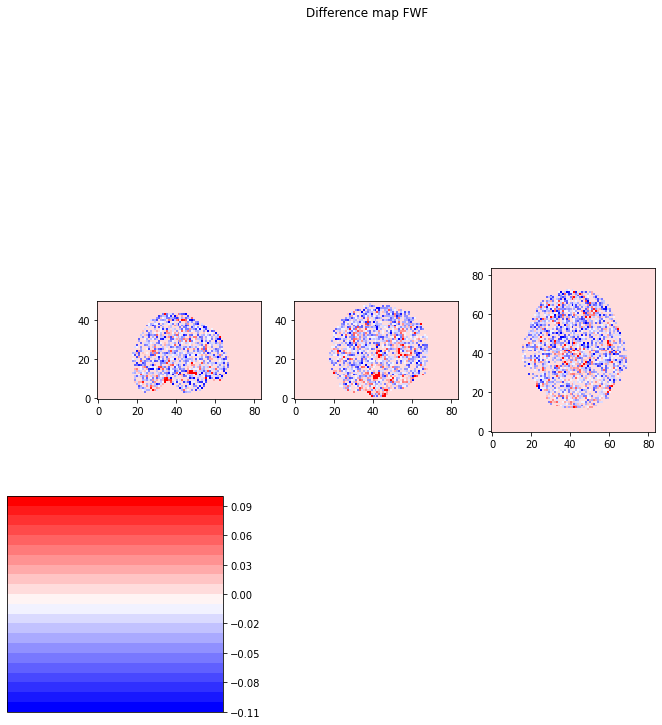

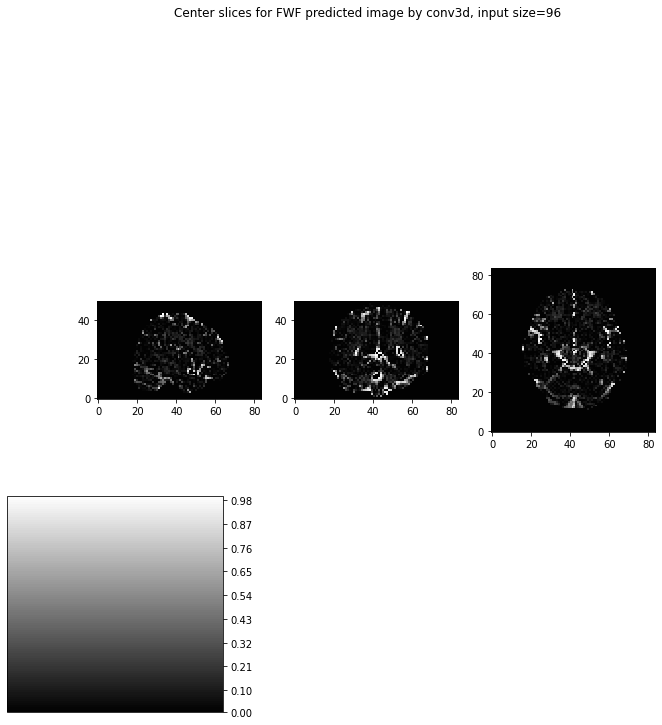

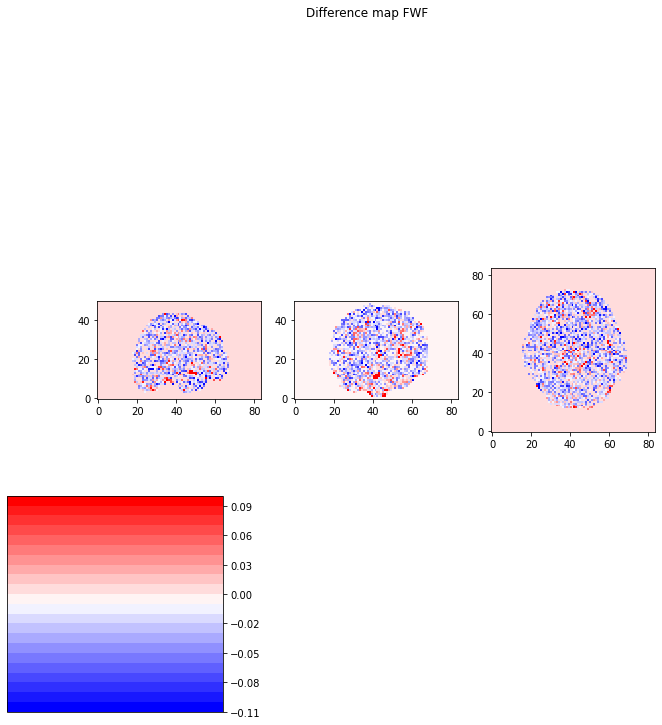

In [61]:
# load the reference img and pred img
visualise0(s01_FWF_img_data)
visualise3(s01_FWF_img_data, 96, 's01_still', 'fc1d',layer, s01_FWF_affine)
visualise3(s01_FWF_img_data, 96, 's01_still', 'conv2d',layer, s01_FWF_affine)
visualise3(s01_FWF_img_data, 96, 's01_still', 'conv3d',layer, s01_FWF_affine)

<strong>5 layer</strong>

In [71]:
layer = 5

ANN

96
Model: "functional_229"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_66 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_67 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_68 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_69 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_70 (Dense)             (None, 150)               22650     
_________________________________________________________________
dropout_76 (Dropout)         (None, 150)         

2022-04-09 15:57:43.719501: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:57:43.719634: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:57:44.251859: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:57:44.277695: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:57:44.277979: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:57:44.279336: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_57_44
2022-04-09 15:57:44.279870: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_57_44/vw.trace.json.gz
2022-04-09 15:57:44.279946: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:57:44.280951: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

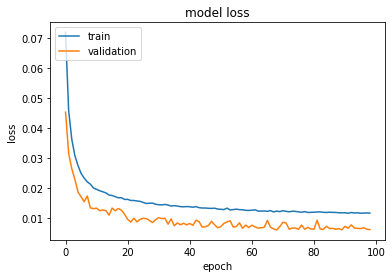

96-fc1d-patch_1-base_1-layer_5-label_FWFsynthetic
(84, 50, 96)
Model: "functional_233"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_71 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_72 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_73 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_74 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_75 (Dense)             (None, 150)               22650     
_______________________________________________________

In [72]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_199"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
dropout_66 (Dropout)         (None, 1, 1, 150)   

2022-04-09 15:42:56.941456: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:42:56.941573: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:42:57.494971: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:42:57.520656: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:42:57.520955: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:42:57.522305: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_42_57
2022-04-09 15:42:57.522858: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_42_57/vw.trace.json.gz
2022-04-09 15:42:57.522939: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:42:57.523935: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

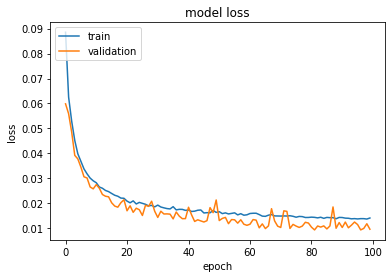

96-conv2d-patch_3-base_1-layer_5-label_FWFsynthetic
(84, 84, 96)
Model: "functional_203"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 82, 82, 150)       22650     
_____________________________________________________

In [64]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_205"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_94 (Conv3D)           (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_95 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_96 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_97 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_98 (Conv3D)           (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
dropout_68 (Dropout)         (None, 1, 1, 1, 150)

2022-04-09 15:45:14.425043: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:45:14.425163: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:45:15.170923: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:45:15.196045: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:45:15.196339: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:45:15.197608: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_45_15
2022-04-09 15:45:15.198183: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_45_15/vw.trace.json.gz
2022-04-09 15:45:15.198273: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:45:15.199323: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

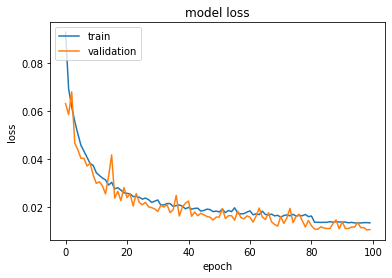

96-conv3d-patch_3-base_1-layer_5-label_FWFsynthetic
(84, 84, 50)
Model: "functional_209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_100 (Conv3D)          (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_101 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_102 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_103 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_104 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_____________________________________________________

In [65]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for fwf is: 0.9576826389680646
3
conv2d
96input size the ssim score for fwf is: 0.9583781437059303
3
conv3d
96input size the ssim score for fwf is: 0.956700655447115


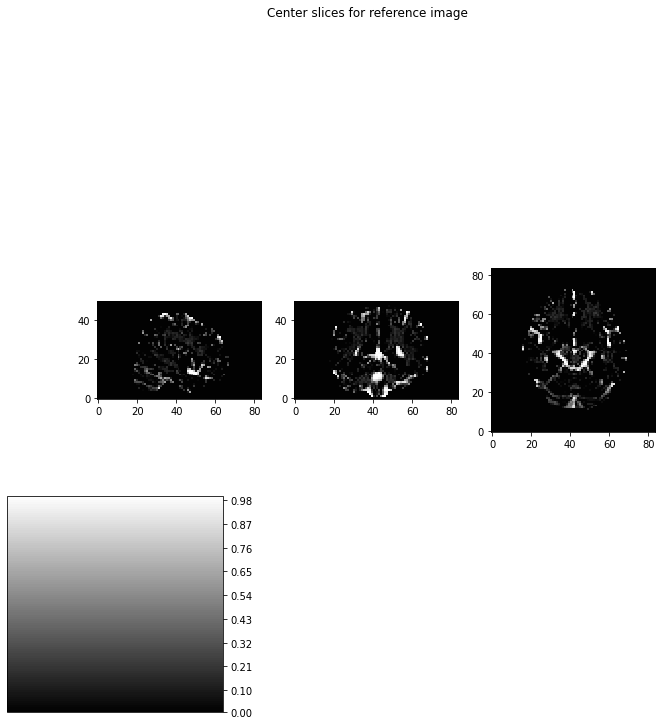

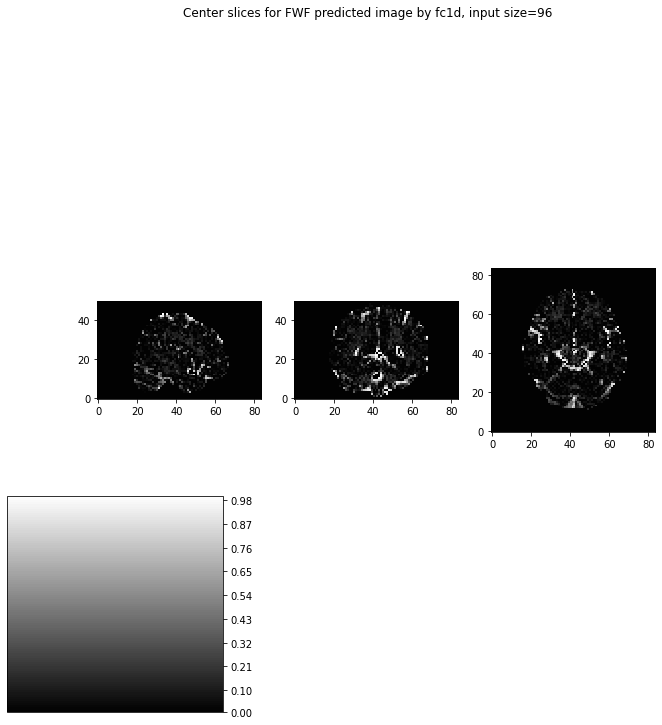

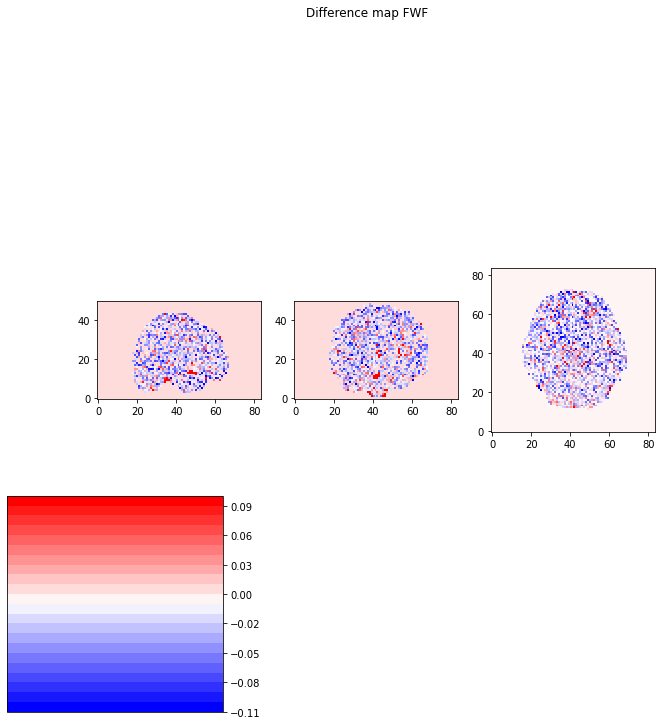

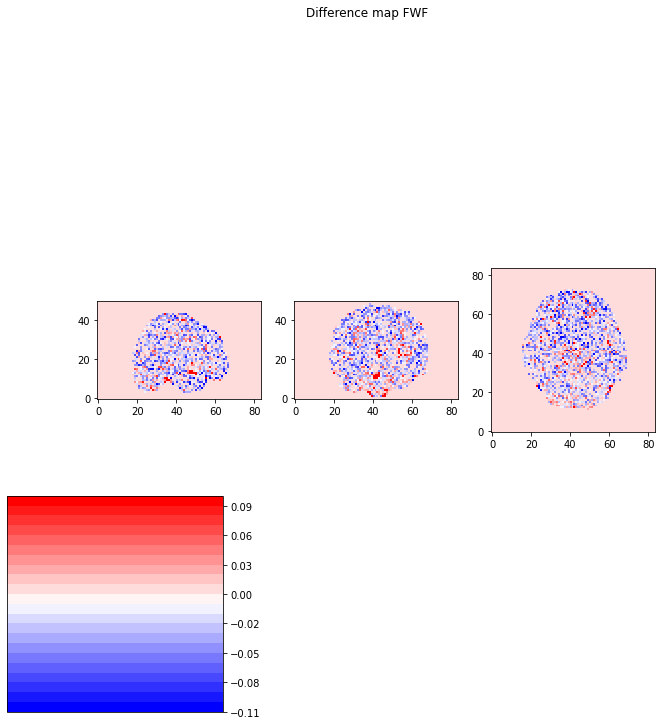

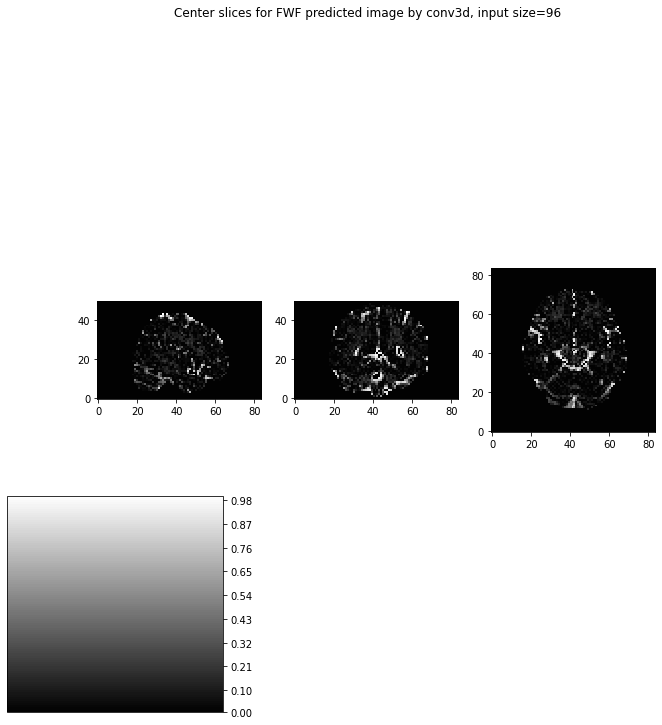

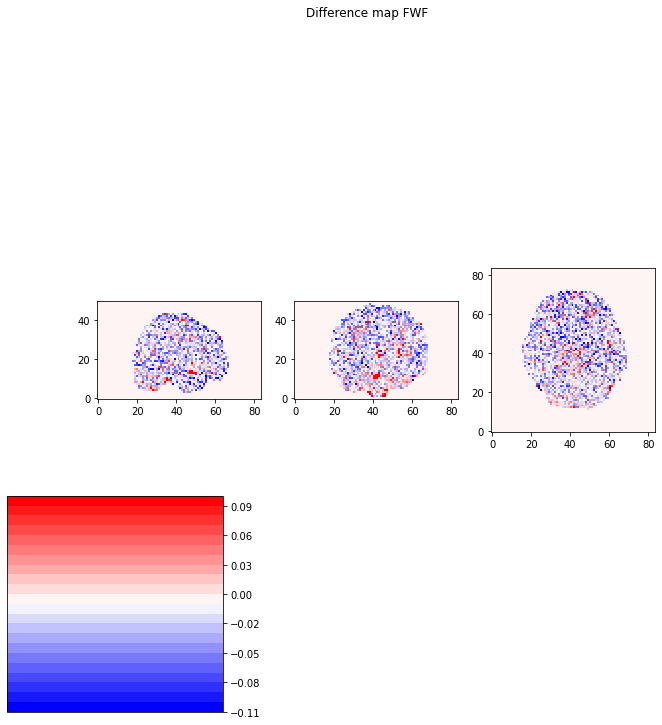

In [73]:
# load the reference img and pred img
visualise0(s01_FWF_img_data)
visualise3(s01_FWF_img_data, 96, 's01_still', 'fc1d',layer, s01_FWF_affine)
visualise3(s01_FWF_img_data, 96, 's01_still', 'conv2d',layer, s01_FWF_affine)
visualise3(s01_FWF_img_data, 96, 's01_still', 'conv3d',layer, s01_FWF_affine)

<strong>6 layer</strong>

In [67]:
layer = 6

ANN

96
Model: "functional_211"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_54 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_55 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_56 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_57 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_58 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_59 (Dense)             (None, 150)         

2022-04-09 15:49:05.888270: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:49:05.888396: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:49:06.325257: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:49:06.351468: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:49:06.351836: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:49:06.353290: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_49_06
2022-04-09 15:49:06.353869: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_49_06/vw.trace.json.gz
2022-04-09 15:49:06.353954: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:49:06.354997: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

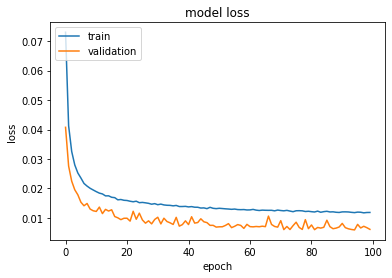

96-fc1d-patch_1-base_1-layer_6-label_FWFsynthetic
(84, 50, 96)
Model: "functional_215"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        [(None, 96)]              0         
_________________________________________________________________
dense_60 (Dense)             (None, 150)               14550     
_________________________________________________________________
dense_61 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_62 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_63 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_64 (Dense)             (None, 150)               22650     
_______________________________________________________

In [68]:
cmd = '--train_subjects '+train_subject+' --model fc1d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model fc1d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

2D CNN

96
Model: "functional_217"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        [(None, 3, 3, 96)]        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 1, 1, 150)         129750    
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 1, 1, 150)         22650     
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 1, 1, 150)   

2022-04-09 15:50:22.242591: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:50:22.242723: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:50:22.810704: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:50:22.839683: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:50:22.840006: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:50:22.841377: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_50_22
2022-04-09 15:50:22.841962: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_50_22/vw.trace.json.gz
2022-04-09 15:50:22.842045: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:50:22.843091: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

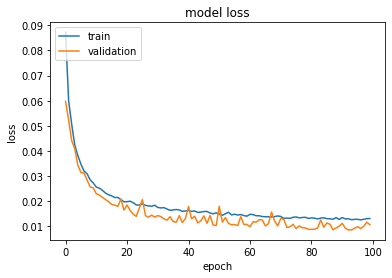

96-conv2d-patch_3-base_1-layer_6-label_FWFsynthetic
(84, 84, 96)
Model: "functional_221"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        [(None, 84, 84, 96)]      0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 82, 82, 150)       129750    
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 82, 82, 150)       22650     
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 82, 82, 150)       22650     
_____________________________________________________

In [69]:
cmd = '--train_subjects '+train_subject+' --model conv2d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv2d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

3D CNN

96
Model: "functional_223"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        [(None, 3, 3, 3, 96)]     0         
_________________________________________________________________
conv3d_106 (Conv3D)          (None, 1, 1, 1, 150)      388950    
_________________________________________________________________
conv3d_107 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_108 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_109 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_110 (Conv3D)          (None, 1, 1, 1, 150)      22650     
_________________________________________________________________
conv3d_111 (Conv3D)          (None, 1, 1, 1, 150)

2022-04-09 15:52:56.083884: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:52:56.083983: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed


2022-04-09 15:52:56.855842: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session started.
2022-04-09 15:52:56.882413: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1513] CUPTI activity buffer flushed
2022-04-09 15:52:56.882703: I tensorflow/core/profiler/internal/gpu/device_tracer.cc:223]  GpuTracer has collected 0 callback api events and 0 activity events. 
2022-04-09 15:52:56.884041: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022_04_09_15_52_56
2022-04-09 15:52:56.884634: I tensorflow/core/profiler/rpc/client/save_profile.cc:182] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_04_09_15_52_56/vw.trace.json.gz
2022-04-09 15:52:56.884718: E tensorflow/core/profiler/utils/hardware_type_utils.cc:61] Invalid GPU compute capability.
2022-04-09 15:52:56.885744: I tensorflow/core/profiler/rpc/client/save_profile.cc:176] Creating directory: logs/train/plugins/profile/2022

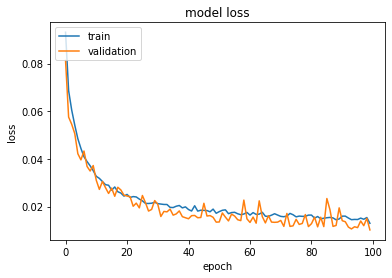

96-conv3d-patch_3-base_1-layer_6-label_FWFsynthetic
(84, 84, 50)
Model: "functional_227"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        [(None, 84, 84, 50, 96)]  0         
_________________________________________________________________
conv3d_113 (Conv3D)          (None, 82, 82, 48, 150)   388950    
_________________________________________________________________
conv3d_114 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_115 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_116 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_________________________________________________________________
conv3d_117 (Conv3D)          (None, 82, 82, 48, 150)   22650     
_____________________________________________________

In [70]:
cmd = '--train_subjects '+train_subject+' --model conv3d --layer '+str(layer)+' --train --label_type F'
plot_loss(cmd)
for test_subject in test_subjects:
    cmd = '--test_subjects '+test_subject+' --model conv3d --layer '+str(layer)+' --label_type F'
    args = model_parser().parse_args(cmd.split())
    test_model(args)

1
fc1d
96input size the ssim score for fwf is: 0.9550568316975543
3
conv2d
96input size the ssim score for fwf is: 0.9641043981275423
3
conv3d
96input size the ssim score for fwf is: 0.957474225878275


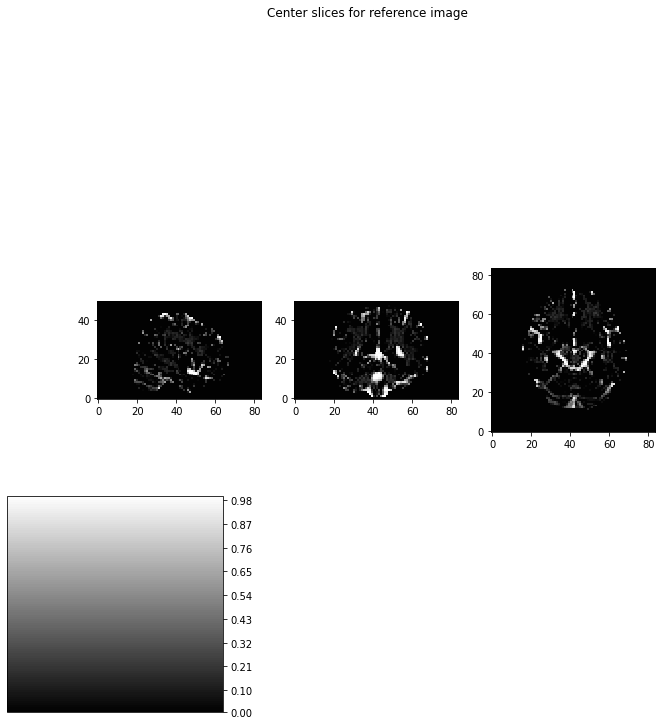

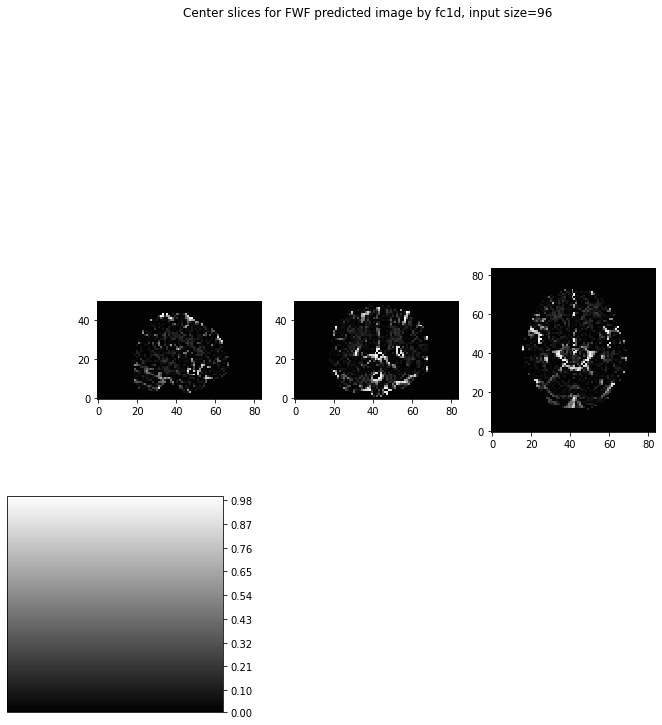

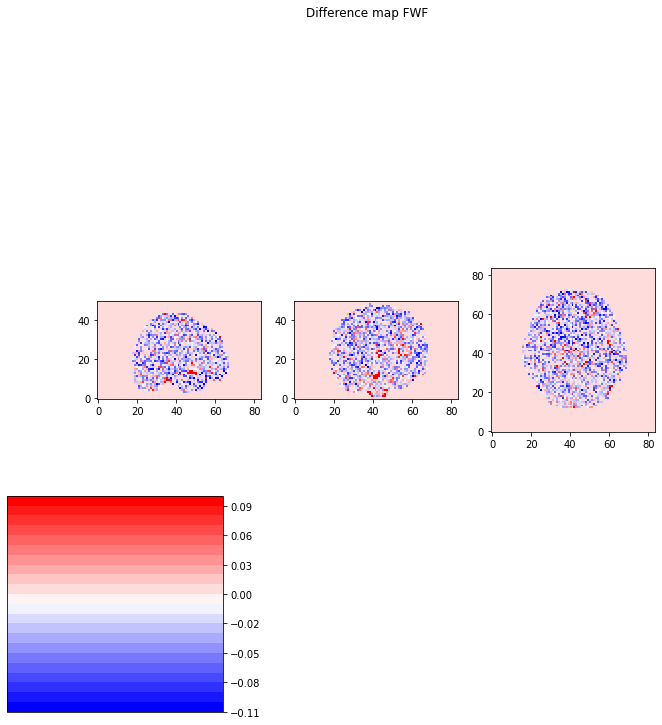

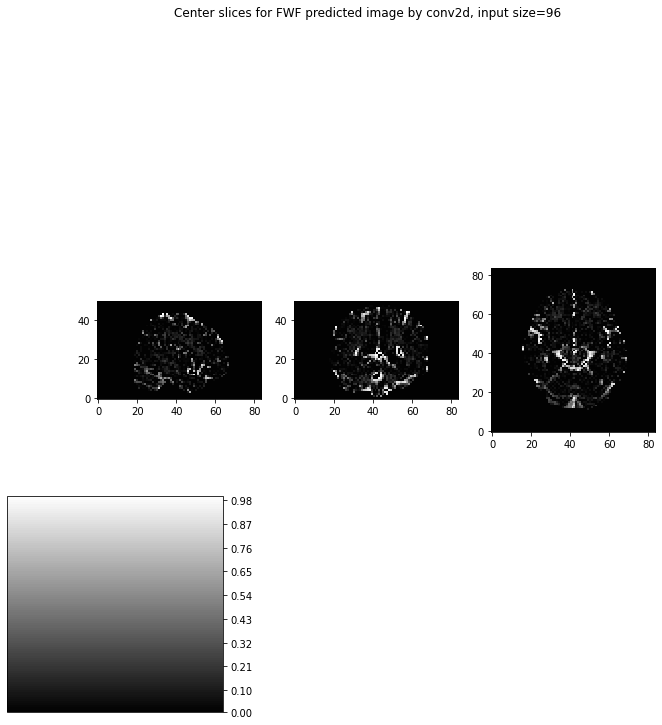

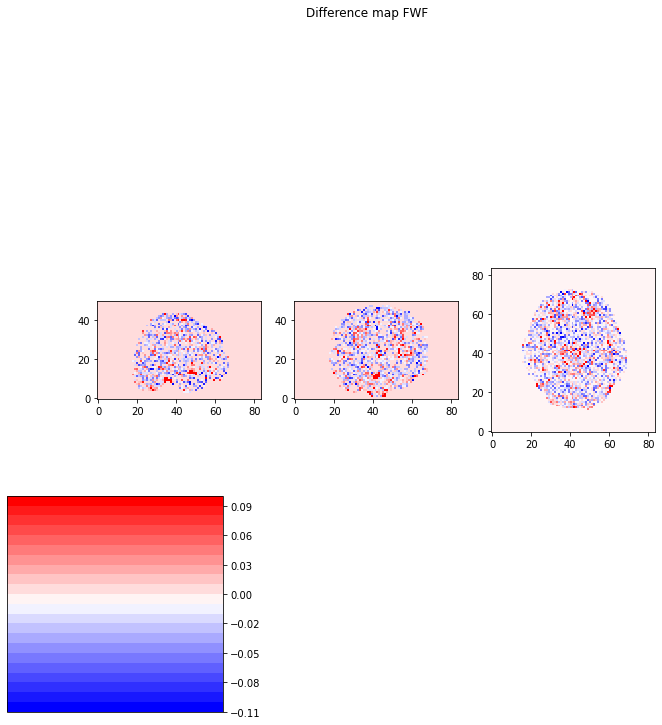

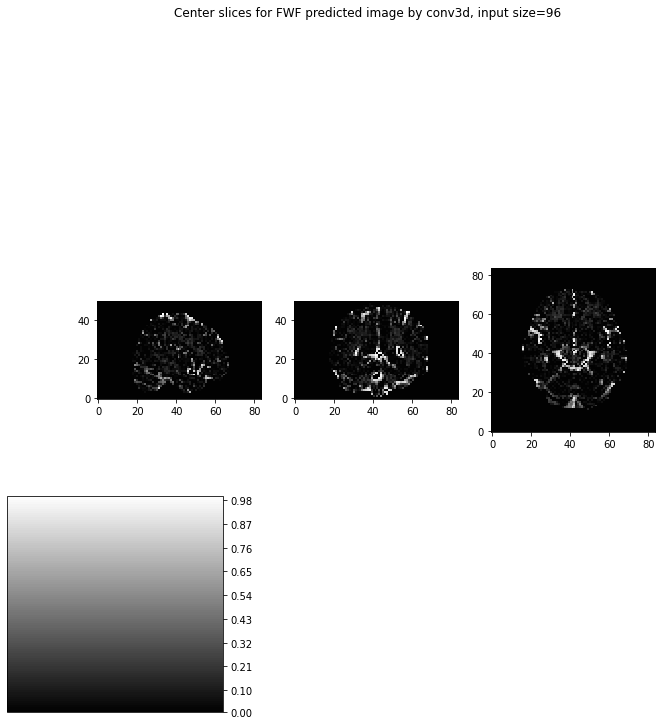

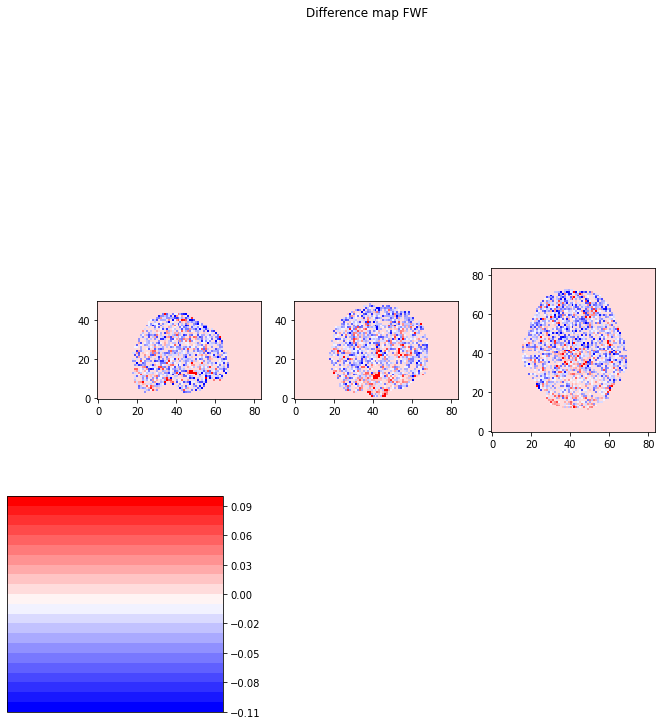

In [114]:
# load the reference img and pred img
visualise0(s01_FWF_img_data)
visualise3(s01_FWF_img_data, 96, 's01_still', 'fc1d',layer, s01_FWF_affine)
visualise3(s01_FWF_img_data, 96, 's01_still', 'conv2d',layer, s01_FWF_affine)
visualise3(s01_FWF_img_data, 96, 's01_still', 'conv3d',layer, s01_FWF_affine)

___

<h4>Test the performace of each network to generate each parameter with varied number of DWI as input size</h4>

Each network (ANN, 2D CNN and 3D CNN) should be implemented with 4 hidden layers. The choice is suggested from the obtained results from the previous experiment

<h4>Training</h4><br/>
ANN

In [115]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # train
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be trained and the size of the input
#         train_cmd = "--train_subjects s02_still --model fc1d --layer 4 --train --label_type " + param[0] + " --DWI " + str(i)
#         # for each training, plot the corresponding loss graph
#         plot_loss(train_cmd)

In [116]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # test
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be tested and the size of the test data
#         print(i)
#         test_cmd = "--test_subjects s01_still --model fc1d --layer 4 --label_type " + param[0] + " --DWI " + str(i)
#         args = model_parser().parse_args(test_cmd.split())
#         # test the trained model
#         test_model(args) 

In [117]:
# # plot each derived image
# # specify the parameters
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# ref_img = [s01_NDI_img, s01_ODI_img, s01_FWF_img] # this is the ref img data list
# ref_img_data = [s01_NDI_img_data, s01_ODI_img_data, s01_FWF_img_data] # this is the ref img data list
# # iterate, so plot each param in order
# for i in range (len(params)):
#     # plot the reference img first
#     ref_slice_0 = ref_img_data[i][26, :, :]
#     ref_slice_1 = ref_img_data[i][:, 30, :]
#     ref_slice_2 = ref_img_data[i][:, :, 16]
#     show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
#     plt.suptitle("Center slices for s01_still_" + params[i] + " reference image")
    
#     affine = ref_img[i].affine
    
#     for j in np.arange(start=6, stop=97, step=10):
#         # plot the predicted imgs for different input size
#         pred_path = '../Net/nii/s01_still-' + str(j)+'-fc1d-patch_1-base_1-layer_4-label_'+params[i]+'.nii'
#         # load the img
#         pred_img = nib.load(pred_path)
#         # fetch the data
#         pred_data = pred_img.get_fdata()

#         # plot the pred img
#         pred0 = pred_data[26, :, :]
#         pred1 = pred_data[:, 30, :]
#         pred2 = pred_data[:, :, 16]
#         show_slices([pred0, pred1, pred2])
#         plt.suptitle("Center slices for s01_still_" + params[i] + " predicted image by ANN, input size="+str(j))

#         # plot the difference img
#         diff0 = ref_slice_0 - pred0
#         diff1 = ref_slice_1 - pred1
#         diff2 = ref_slice_2 - pred2
#         show_slices([diff0, diff1, diff2], grayscale=False)
#         plt.suptitle('Difference map')

#         diff_img_np = ref_img_data[i] - pred_data
#         diff_img = nib.Nifti1Image(diff_img_np, affine)
#         nib.save(diff_img, '../Net/nii/s01_still-' + str(j)+'-fc1d-patch_1-base_1-layer_4-label_'+params[i]+'_difference.nii')   

5 Layer


In [118]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # train
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be trained and the size of the input
#         train_cmd = "--train_subjects s01_still --model fc1d --layer 5 --train --label_type " + param[0] + " --DWI " + str(i)
#         # for each training, plot the corresponding loss graph
#         plot_loss(train_cmd)

In [119]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # test
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be tested and the size of the test data
#         print(i)
#         test_cmd = "--test_subjects s02_still --model fc1d --layer 5 --label_type " + param[0] + " --DWI " + str(i)
#         args = model_parser().parse_args(test_cmd.split())
#         # test the trained model
#         test_model(args) 

2D CNN<br/>
repeat exactly the same process as above, but change the network to 2D CNN

In [120]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # train
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be trained and the size of the input
#         train_cmd = "--train_subjects s02_still --model conv2d --layer 4 --train --label_type " + param[0] + " --DWI " + str(i)
#         # for each training, plot the corresponding loss graph
#         plot_loss(train_cmd)

In [121]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # test
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be tested and the size of the test data
#         test_cmd = "--test_subjects s01_still --model conv2d --layer 4 --label_type " + param[0] + " --DWI " + str(i)
#         args = model_parser().parse_args(test_cmd.split())
#         # test the trained model
#         test_model(args)

In [122]:
# # plot each derived image
# # specify the parameters
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# ref_img = [s01_NDI_img, s01_ODI_img, s01_FWF_img] # this is the ref img data list
# ref_img_data = [s01_NDI_img_data, s01_ODI_img_data, s01_FWF_img_data] # this is the ref img data list
# # iterate, so plot each param in order
# for i in range (len(params)):
#     # plot the reference img first
#     ref_slice_0 = ref_img_data[i][26, :, :]
#     ref_slice_1 = ref_img_data[i][:, 30, :]
#     ref_slice_2 = ref_img_data[i][:, :, 16]
#     show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
#     plt.suptitle("Center slices for s01_still_" + params[i] + " reference image")
    
#     affine = ref_img[i].affine
    
#     for j in np.arange(start=6, stop=97, step=10):
#         # plot the predicted imgs for different input size
#         pred_path = '../Net/nii/s01_still-' + str(j)+'-conv2d-patch_3-base_1-layer_4-label_'+params[i]+'.nii'
#         # load the img
#         pred_img = nib.load(pred_path)
#         # fetch the data
#         pred_data = pred_img.get_fdata()

#         # plot the pred img
#         pred0 = pred_data[26, :, :]
#         pred1 = pred_data[:, 30, :]
#         pred2 = pred_data[:, :, 16]
#         show_slices([pred0, pred1, pred2])
#         plt.suptitle("Center slices for s01_still_" + params[i] + " predicted image by 2D CNN, input size="+str(j))

#         # plot the difference img
#         diff0 = ref_slice_0 - pred0
#         diff1 = ref_slice_1 - pred1
#         diff2 = ref_slice_2 - pred2
#         show_slices([diff0, diff1, diff2], grayscale=False)
#         plt.suptitle('Difference map')

#         diff_img_np = ref_img_data[i] - pred_data
#         diff_img = nib.Nifti1Image(diff_img_np, affine)
#         nib.save(diff_img, '../Net/nii/s01_still-' + str(j)+'-conv2d-patch_3-base_1-layer_4-label_'+params[i]+'_difference.nii')   

5 Layer

In [123]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # train
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be trained and the size of the input
#         train_cmd = "--train_subjects s01_still --model conv2d --layer 5 --train --label_type " + param[0] + " --DWI " + str(i)
#         # for each training, plot the corresponding loss graph
#         plot_loss(train_cmd)

In [124]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # test
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be tested and the size of the test data
#         test_cmd = "--test_subjects s02_still --model conv2d --layer 5 --label_type " + param[0] + " --DWI " + str(i)
#         args = model_parser().parse_args(test_cmd.split())
#         # test the trained model
#         test_model(args)

3D CNN<br/>
repeat the same process as above

In [125]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # train
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be trained and the size of the input
#         train_cmd = "--train_subjects s02_still --model conv3d --layer 4 --train --label_type " + param[0] + " --DWI " + str(i)
#         # for each training, plot the corresponding loss graph
#         plot_loss(train_cmd)

In [126]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # test
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be tested and the size of the test data
#         test_cmd = "--test_subjects s01_still --model conv3d --layer 4 --label_type " + param[0] + " --DWI " + str(i)
#         args = model_parser().parse_args(test_cmd.split())
#         # test the trained model
#         test_model(args)

In [127]:
# # plot each derived image
# # specify the parameters
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# ref_img = [s01_NDI_img, s01_ODI_img, s01_FWF_img] # this is the ref img data list
# ref_img_data = [s01_NDI_img_data, s01_ODI_img_data, s01_FWF_img_data] # this is the ref img data list
# # iterate, so plot each param in order
# for i in range (len(params)):
#     # plot the reference img first
#     ref_slice_0 = ref_img_data[i][26, :, :]
#     ref_slice_1 = ref_img_data[i][:, 30, :]
#     ref_slice_2 = ref_img_data[i][:, :, 16]
#     show_slices([ref_slice_0, ref_slice_1, ref_slice_2])
#     plt.suptitle("Center slices for s01_still_" + params[i] + " reference image")
    
#     affine = ref_img[i].affine
    
#     for j in np.arange(start=6, stop=97, step=10):
#         # plot the predicted imgs for different input size
#         pred_path = '../Net/nii/s01_still-' + str(j)+'-conv3d-patch_3-base_1-layer_4-label_'+params[i]+'.nii'
#         # load the img
#         pred_img = nib.load(pred_path)
#         # fetch the data
#         pred_data = pred_img.get_fdata()

#         # plot the pred img
#         pred0 = pred_data[26, :, :]
#         pred1 = pred_data[:, 30, :]
#         pred2 = pred_data[:, :, 16]
#         show_slices([pred0, pred1, pred2])
#         plt.suptitle("Center slices for s01_still_" + params[i] + " predicted image by 3D CNN, input size="+str(j))

#         # plot the difference img
#         diff0 = ref_slice_0 - pred0
#         diff1 = ref_slice_1 - pred1
#         diff2 = ref_slice_2 - pred2
#         show_slices([diff0, diff1, diff2], grayscale=False)
#         plt.suptitle('Difference map')

#         diff_img_np = ref_img_data[i] - pred_data
#         diff_img = nib.Nifti1Image(diff_img_np, affine)
#         nib.save(diff_img, '../Net/nii/s01_still-' + str(j)+'-conv3d-patch_3-base_1-layer_4-label_'+params[i]+'_difference.nii')    

5 Layer

In [128]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # train
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be trained and the size of the input
#         train_cmd = "--train_subjects s01_still --model conv3d --layer 5 --train --label_type " + param[0] + " --DWI " + str(i)
#         # for each training, plot the corresponding loss graph
#         plot_loss(train_cmd)

In [129]:
# # define the list of parameters required to be trained and tested
# params = ['NDI', 'ODI', 'FWF'] # this is for NODDI
# # test
# for param in params:
#     # vary the input size; in this case becasue I know the max input size is 96
#     for i in np.arange(start=6, stop=97, step=10):
#         # specify the param to be tested and the size of the test data
#         test_cmd = "--test_subjects s02_still --model conv3d --layer 5 --label_type " + param[0] + " --DWI " + str(i)
#         args = model_parser().parse_args(test_cmd.split())
#         # test the trained model
#         test_model(args)